https://www.kaggle.com/code/gunesevitan/survival-analysis

In [1]:
!pip install lifelines

In [127]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.preprocessing import OneHotEncoder

from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import matplotlib as mpl
from lifelines.statistics import logrank_test
from lifelines import NelsonAalenFitter
from lifelines import CoxPHFitter
from lifelines.utils import median_survival_times

from lifelines.statistics import proportional_hazard_test

from lifelines import WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter
from lifelines import WeibullAFTFitter

### Functions

In [3]:
#########################
### Compare box plots ###
#########################

def boxplot_compare(target, var, num):
    fig, ax=plt.subplots(1, 2, figsize=(20, 7))
    d1 = df[df[target] == 'Living']
    d1 = d1.sort_values([var])
    d2 = df[df[target] == 'Deceased']
    d2 = d2.sort_values([var])
    g1 = sns.boxplot(data=d1, x=num, y=var, palette='rainbow', showmeans=True, ax=ax[0])
    g1.set_title("Living Data")
    g1.set_xlim(0, int(max(df[num]) + 10))

    g2 = sns.boxplot(data=d2, x=num, y=var, palette='rainbow', showmeans=True, ax=ax[1])
    g2.set(ylabel=None)
    g2.set(yticklabels=[]) 
    g2.set_title("Deceased Data")
    g2.set_xlim(0, int(max(df[num]) + 10))
    plt.show();

In [4]:
def pie_chat(name, threshold = 100):
    c_loc = df.sort_values(by = name)
    c_loc = c_loc.groupby([name]).size().to_frame('Count')
    c_loc = c_loc.reset_index()
    c_loc['perc'] = c_loc['Count']/df.shape[0] * 100
    c_loc = c_loc.sort_values(by = 'perc', ascending = False)
    c_loc['cum_perc'] = c_loc['perc'].cumsum()
    c_loc = c_loc.reset_index(drop=True)
    
    if threshold:
        c_loc = c_loc[c_loc.cum_perc < threshold]

    my_circle = plt.Circle( (0,0), 0.7, color='white')

    plt.pie(c_loc.perc, labels=c_loc[name], wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
    p = plt.gcf()
    p.gca().add_artist(my_circle)
    plt.show()

In [40]:
########################
### One hot encoding ###
########################

def ohe_dset(dset,categorical_columns):

    dseta = dset.copy()
    transformed_dset = ohe.fit_transform(dseta[categorical_columns])
    cat_data = pd.DataFrame(transformed_dset.toarray())
    cat_data.columns = ohe.get_feature_names_out(input_features=dseta[categorical_columns].columns)
    print(cat_data.shape)
    return cat_data

### Read in the data

In [5]:
data = pd.read_csv('Breast Cancer METABRIC.csv')
print(data.shape)
data.head()

(2509, 34)


Patient ID  Age at Diagnosis Type of Breast Surgery    Cancer Type  \
0    MB-0000             75.65             Mastectomy  Breast Cancer   
1    MB-0002             43.19      Breast Conserving  Breast Cancer   
2    MB-0005             48.87             Mastectomy  Breast Cancer   
3    MB-0006             47.68             Mastectomy  Breast Cancer   
4    MB-0008             76.97             Mastectomy  Breast Cancer   

                        Cancer Type Detailed Cellularity Chemotherapy  \
0           Breast Invasive Ductal Carcinoma         NaN           No   
1           Breast Invasive Ductal Carcinoma        High           No   
2           Breast Invasive Ductal Carcinoma        High          Yes   
3  Breast Mixed Ductal and Lobular Carcinoma    Moderate          Yes   
4  Breast Mixed Ductal and Lobular Carcinoma        High          Yes   

  Pam50 + Claudin-low subtype  Cohort ER status measured by IHC  ...  \
0                 claudin-low     1.0                   Positve  ...   
1                        LumA     1.0                   Positve  ...   
2                        LumB     1.0                   Positve  ...   
3                        LumB     1.0                   Positve  ...   
4                        LumB     1.0                   Positve  ...   

  Overall Survival Status  PR Status Radio Therapy  \
0                  Living   Negative           Yes   
1                  Living   Positive           Yes   
2                Deceased   Positive            No   
3                  Living   Positive           Yes   
4                Deceased   Positive           Yes   

  Relapse Free Status (Months) Relapse Free Status     Sex  \
0                       138.65        Not Recurred  Female   
1                        83.52        Not Recurred  Female   
2                       151.28            Recurred  Female   
3                       162.76        Not Recurred  Female   
4                        18.55            Recurred  Female   

  3-Gene classifier subtype Tumor Size Tumor Stage  Patient's Vital Status  
0                 ER-/HER2-       22.0         2.0                  Living  
1     ER+/HER2- High Prolif       10.0         1.0                  Living  
2                       NaN       15.0         2.0         Died of Disease  
3                       NaN       25.0         2.0                  Living  
4     ER+/HER2- High Prolif       40.0         2.0         Died of Disease  

[5 rows x 34 columns]

In [6]:
nonvar_lst = []

for i in range(data.shape[1]):
    print('Column: ', data.columns[i], ', number of unique classes: ', data.iloc[:,i].nunique())
    if data.iloc[:,i].nunique() < 50:
        print('Values: ', list(set(data.iloc[:,i])))
    if data.iloc[:,i].nunique() == 1:
        nonvar_lst.append(data.columns[i])
print(nonvar_lst)

Column:  Patient ID , number of unique classes:  2509
Column:  Age at Diagnosis , number of unique classes:  1843
Column:  Type of Breast Surgery , number of unique classes:  2
Values:  ['Breast Conserving', nan, 'Mastectomy']
Column:  Cancer Type , number of unique classes:  2
Values:  ['Breast Cancer', 'Breast Sarcoma']
Column:  Cancer Type Detailed , number of unique classes:  8
Values:  ['Invasive Breast Carcinoma', 'Breast Invasive Ductal Carcinoma', 'Breast Mixed Ductal and Lobular Carcinoma', 'Breast Invasive Lobular Carcinoma', 'Breast Angiosarcoma', 'Breast', 'Breast Invasive Mixed Mucinous Carcinoma', 'Metaplastic Breast Cancer']
Column:  Cellularity , number of unique classes:  3
Values:  ['Low', 'High', 'Moderate', nan]
Column:  Chemotherapy , number of unique classes:  2
Values:  ['Yes', 'No', nan]
Column:  Pam50 + Claudin-low subtype , number of unique classes:  7
Values:  ['Her2', 'NC', 'LumB', 'Normal', nan, 'Basal', 'claudin-low', 'LumA']
Column:  Cohort , number of un

In [7]:
data = data.drop(nonvar_lst, axis = 1)

In [8]:
print(list(data.columns))

['Patient ID', 'Age at Diagnosis', 'Type of Breast Surgery', 'Cancer Type', 'Cancer Type Detailed', 'Cellularity', 'Chemotherapy', 'Pam50 + Claudin-low subtype', 'Cohort', 'ER status measured by IHC', 'ER Status', 'Neoplasm Histologic Grade', 'HER2 status measured by SNP6', 'HER2 Status', 'Tumor Other Histologic Subtype', 'Hormone Therapy', 'Inferred Menopausal State', 'Integrative Cluster', 'Primary Tumor Laterality', 'Lymph nodes examined positive', 'Mutation Count', 'Nottingham prognostic index', 'Oncotree Code', 'Overall Survival (Months)', 'Overall Survival Status', 'PR Status', 'Radio Therapy', 'Relapse Free Status (Months)', 'Relapse Free Status', '3-Gene classifier subtype', 'Tumor Size', 'Tumor Stage', "Patient's Vital Status"]


### Missing data

In [9]:
check = data.isnull().sum()
check = pd.DataFrame(check)
check.columns = ['Count']
check['perc'] = check.Count/data.shape[0]*100
check

Count       perc
Patient ID                          0   0.000000
Age at Diagnosis                   11   0.438422
Type of Breast Surgery            554  22.080510
Cancer Type                         0   0.000000
Cancer Type Detailed                0   0.000000
Cellularity                       592  23.595058
Chemotherapy                      529  21.084097
Pam50 + Claudin-low subtype       529  21.084097
Cohort                             11   0.438422
ER status measured by IHC          83   3.308091
ER Status                          40   1.594261
Neoplasm Histologic Grade         121   4.822639
HER2 status measured by SNP6      529  21.084097
HER2 Status                       529  21.084097
Tumor Other Histologic Subtype    135   5.380630
Hormone Therapy                   529  21.084097
Inferred Menopausal State         529  21.084097
Integrative Cluster               529  21.084097
Primary Tumor Laterality          639  25.468314
Lymph nodes examined positive     266  10.601833
Mutation Count                    152   6.058191
Nottingham prognostic index       222   8.848147
Oncotree Code                       0   0.000000
Overall Survival (Months)         528  21.044241
Overall Survival Status           528  21.044241
PR Status                         529  21.084097
Radio Therapy                     529  21.084097
Relapse Free Status (Months)      121   4.822639
Relapse Free Status                21   0.836987
3-Gene classifier subtype         745  29.693105
Tumor Size                        149   5.938621
Tumor Stage                       721  28.736548
Patient's Vital Status            529  21.084097

### Target variable

In [10]:
data[['Overall Survival (Months)','Overall Survival Status']].head()

Overall Survival (Months) Overall Survival Status
0                 140.500000                  Living
1                  84.633333                  Living
2                 163.700000                Deceased
3                 164.933333                  Living
4                  41.366667                Deceased

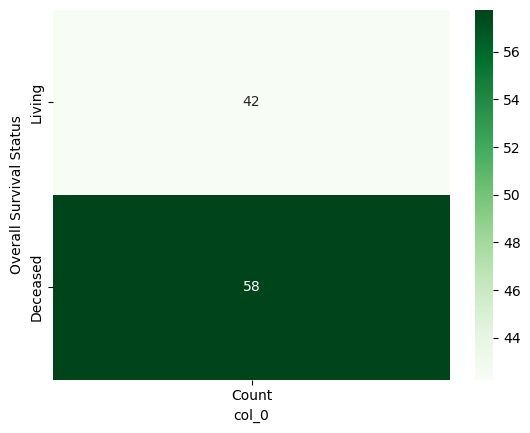

In [11]:
target_t = pd.DataFrame(pd.crosstab(data['Overall Survival Status'], columns = 'Count', normalize='columns'))
target_t = target_t * 100

ax = sns.heatmap(target_t, annot = True, cmap="Greens")
ax.invert_yaxis()

### Adjust the training set

In [12]:
data = data.drop_duplicates()
print(data.shape)

(2509, 33)


In [65]:
df = data.copy()

df['Overall_Survival_Status_n'] = (df['Overall Survival Status'] == 'Deceased').astype(int) 
df['Chemotherapy_n'] = (df['Chemotherapy'] == 'Yes').astype(int) 

df.columns = df.columns.str.replace(r"[\"\',]", '')
df.columns = df.columns.str.replace('(','')
df.columns = df.columns.str.replace(')','')
df.columns = df.columns.str.replace(' ','_')
df.columns = df.columns.str.replace('-','_')
df.columns = df.columns.str.replace('+','')

df.Cohort = df.Cohort.astype('str')
df.Tumor_Stage = df.Tumor_Stage.astype('str')
df.Neoplasm_Histologic_Grade = df.Neoplasm_Histologic_Grade.astype('str')

df = df[(~df.Overall_Survival_Status.isna()) & (~df.Overall_Survival_Months.isna())]

df.columns = df.columns.str.replace("'","")

cat_cols = list(df.select_dtypes(include=['object']))

for name in cat_cols:
    df.loc[df[name].isna(),name] = 'Missing'
    
for name in ['Mutation_Count','Lymph_nodes_examined_positive','Nottingham_prognostic_index','Tumor_Size']:
    new_column = df.groupby(['Cancer_Type_Detailed'])[name].apply(lambda x: x.fillna(x.mean()))
    df[name] = new_column.reset_index(level=0, drop=True)
    df[name] = df[name].fillna(np.mean(df[name]))    

print(list(df.columns))

['Patient_ID', 'Age_at_Diagnosis', 'Type_of_Breast_Surgery', 'Cancer_Type', 'Cancer_Type_Detailed', 'Cellularity', 'Chemotherapy', 'Pam50__Claudin_low_subtype', 'Cohort', 'ER_status_measured_by_IHC', 'ER_Status', 'Neoplasm_Histologic_Grade', 'HER2_status_measured_by_SNP6', 'HER2_Status', 'Tumor_Other_Histologic_Subtype', 'Hormone_Therapy', 'Inferred_Menopausal_State', 'Integrative_Cluster', 'Primary_Tumor_Laterality', 'Lymph_nodes_examined_positive', 'Mutation_Count', 'Nottingham_prognostic_index', 'Oncotree_Code', 'Overall_Survival_Months', 'Overall_Survival_Status', 'PR_Status', 'Radio_Therapy', 'Relapse_Free_Status_Months', 'Relapse_Free_Status', '3_Gene_classifier_subtype', 'Tumor_Size', 'Tumor_Stage', 'Patients_Vital_Status', 'Overall_Survival_Status_n', 'Chemotherapy_n']


In [159]:
check = df.isnull().sum()
check = pd.DataFrame(check)
check.columns = ['Count']
check['perc'] = check.Count/df.shape[0]*100
check[check.Count != 0]

Empty DataFrame
Columns: [Count, perc]
Index: []

In [37]:
#pd.crosstab(df['Lymph_nodes_examined_positive'], columns = 'Count')

### Numerical data

In [16]:
num_cols = list(df.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns)
num_cols = (list(set(num_cols) - set([col for col in df.columns if '_n' in col])))
print(num_cols)

['Overall_Survival_Months', 'Tumor_Size', 'Relapse_Free_Status_Months', 'Age_at_Diagnosis', 'Mutation_Count', 'Nottingham_prognostic_index']


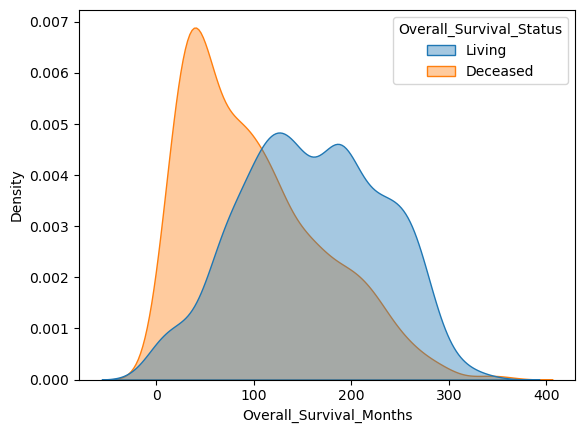

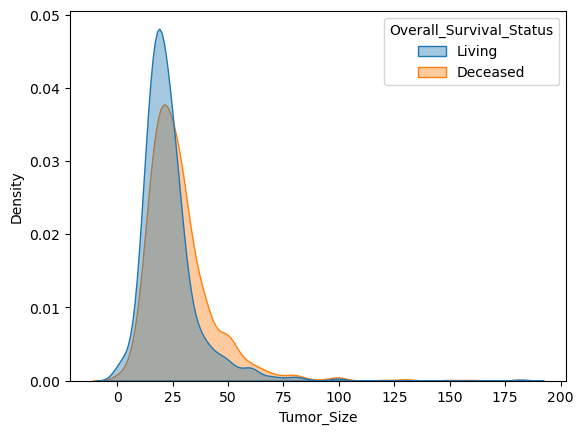

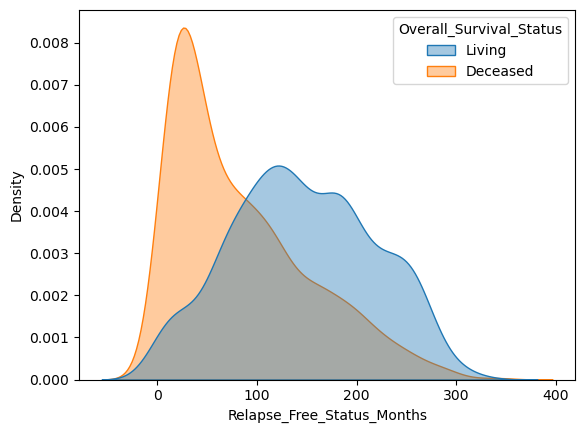

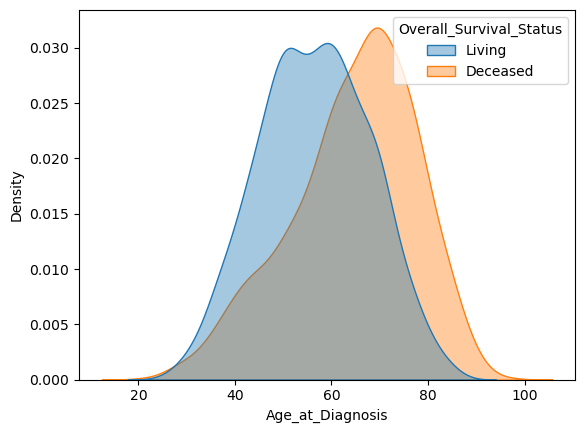

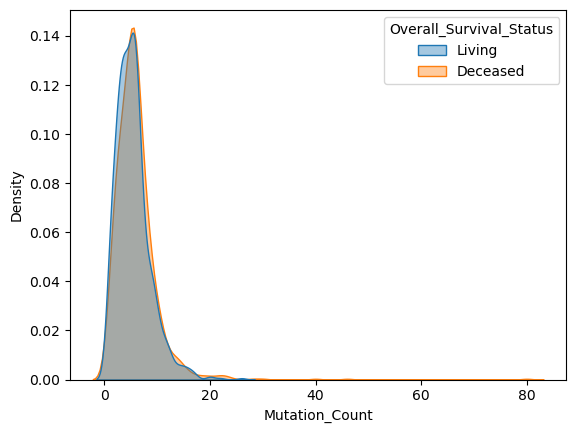

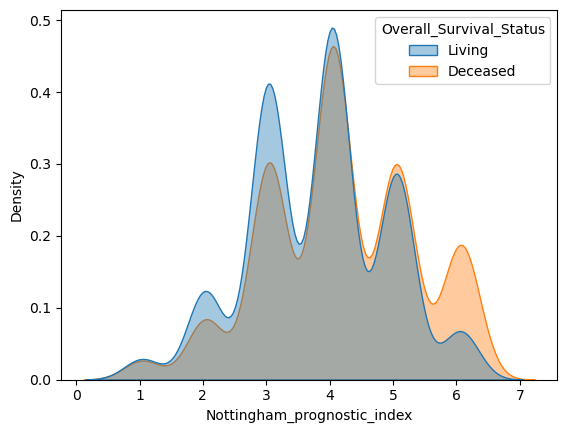

In [17]:
for name in num_cols:
    sns.kdeplot(data=df, x=name, hue="Overall_Survival_Status", fill=True, common_norm=False, alpha=0.4)
    plt.show()

In [18]:
#pd.crosstab(df.Neoplasm_Histologic_Grade, columns = 'Count')

### Interaction terms

In [19]:
cat_cols = list(df.select_dtypes(include=['object']))
cat_cols.remove('Patient_ID')
cat_cols.remove('Cancer_Type')
cat_cols.remove('Overall_Survival_Status')
print(cat_cols)

['Type_of_Breast_Surgery', 'Cancer_Type_Detailed', 'Cellularity', 'Chemotherapy', 'Pam50__Claudin_low_subtype', 'Cohort', 'ER_status_measured_by_IHC', 'ER_Status', 'Neoplasm_Histologic_Grade', 'HER2_status_measured_by_SNP6', 'HER2_Status', 'Tumor_Other_Histologic_Subtype', 'Hormone_Therapy', 'Inferred_Menopausal_State', 'Integrative_Cluster', 'Primary_Tumor_Laterality', 'Oncotree_Code', 'PR_Status', 'Radio_Therapy', 'Relapse_Free_Status', '3_Gene_classifier_subtype', 'Tumor_Stage', "Patient's_Vital_Status"]


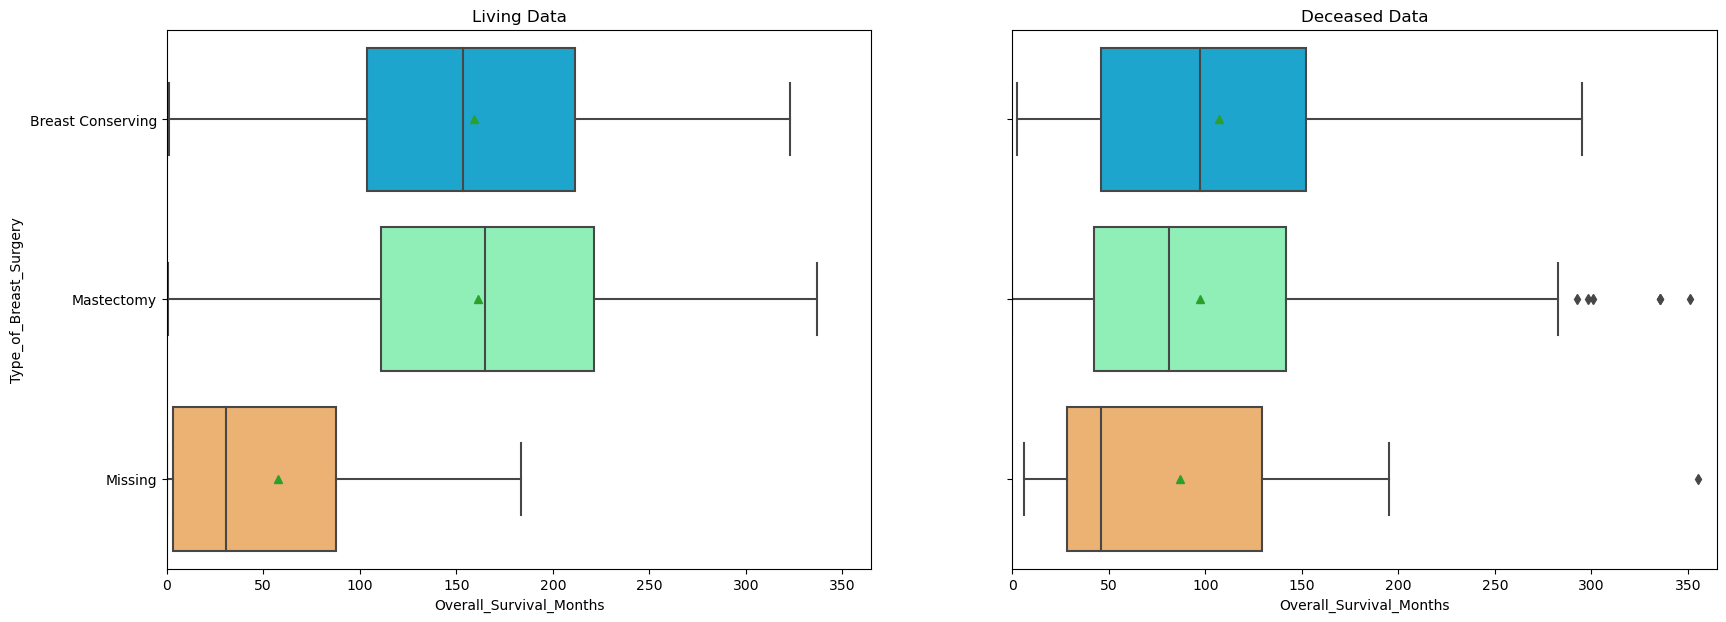

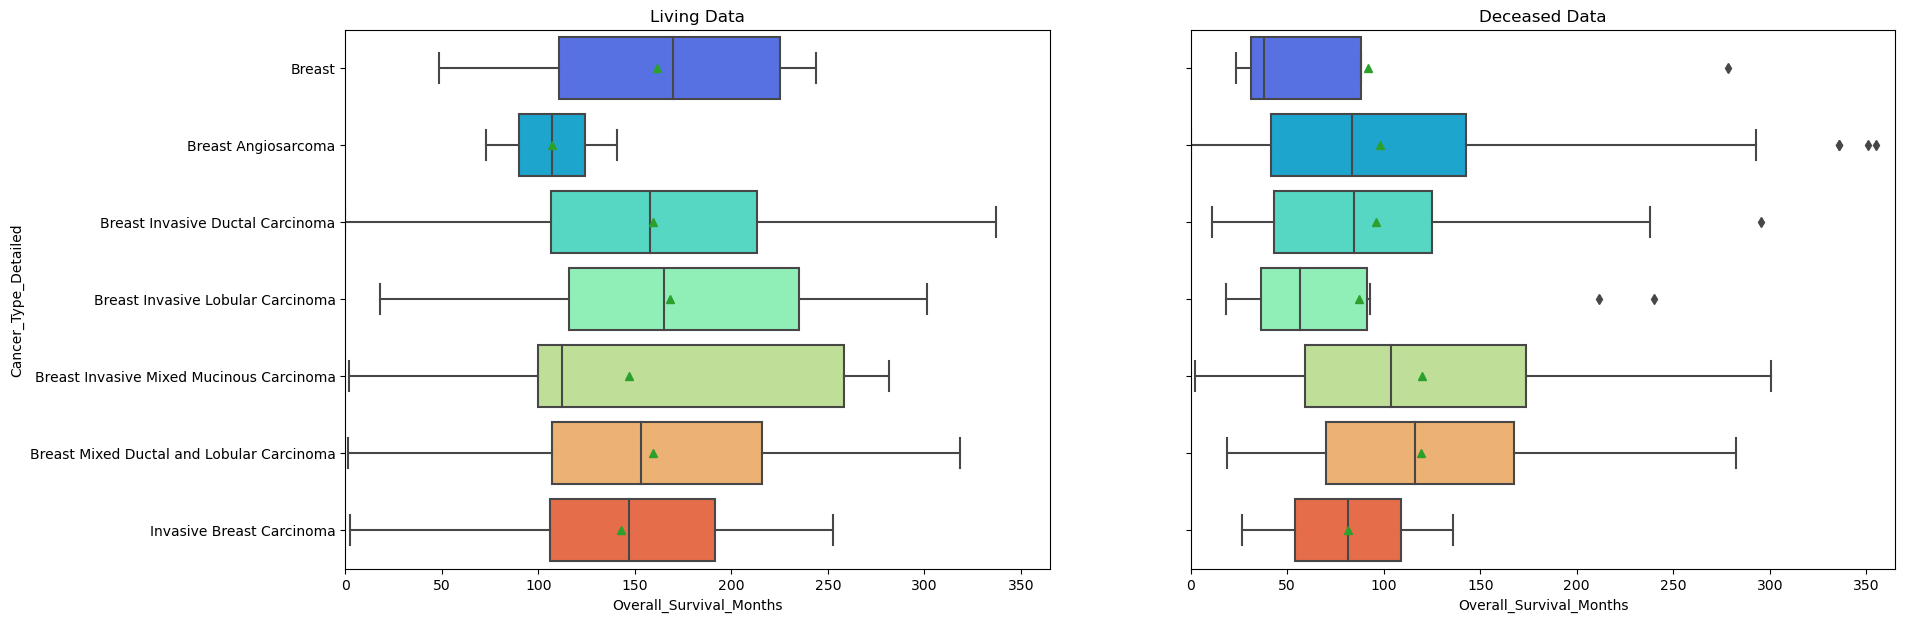

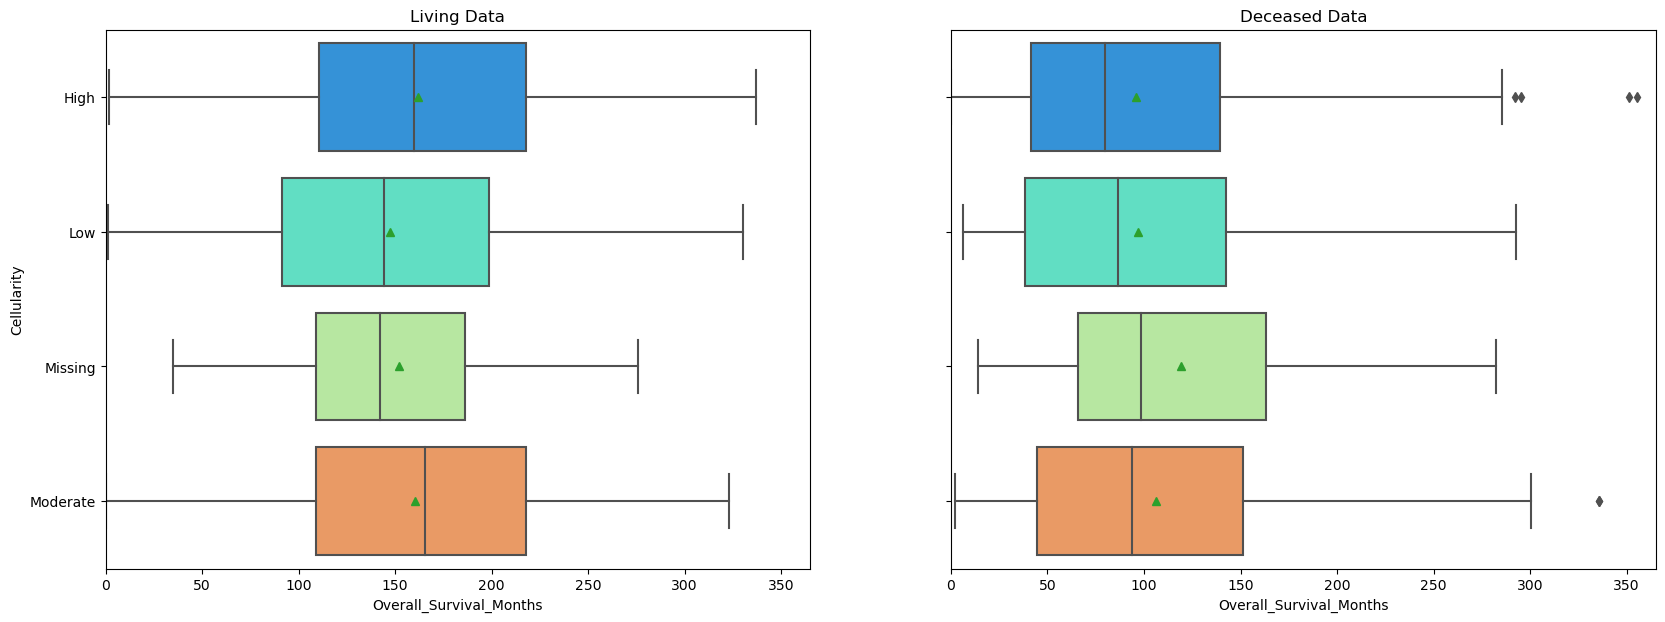

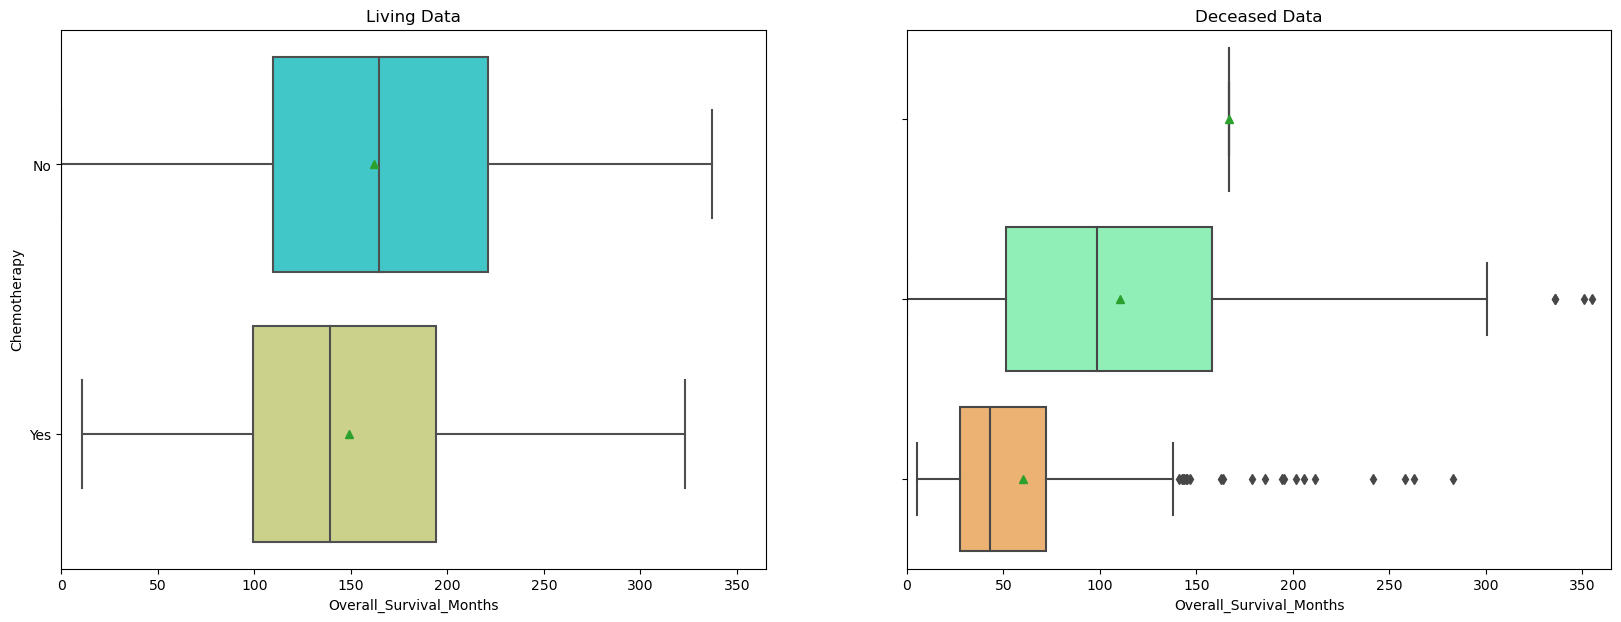

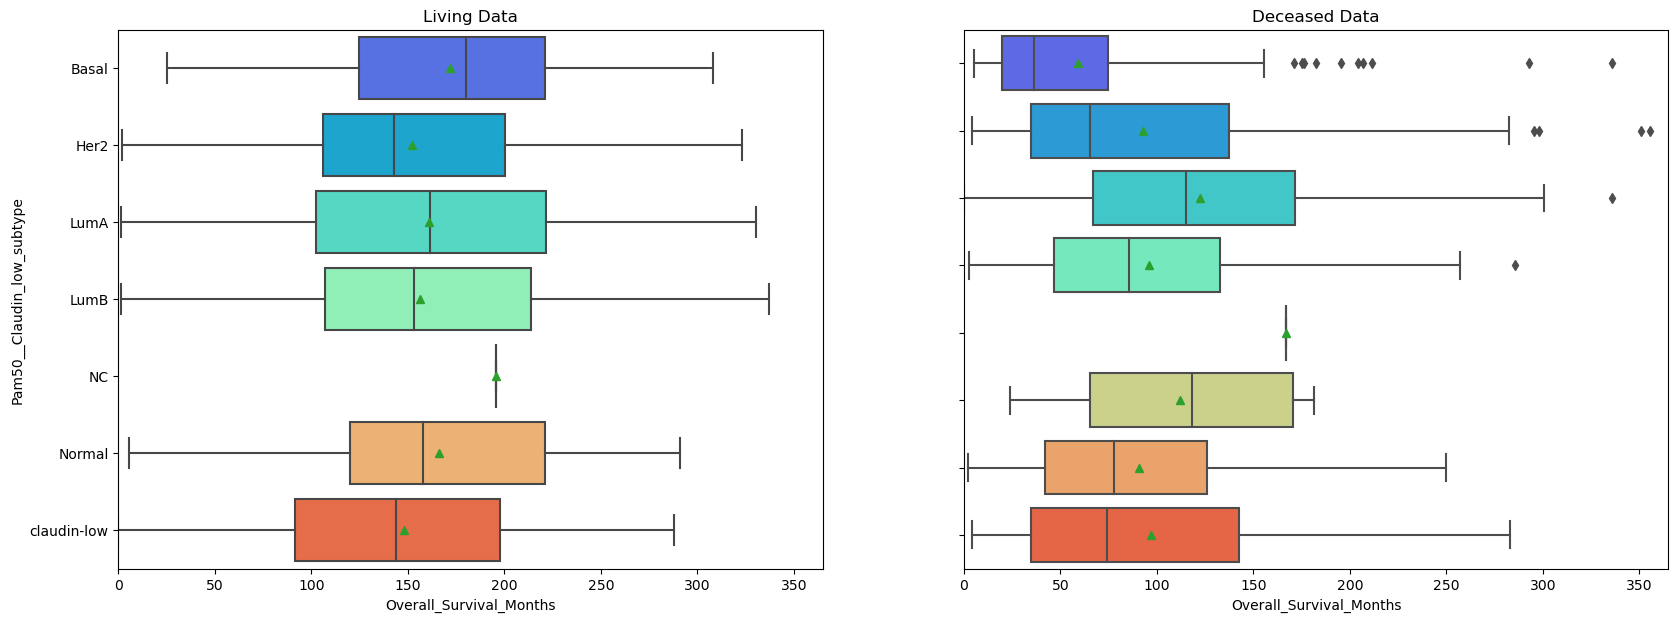

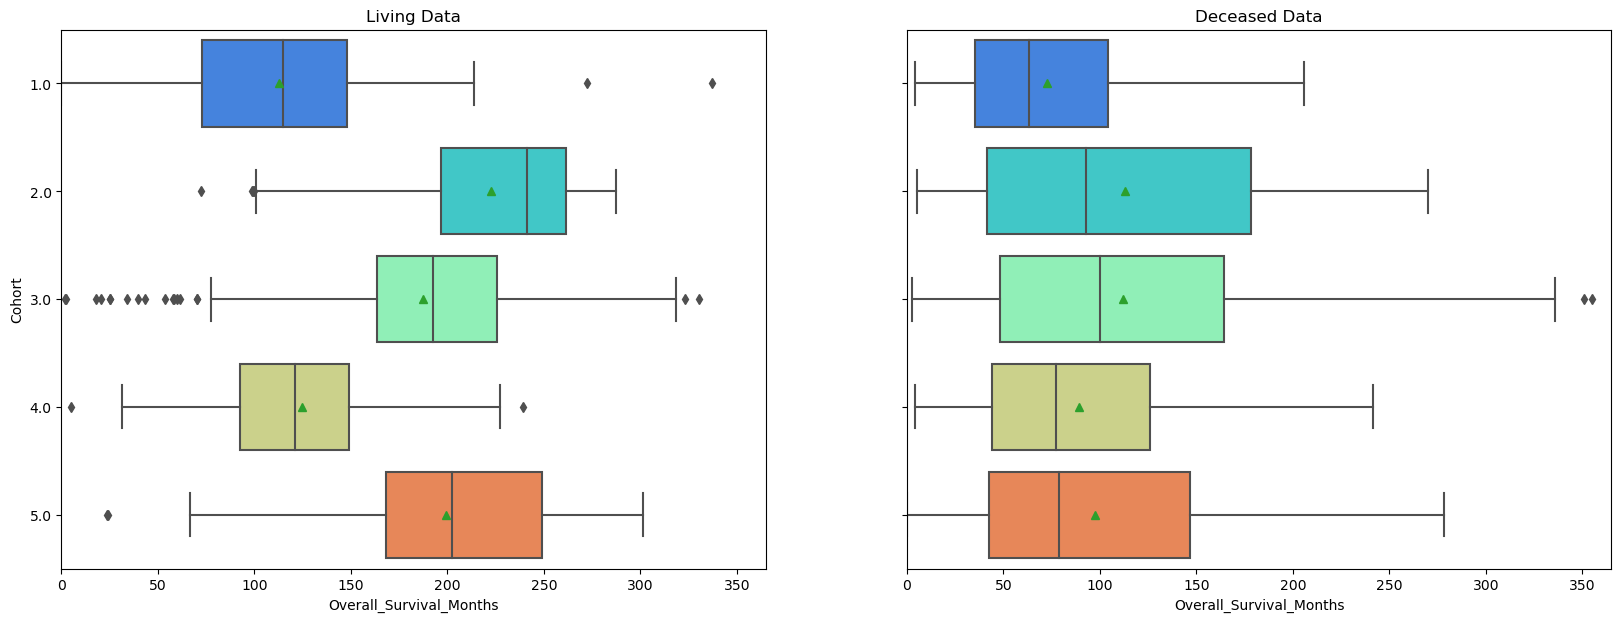

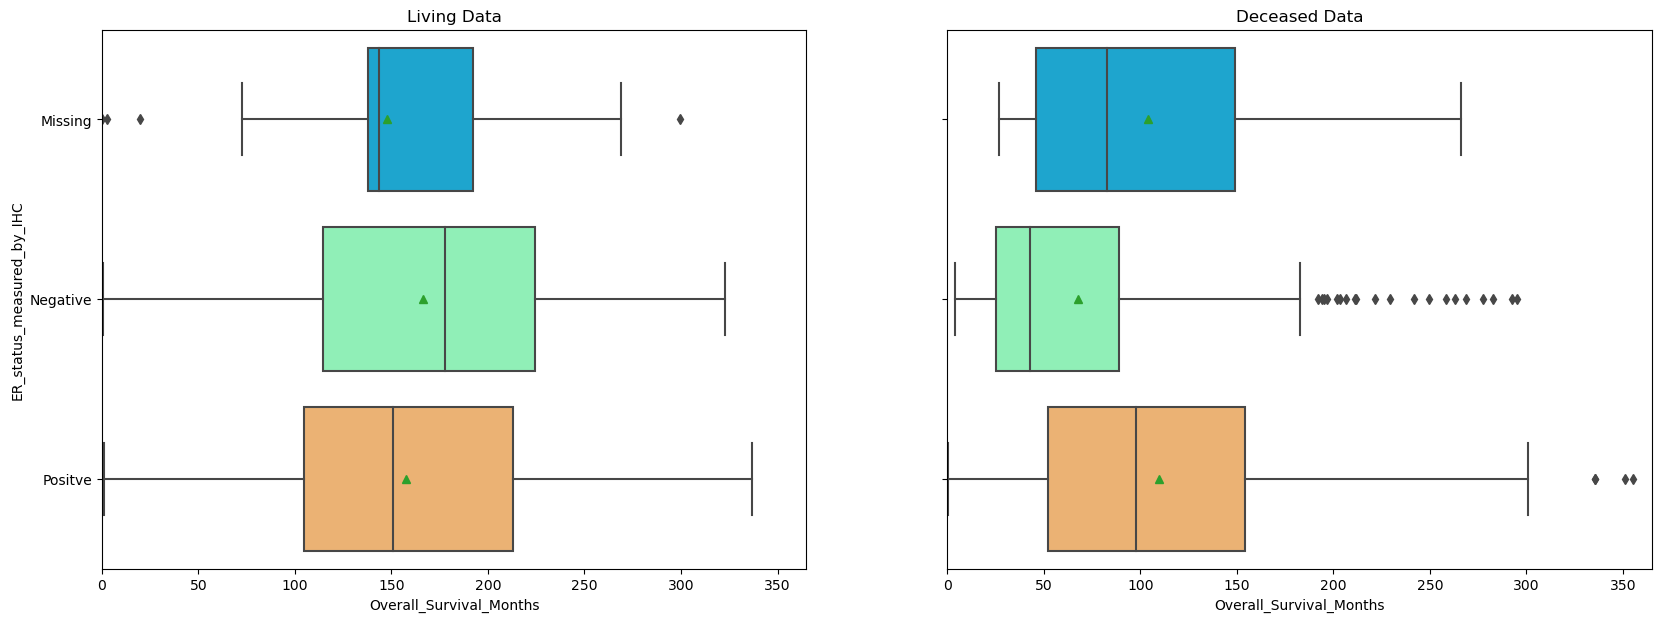

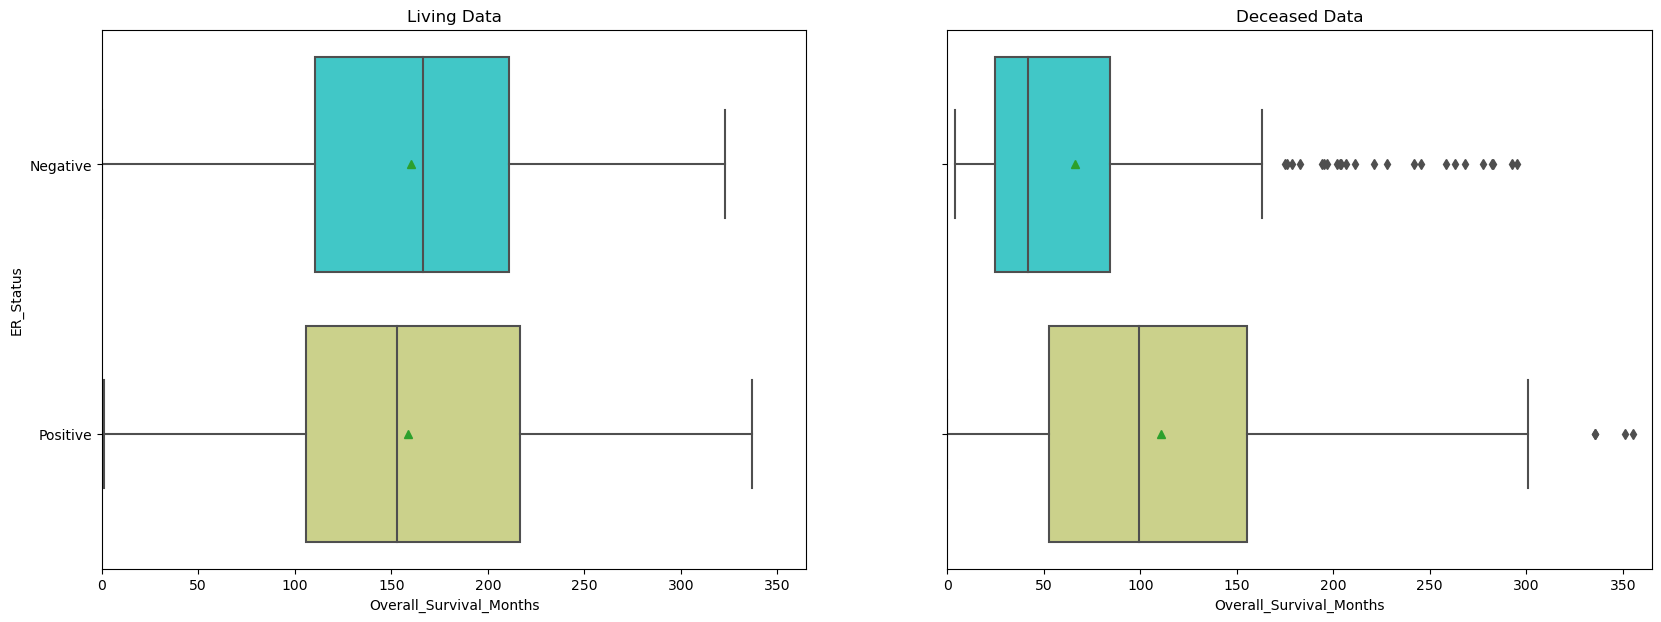

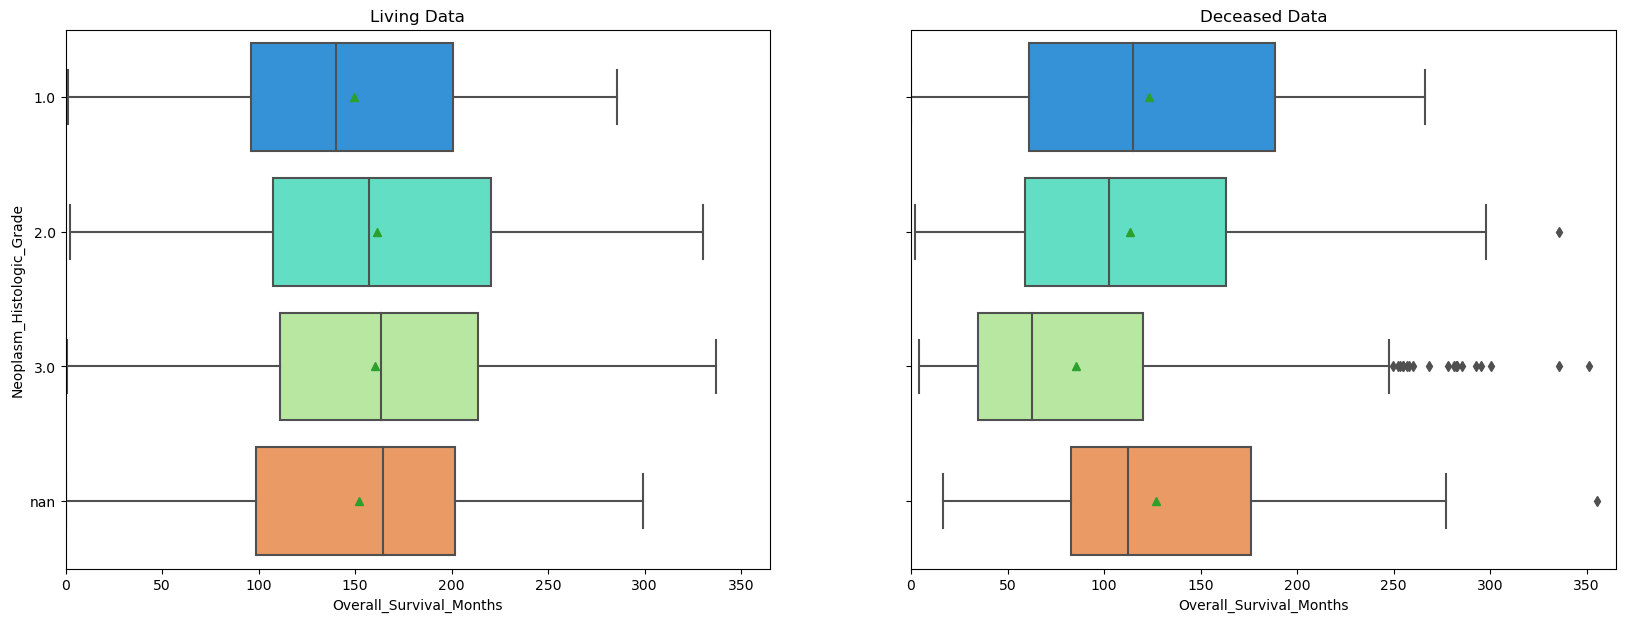

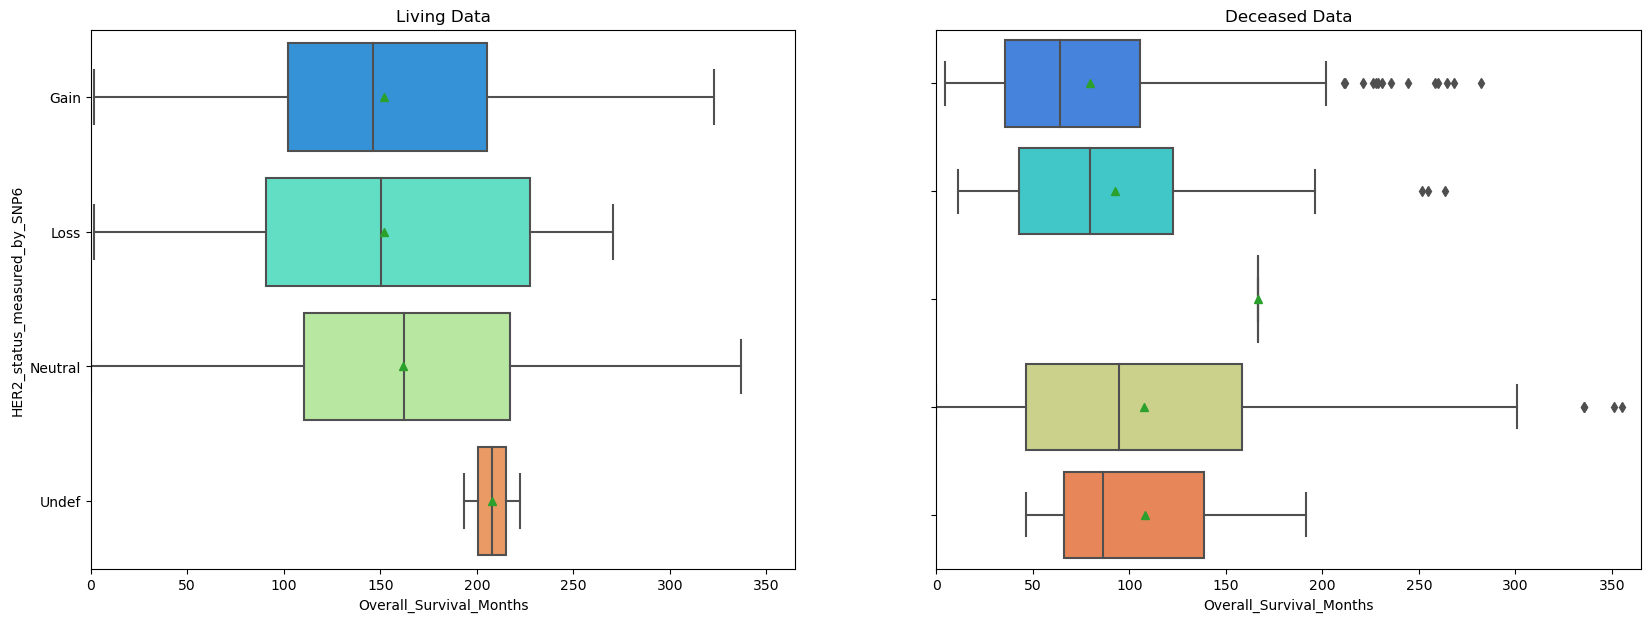

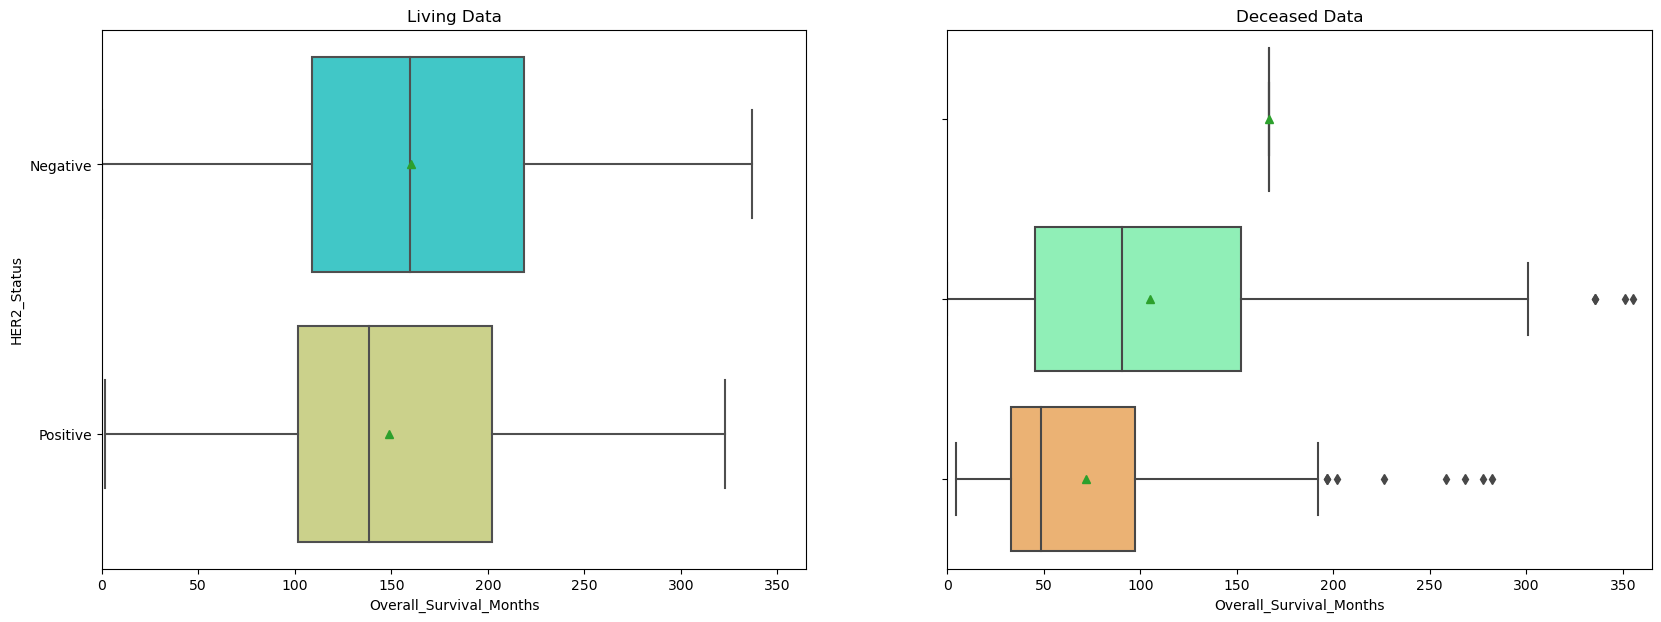

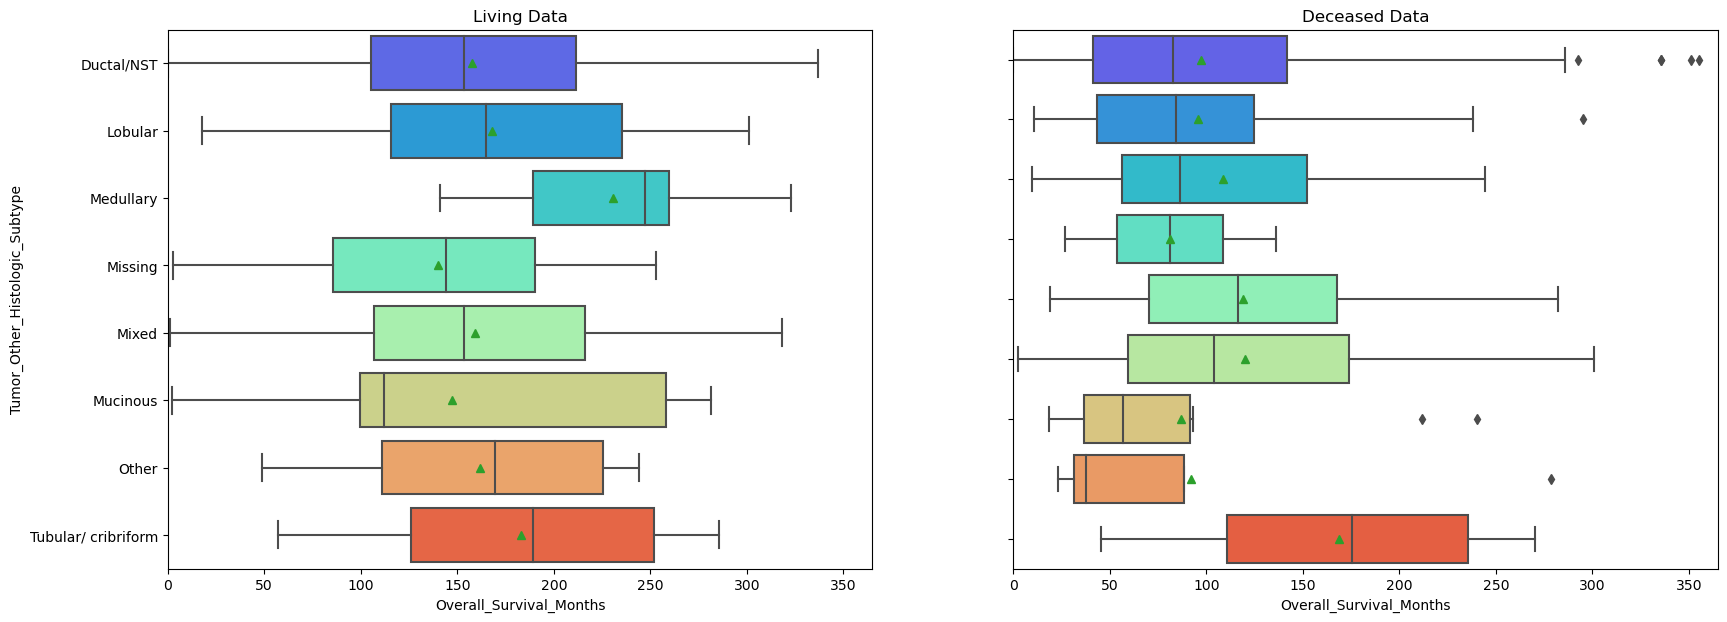

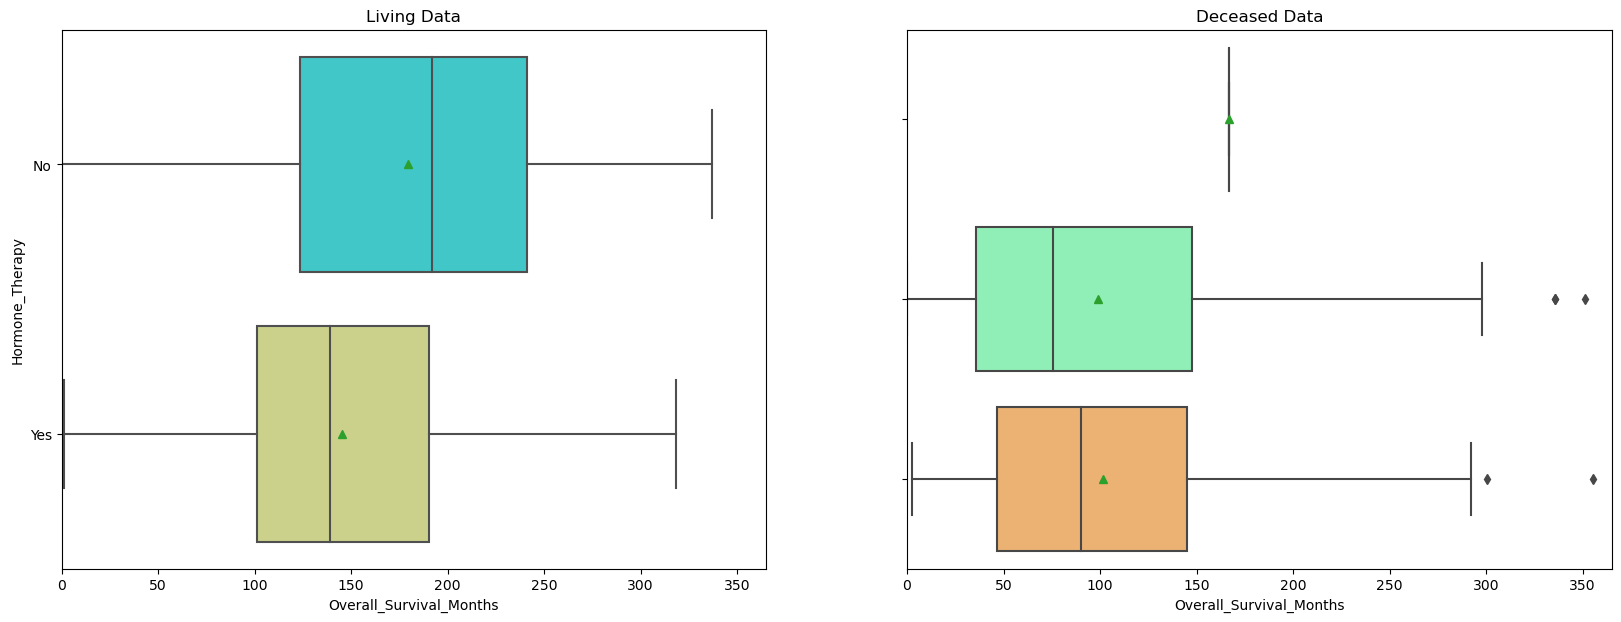

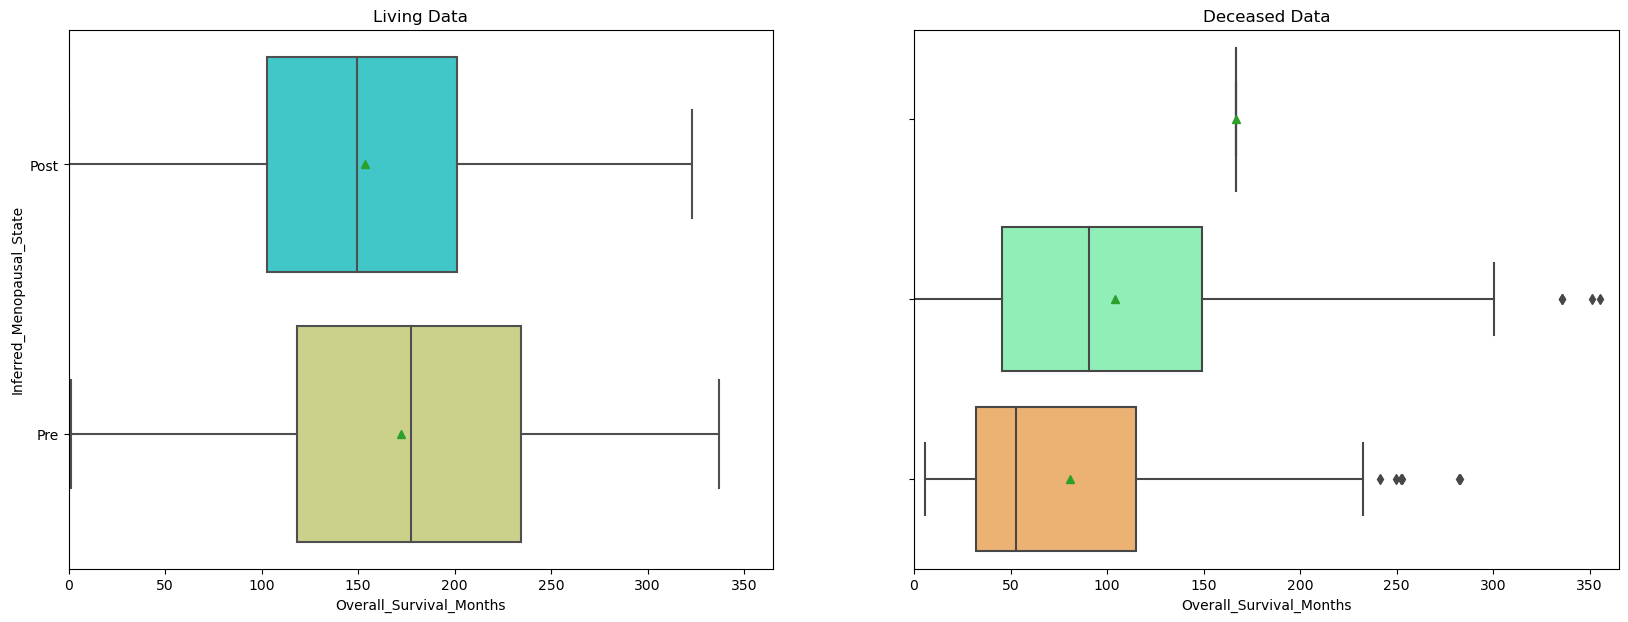

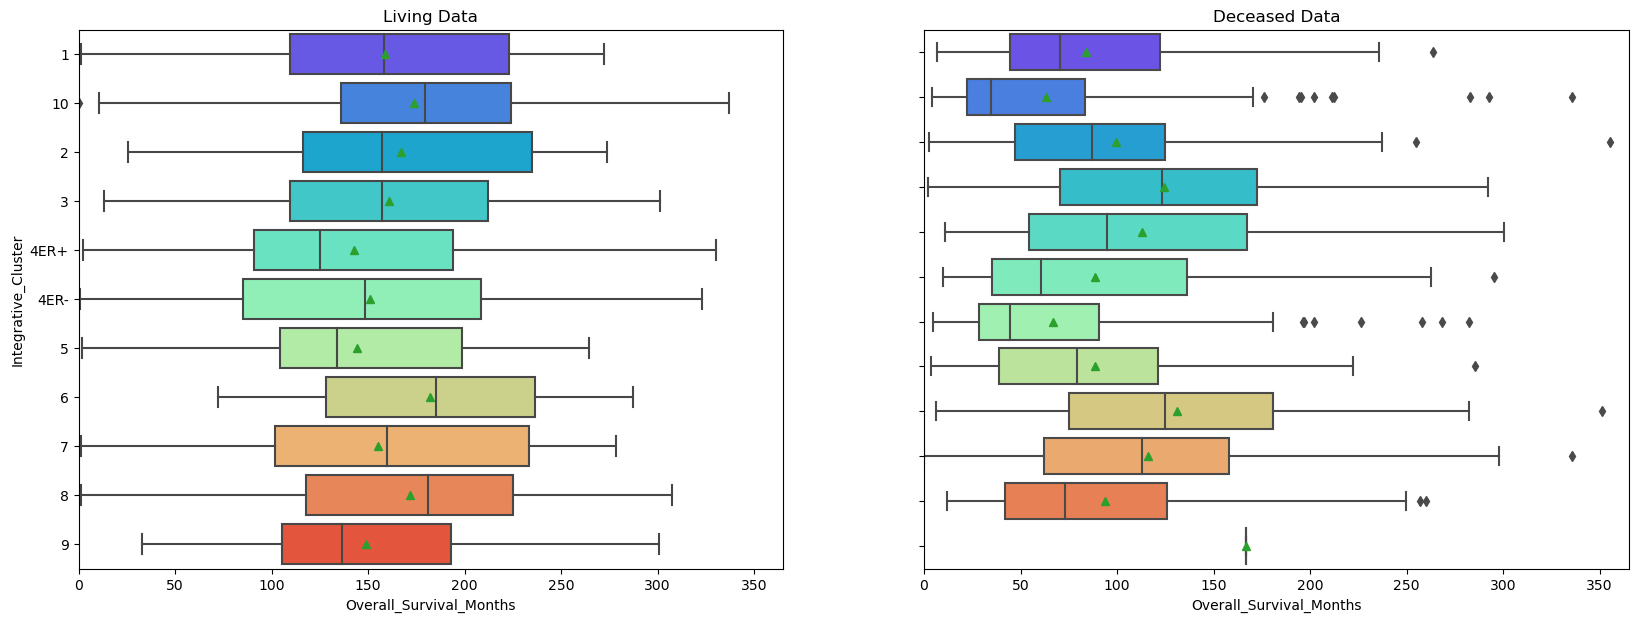

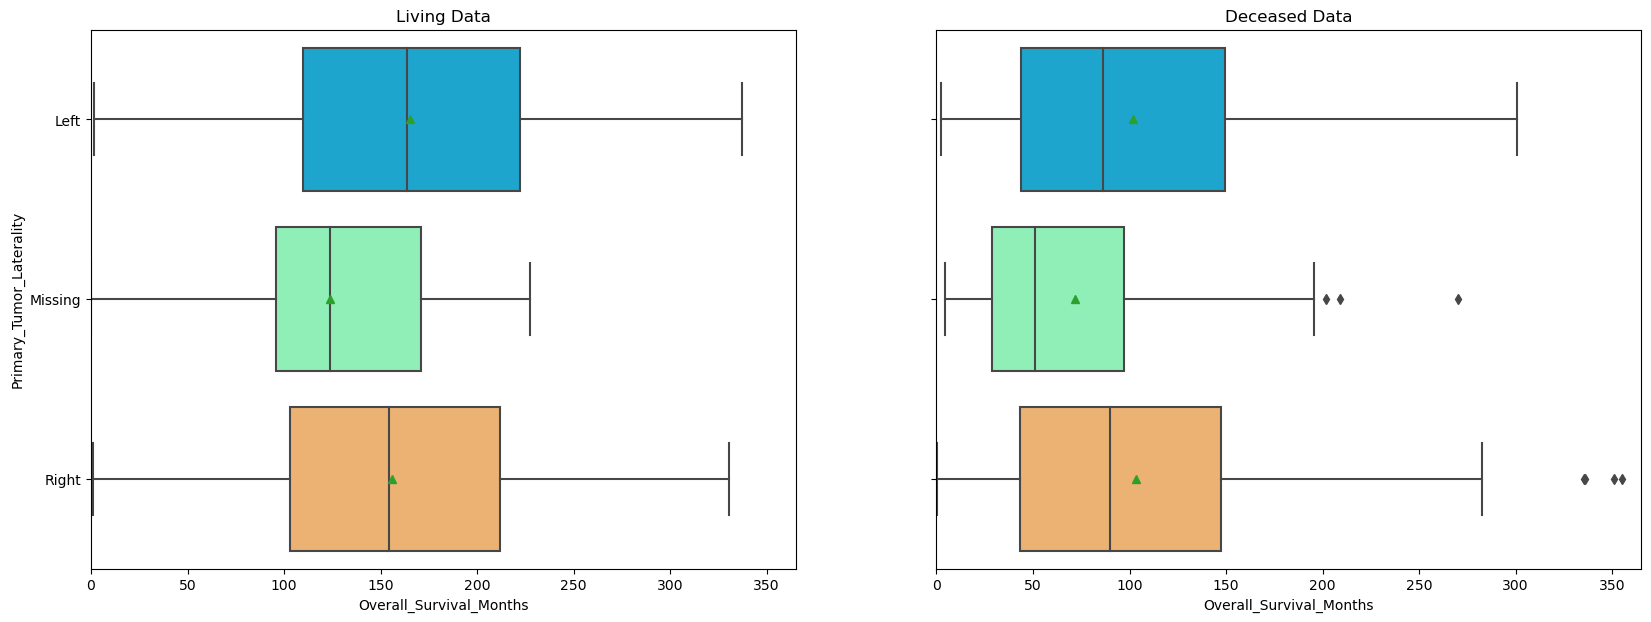

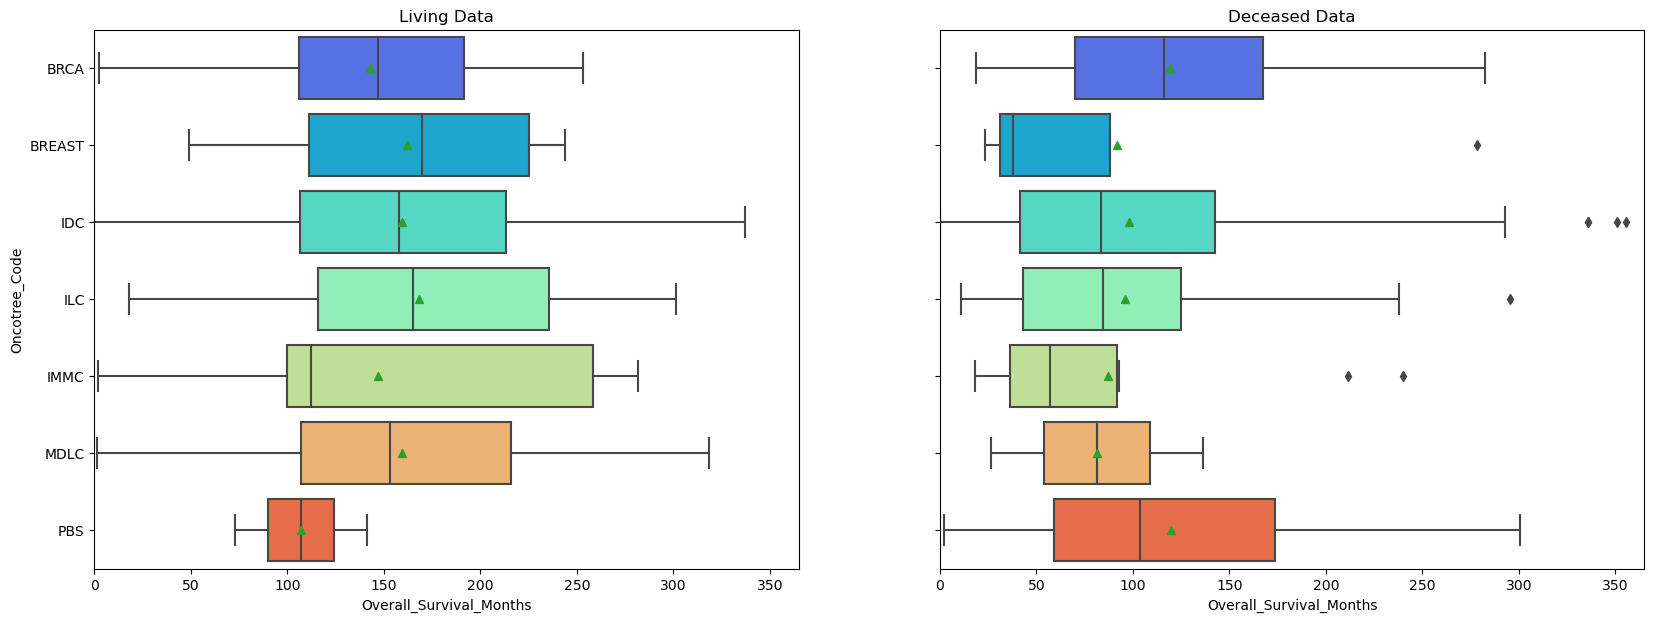

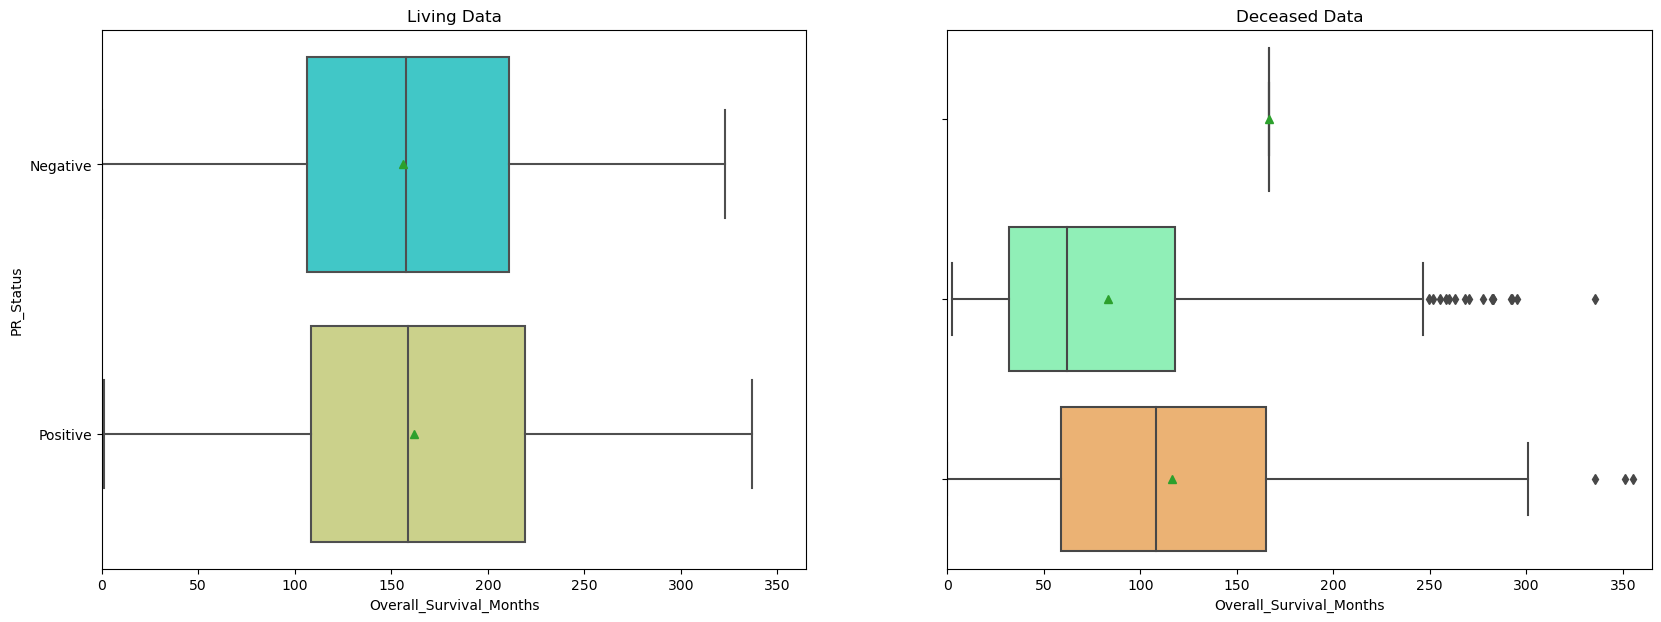

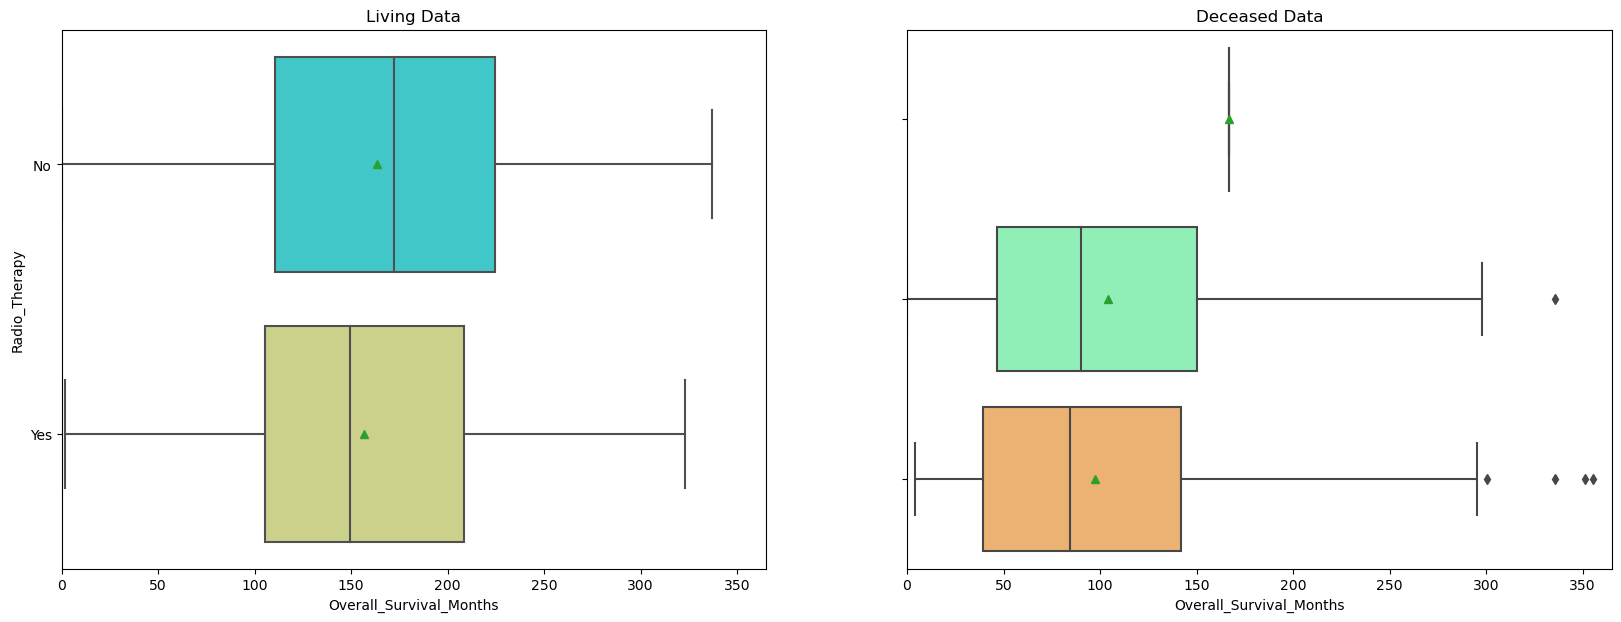

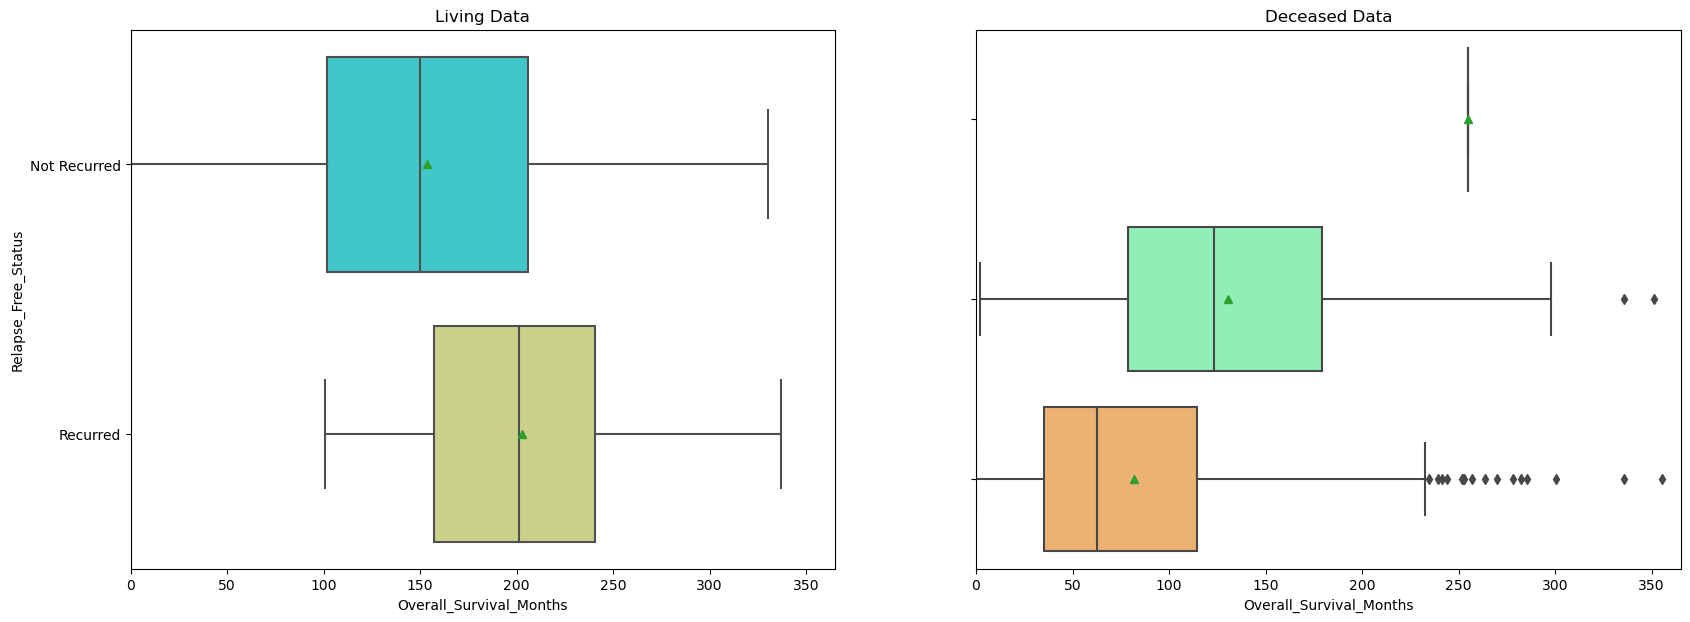

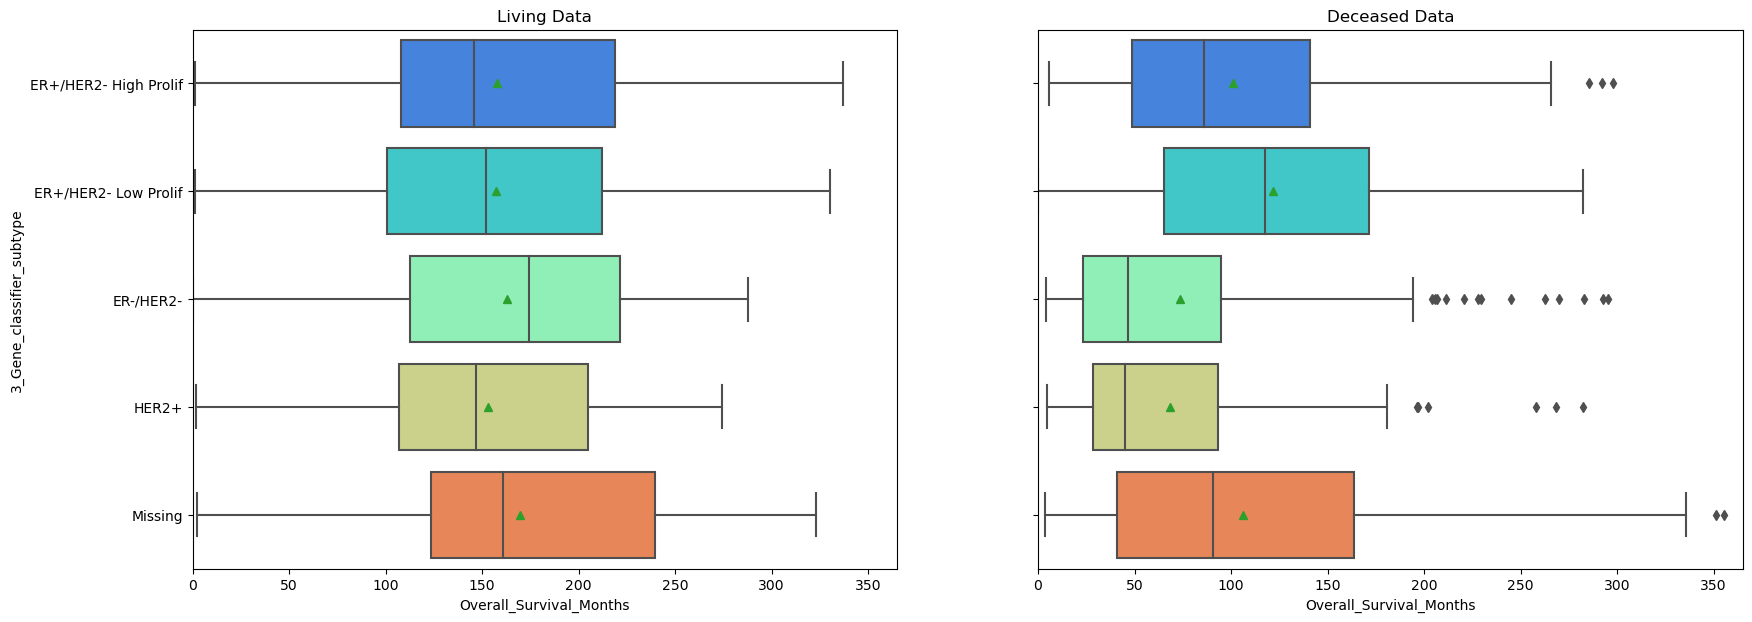

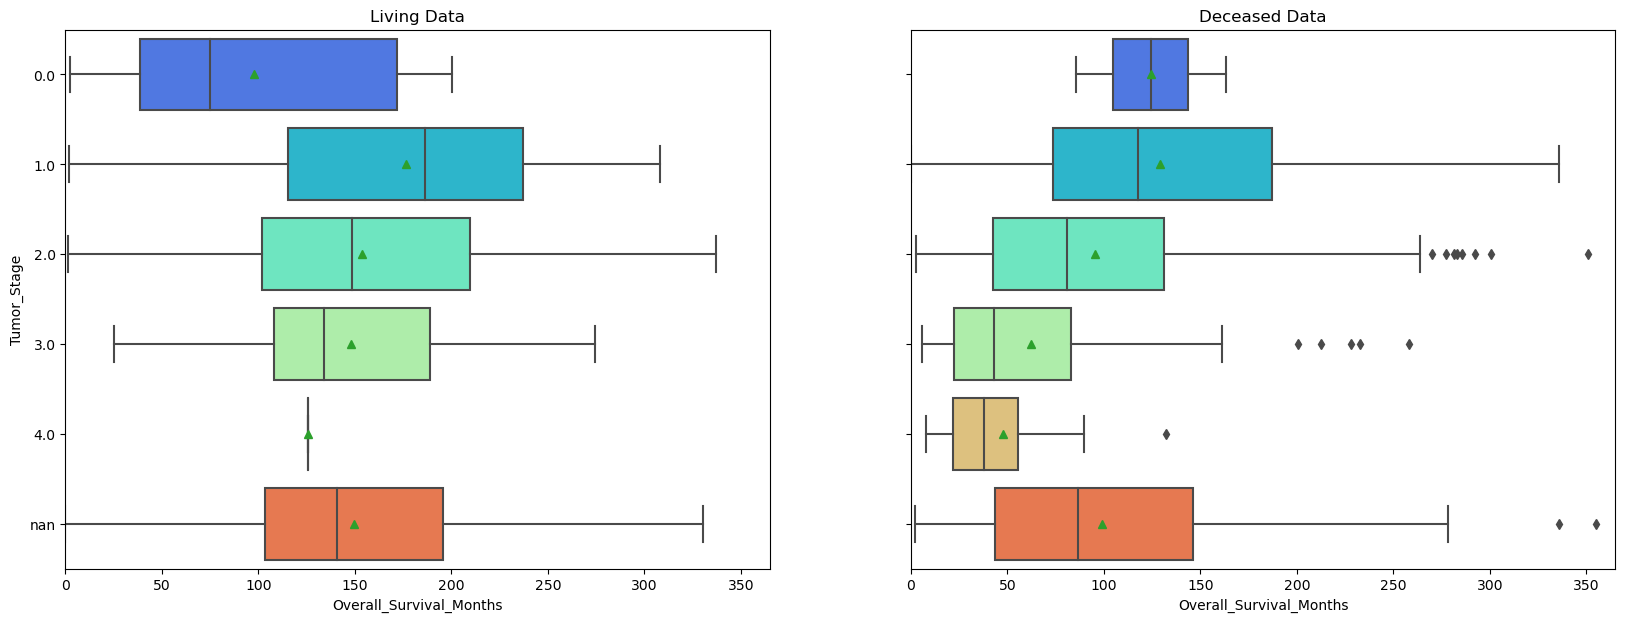

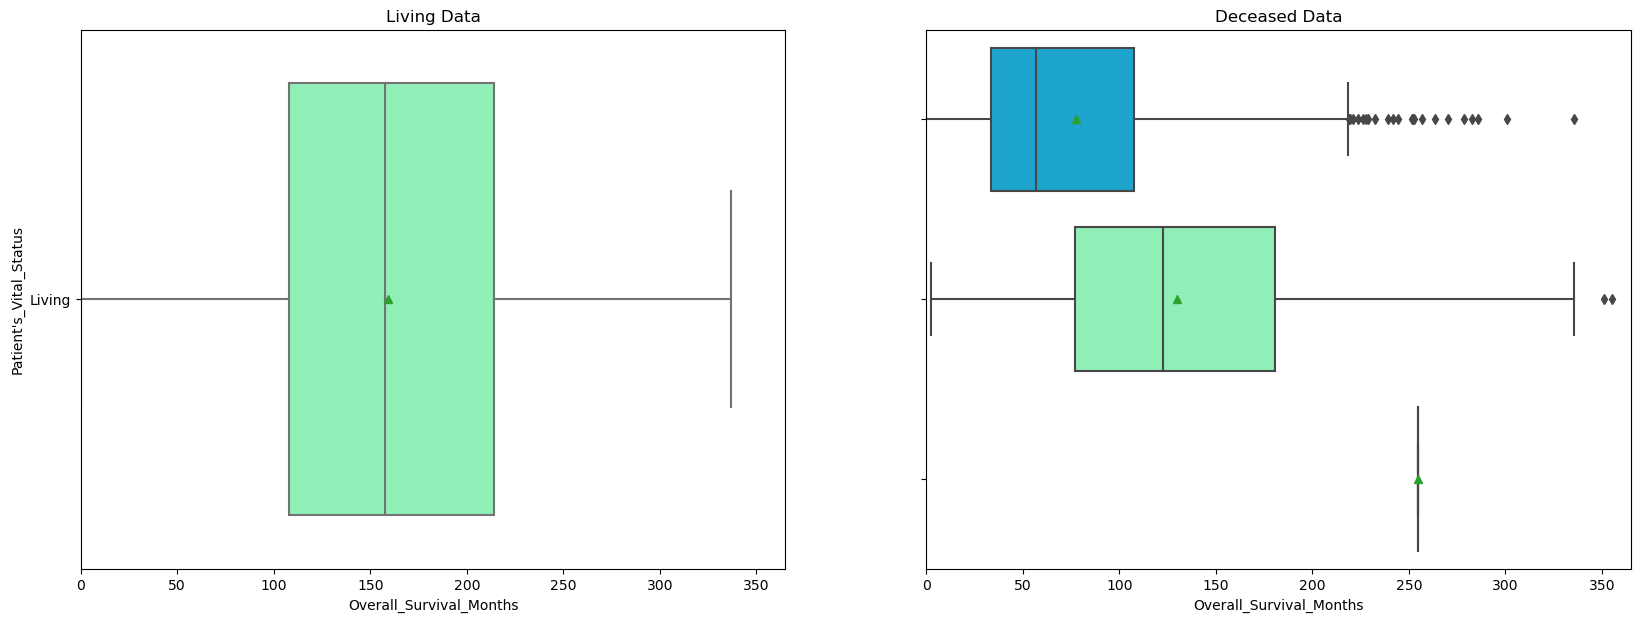

In [20]:
for name in cat_cols:
    boxplot_compare('Overall_Survival_Status', name, "Overall_Survival_Months")   

### Categorial data

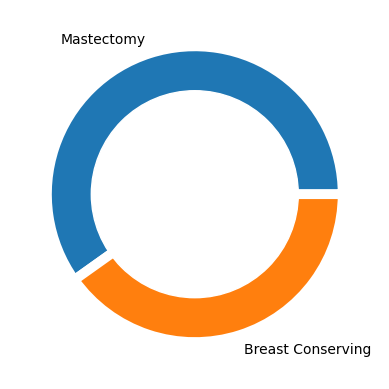

In [21]:
pie_chat('Type_of_Breast_Surgery')

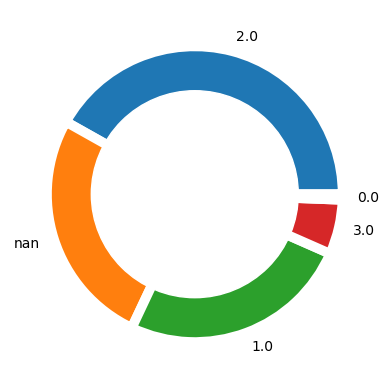

In [22]:
pie_chat('Tumor_Stage')

### Survival analysis

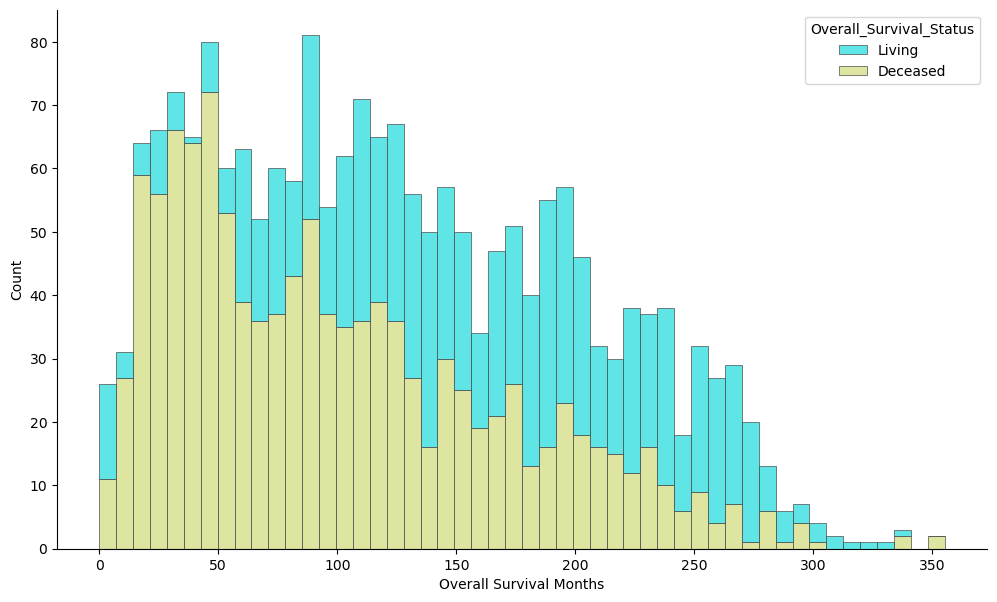

In [23]:
f, ax = plt.subplots(figsize=(12,7))
sns.despine(f)

sns.histplot(
    df,
    x="Overall_Survival_Months", hue="Overall_Survival_Status",
    multiple="stack",
    palette="rainbow",
    edgecolor=".3",
    linewidth=.5,
    log_scale=False,
    bins = 50
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())

plt.xlabel("Overall Survival Months")
plt.show();

In [154]:
T = df["Overall_Survival_Months"]
E = df["Overall_Survival_Status_n"]

#### Kaplan-Maier Curve Estimation (Non-Parametric)

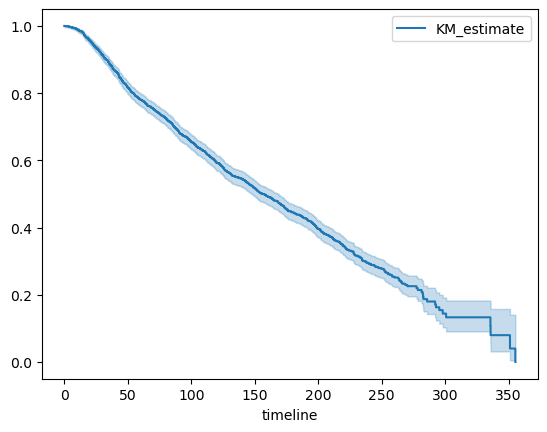

In [155]:
kmf = KaplanMeierFitter()
kmf.fit(durations = T, event_observed = E)
kmf.plot_survival_function()
plt.show()

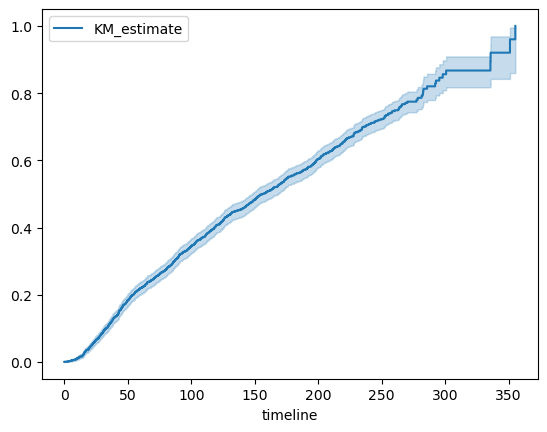

In [156]:
kmf.plot_cumulative_density()
plt.show()

#### Median Survival Time and Confidence Intervals

In [157]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print("Median survival time (months)", median_)
print(median_confidence_interval_)

Median survival time (months) 156.33333330000002
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5              147.833333              168.266667


#### KM Plot for Gender/Sex Categories

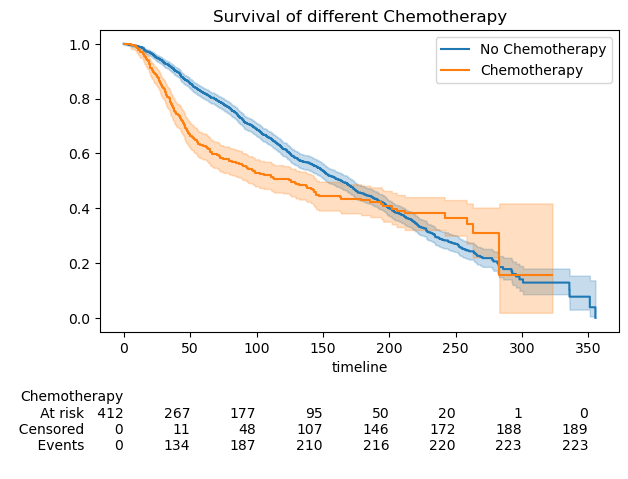

In [161]:
ax = plt.subplot(111)

m = (df["Chemotherapy_n"] == 0)

kmf.fit(durations = T[m], event_observed = E[m], label = "No Chemotherapy")
kmf.plot_survival_function(ax = ax)

kmf.fit(T[~m], event_observed = E[~m], label = "Chemotherapy")
kmf.plot_survival_function(ax = ax, at_risk_counts = True)

plt.title("Survival of different Chemotherapy")
plt.show()

In [164]:
f = 'Pam50__Claudin_low_subtype'
print( df[f].unique() )
df[f].value_counts()

['claudin-low' 'LumA' 'LumB' 'Normal' 'Her2' 'Basal' 'NC' 'Missing']


Pam50__Claudin_low_subtype
LumA           700
LumB           475
Her2           224
claudin-low    218
Basal          209
Normal         148
NC               6
Missing          1
Name: count, dtype: int64

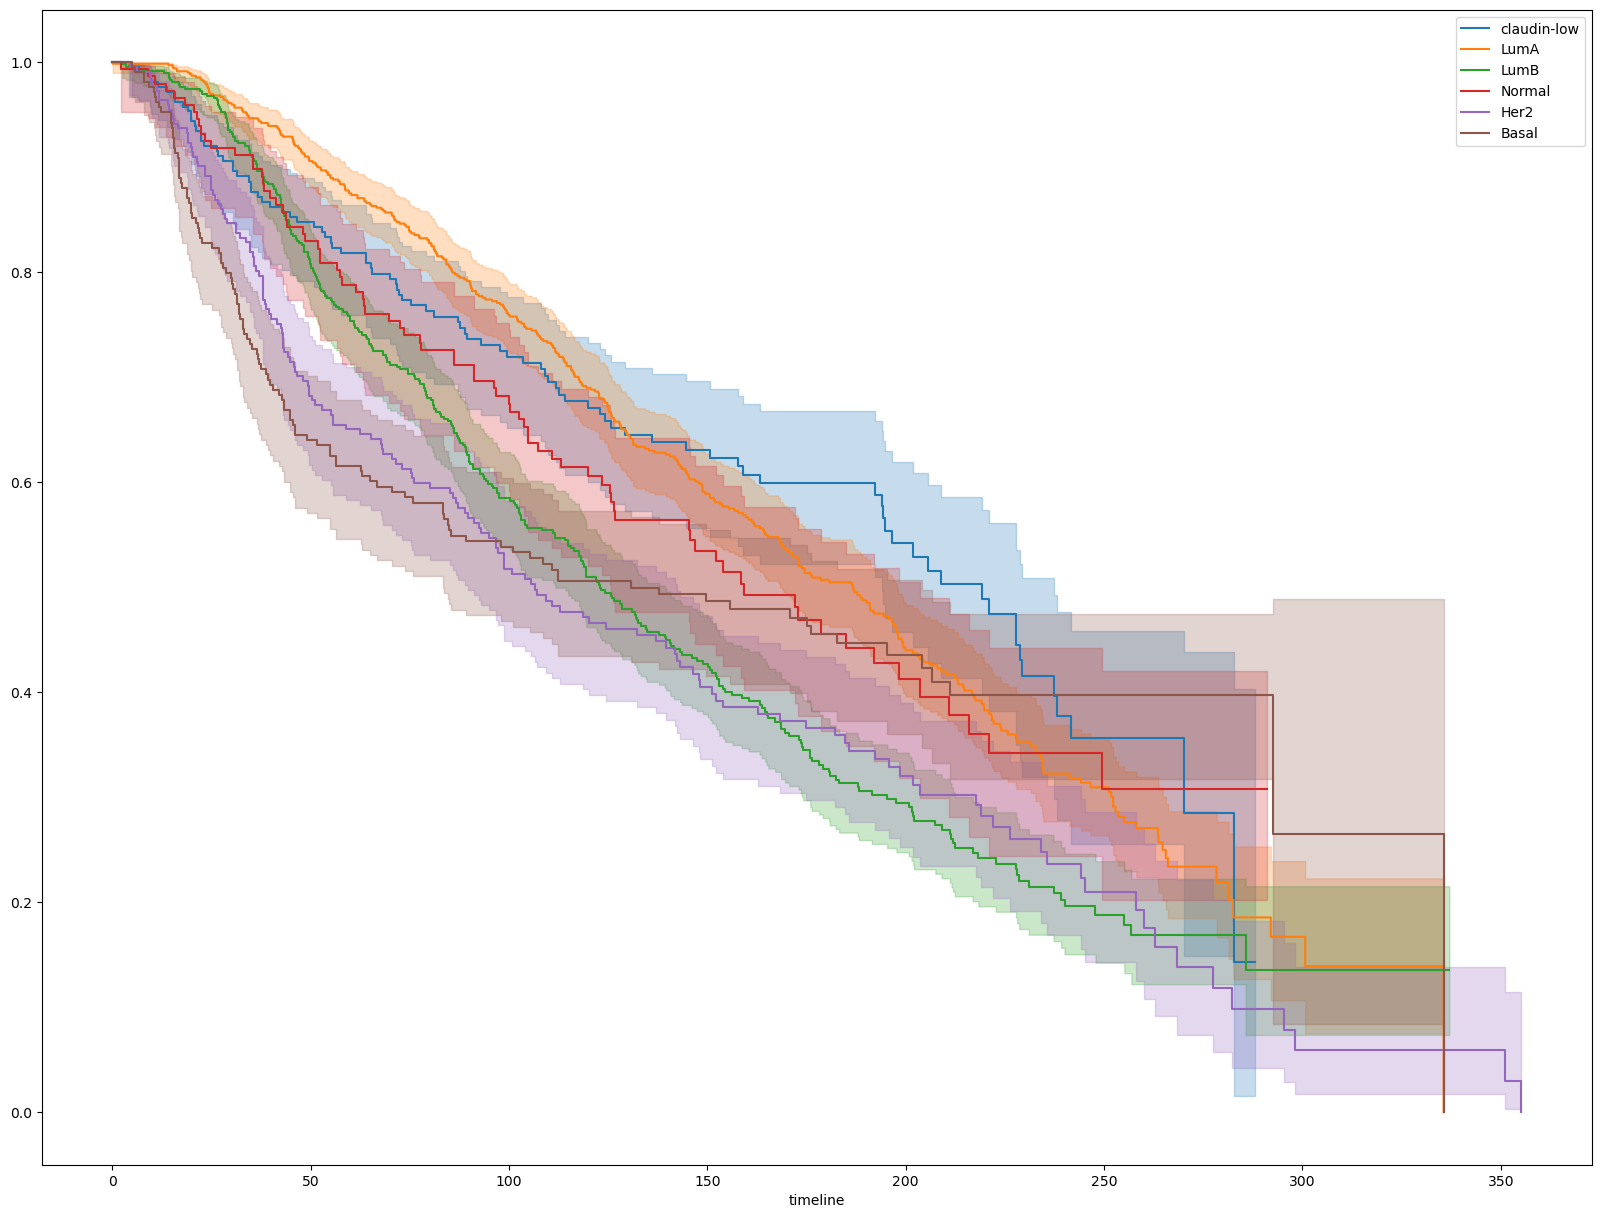

In [167]:
plt.figure(figsize = (20,15))
for v in ['claudin-low', 'LumA', 'LumB', 'Normal', 'Her2', 'Basal']:
    m = df[f] == v
    T = df['Overall_Survival_Months'][m] 
    E = df['Overall_Survival_Status_n'][m]
    kmf = KaplanMeierFitter(label=v)
    kmf.fit(T,E)
    kmf.plot()

In [162]:
cat_cols = list(df.select_dtypes(include=['object']))
cat_cols.remove('Patient_ID')
cat_cols.remove('Cancer_Type')
cat_cols.remove('Overall_Survival_Status')
print(cat_cols)

['Type_of_Breast_Surgery', 'Cancer_Type_Detailed', 'Cellularity', 'Chemotherapy', 'Pam50__Claudin_low_subtype', 'Cohort', 'ER_status_measured_by_IHC', 'ER_Status', 'Neoplasm_Histologic_Grade', 'HER2_status_measured_by_SNP6', 'HER2_Status', 'Tumor_Other_Histologic_Subtype', 'Hormone_Therapy', 'Inferred_Menopausal_State', 'Integrative_Cluster', 'Primary_Tumor_Laterality', 'Oncotree_Code', 'PR_Status', 'Radio_Therapy', 'Relapse_Free_Status', '3_Gene_classifier_subtype', 'Tumor_Stage', 'Patients_Vital_Status']


Type_of_Breast_Surgery
Cancer_Type_Detailed
Cellularity
Chemotherapy
Pam50__Claudin_low_subtype
Cohort
ER_status_measured_by_IHC
ER_Status
Neoplasm_Histologic_Grade
HER2_status_measured_by_SNP6
HER2_Status
Tumor_Other_Histologic_Subtype
Hormone_Therapy
Inferred_Menopausal_State
Integrative_Cluster
Primary_Tumor_Laterality
Oncotree_Code
PR_Status
Radio_Therapy
Relapse_Free_Status


/var/folders/4t/t1tjs2gd7kzg3jkt5d1snhlh0000gn/T/ipykernel_1305/546573874.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize = (20,5))


3_Gene_classifier_subtype
Tumor_Stage
Patients_Vital_Status


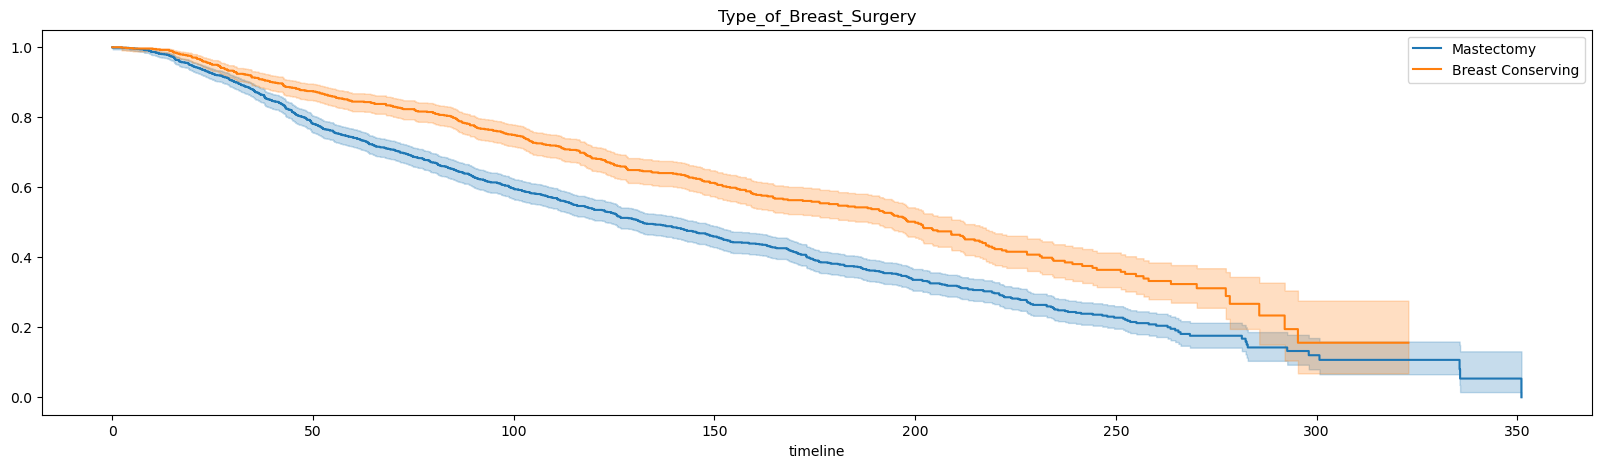

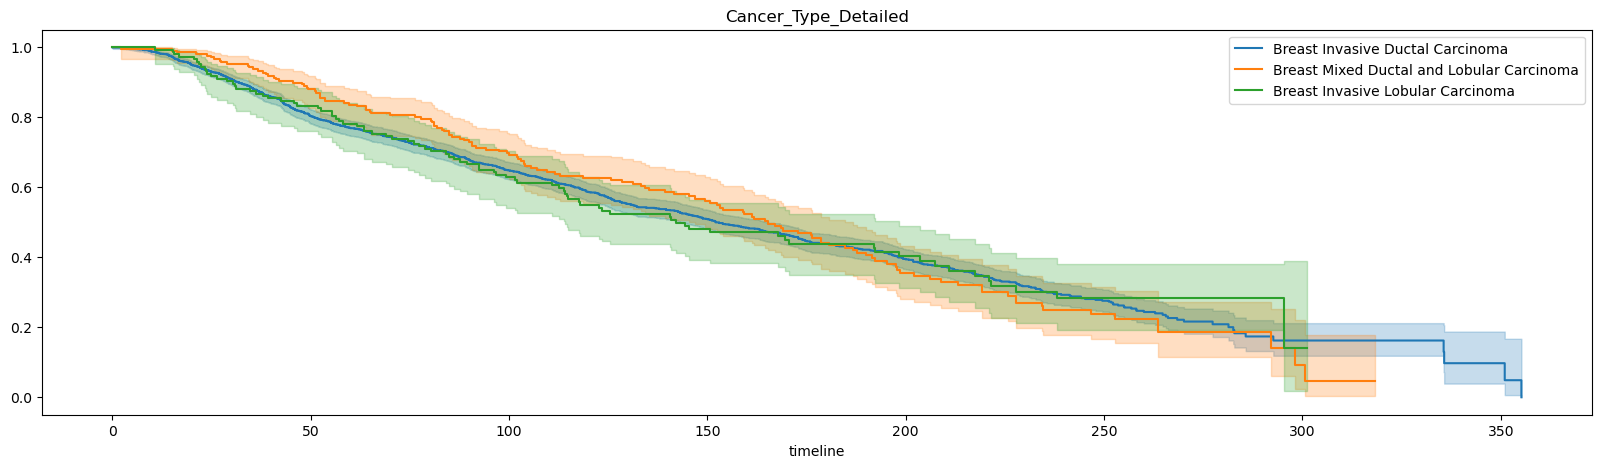

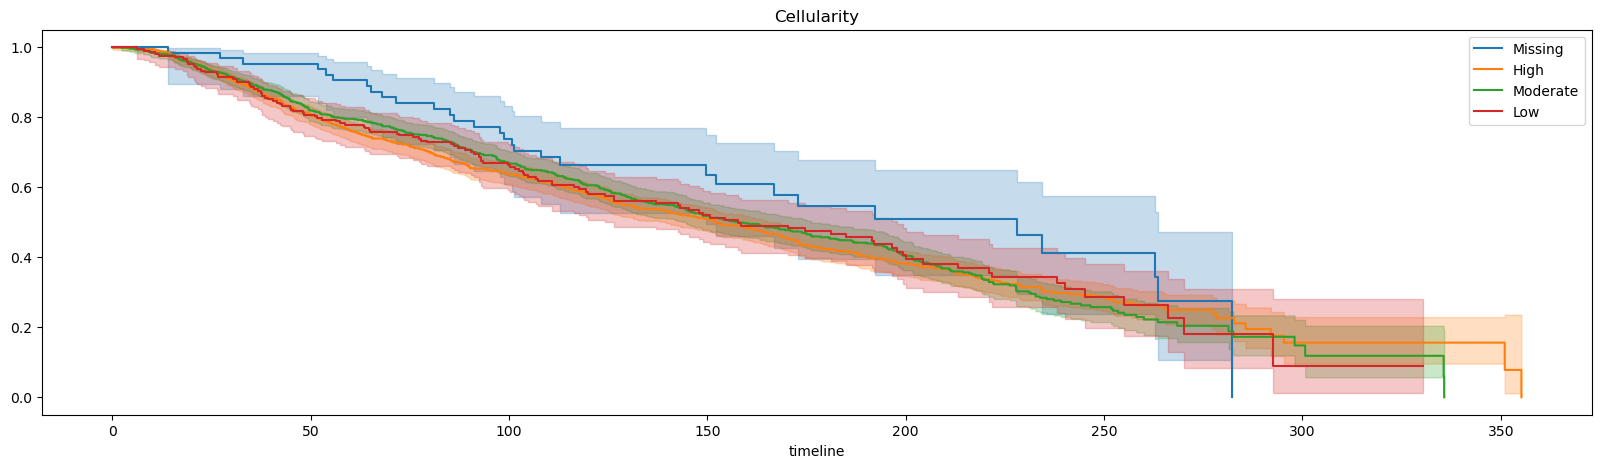

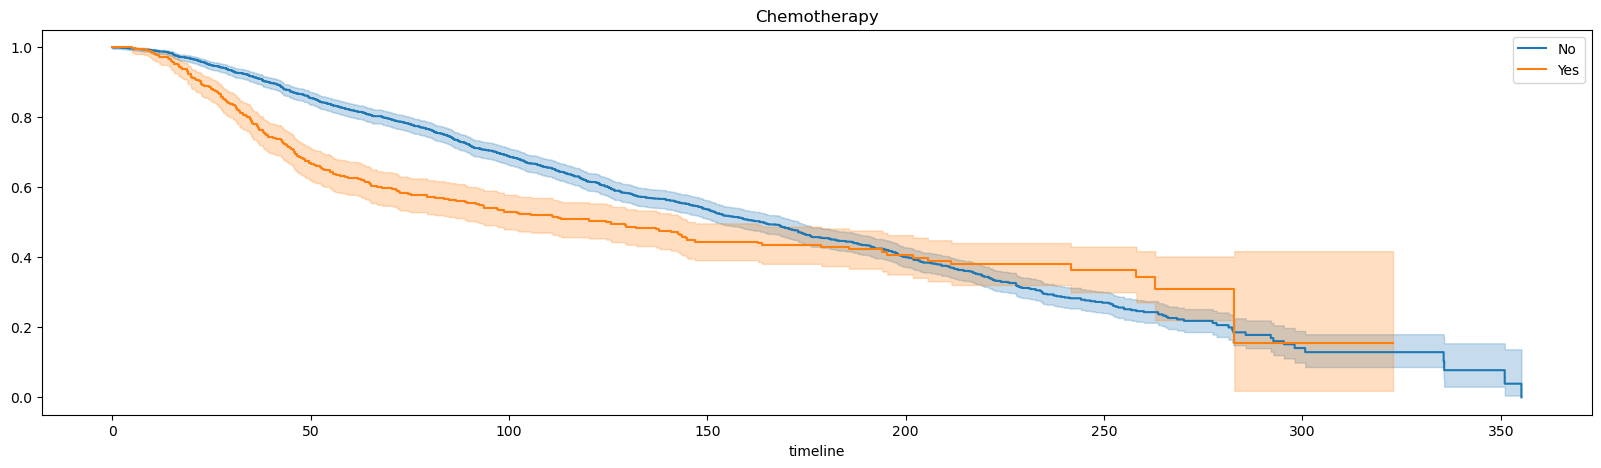

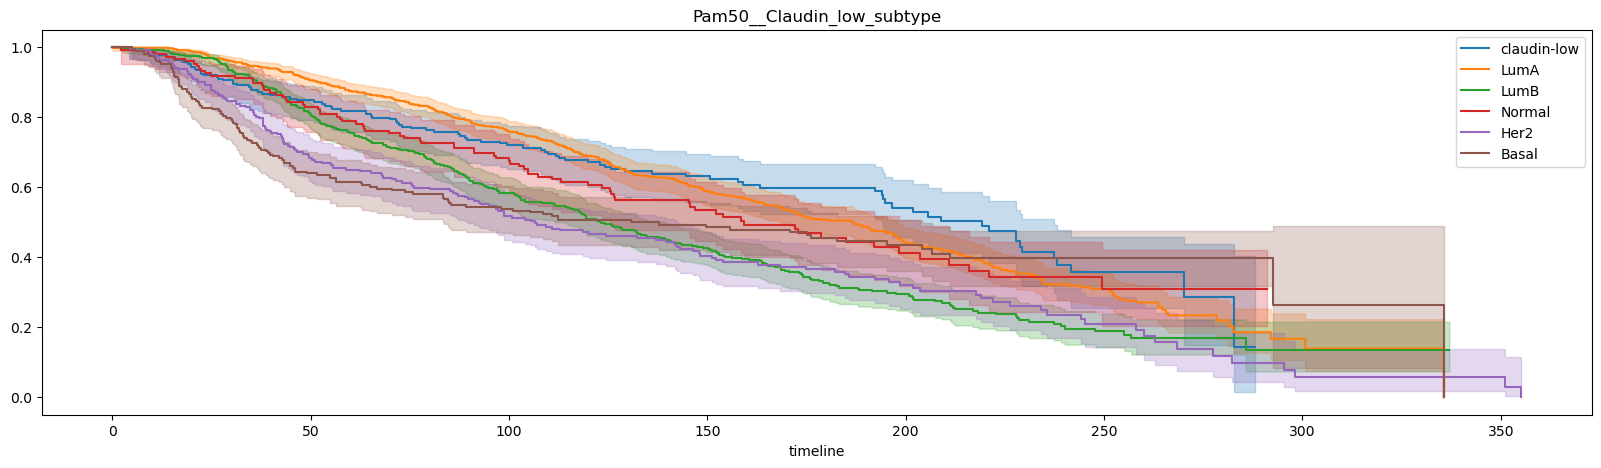

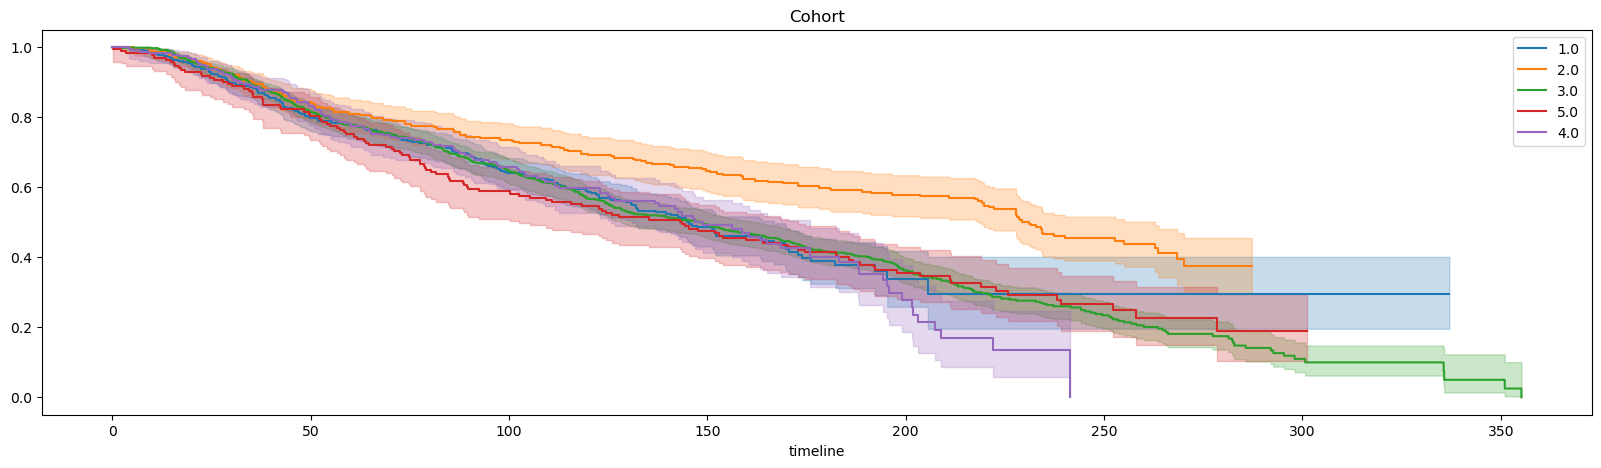

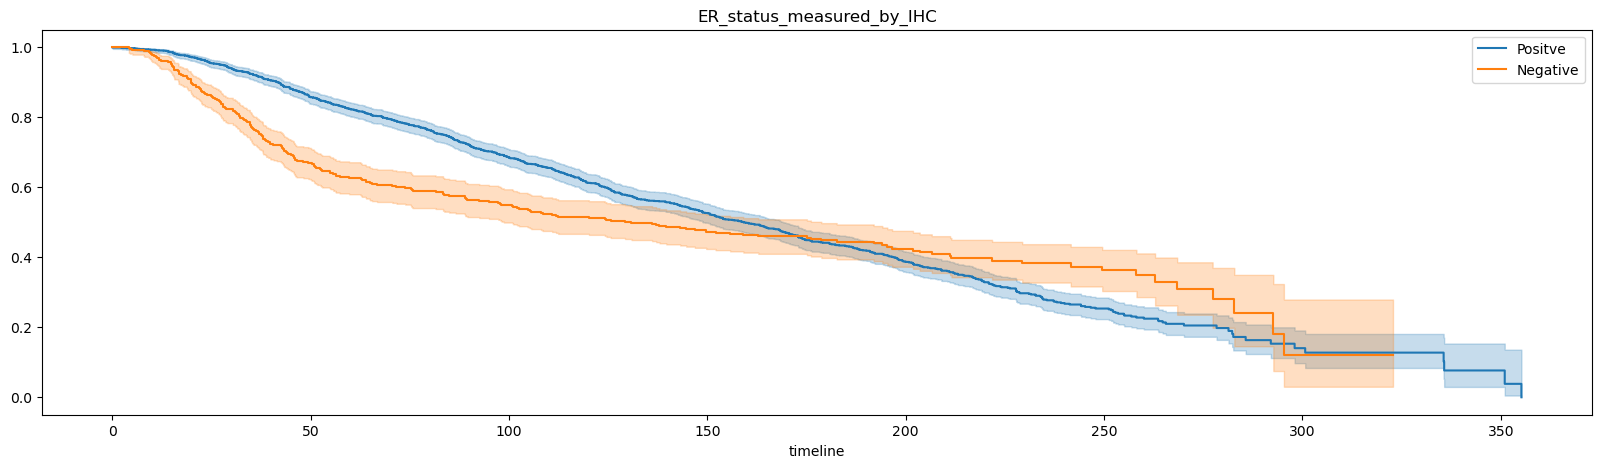

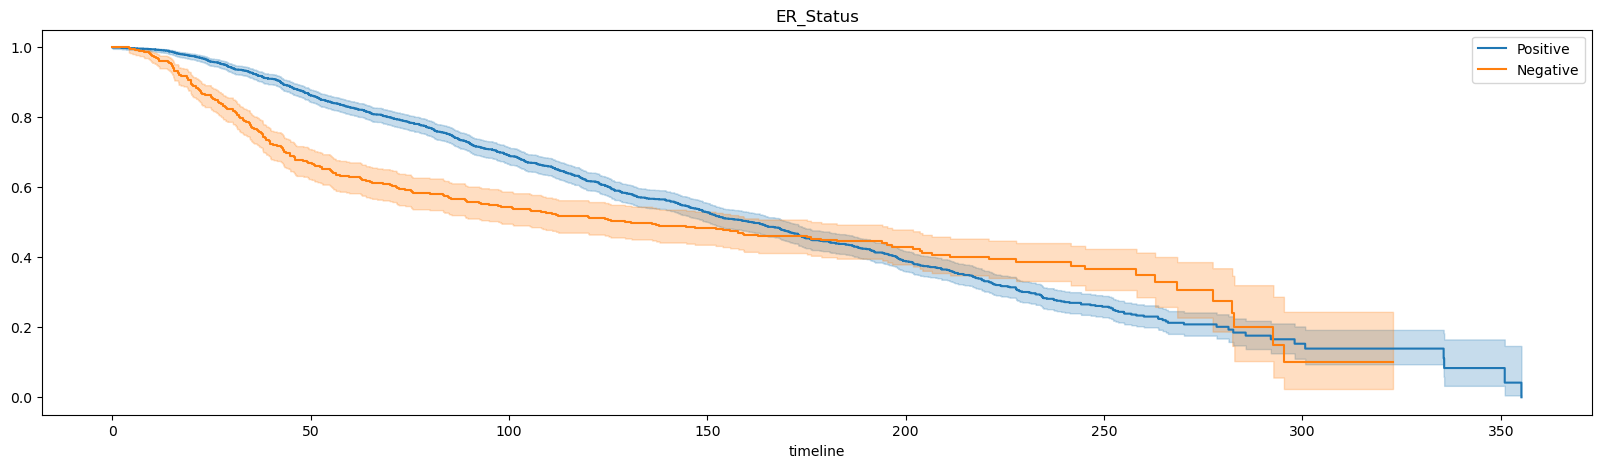

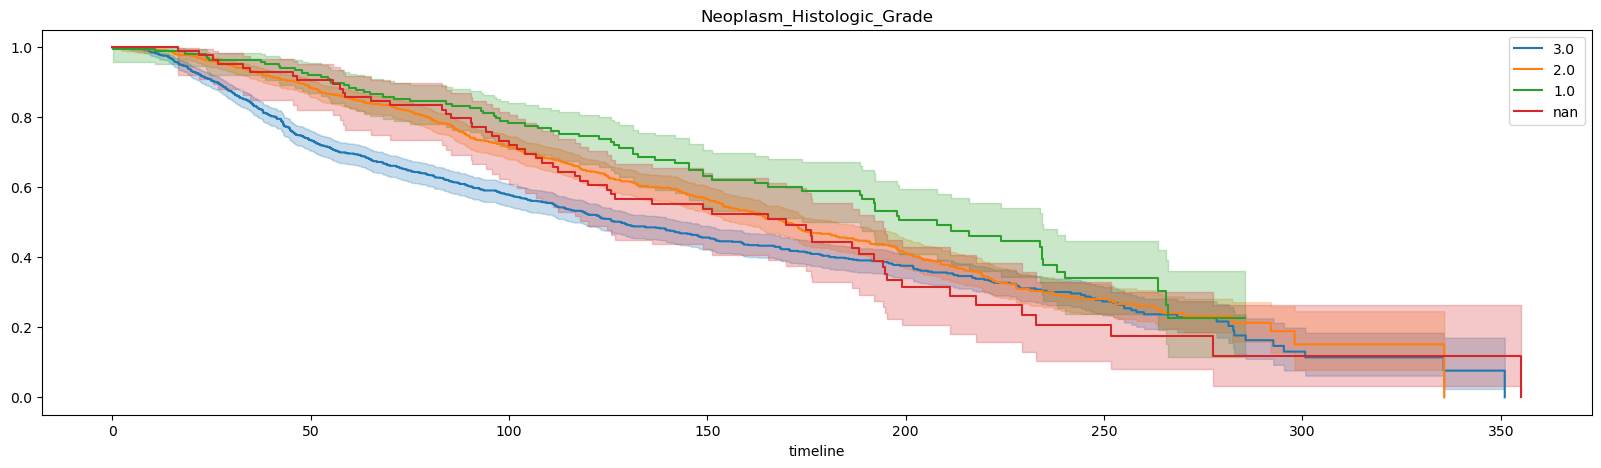

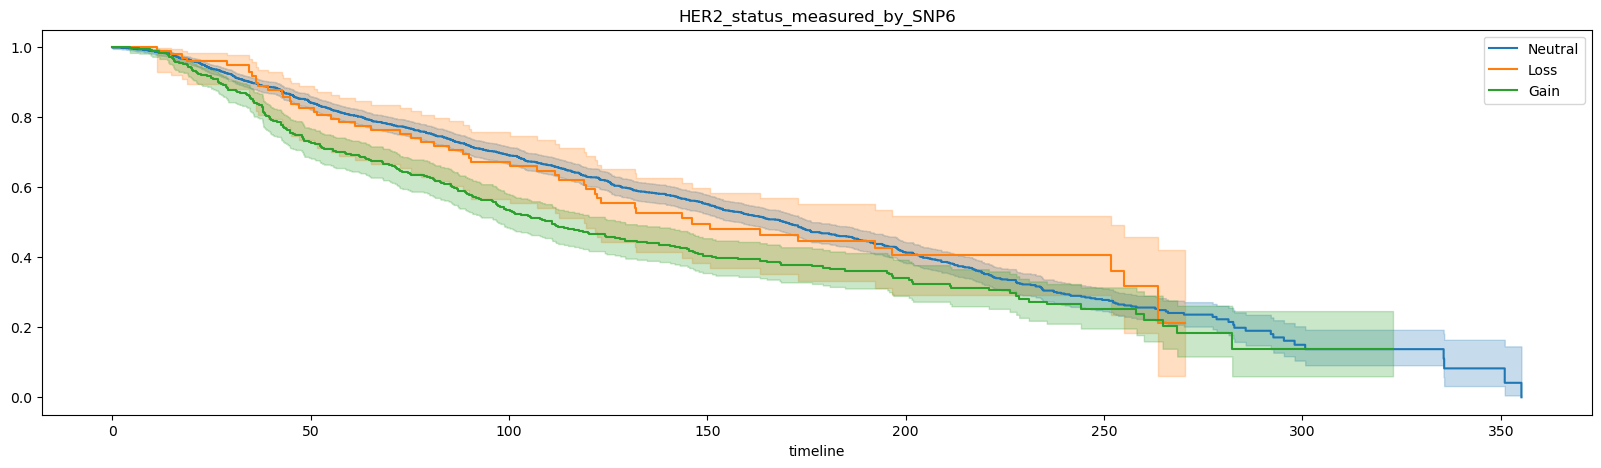

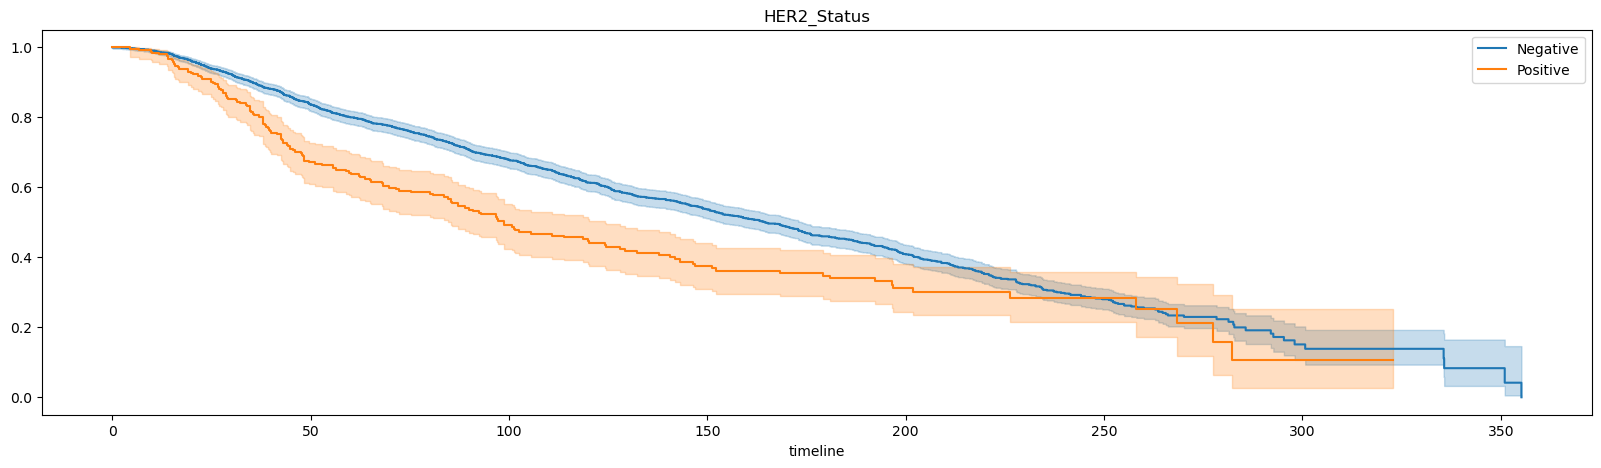

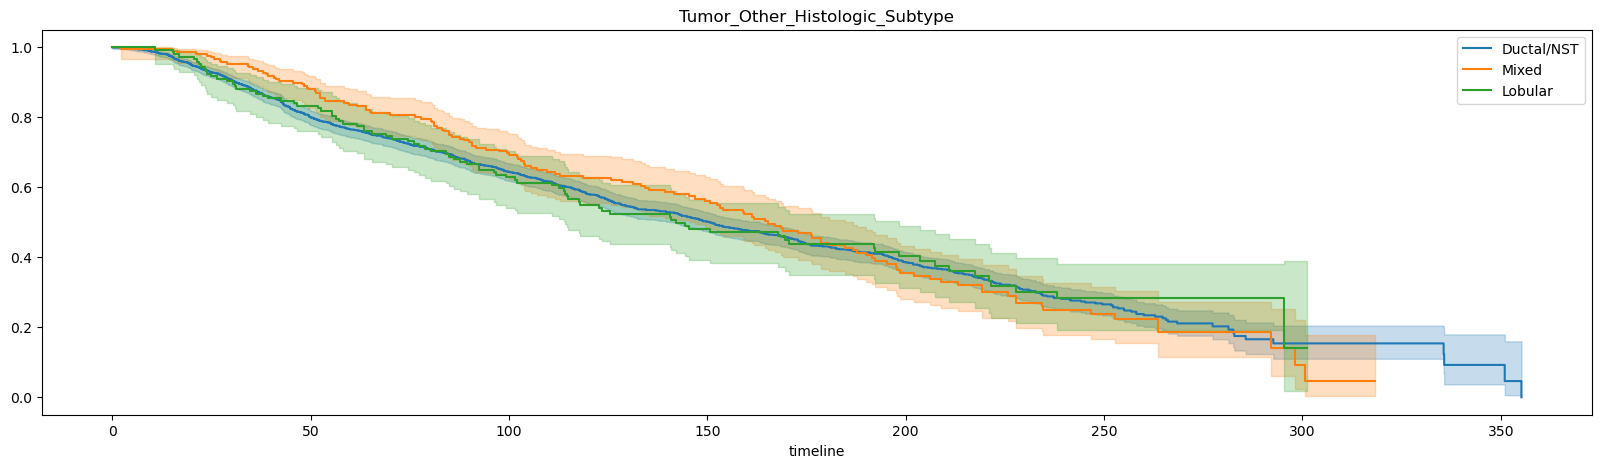

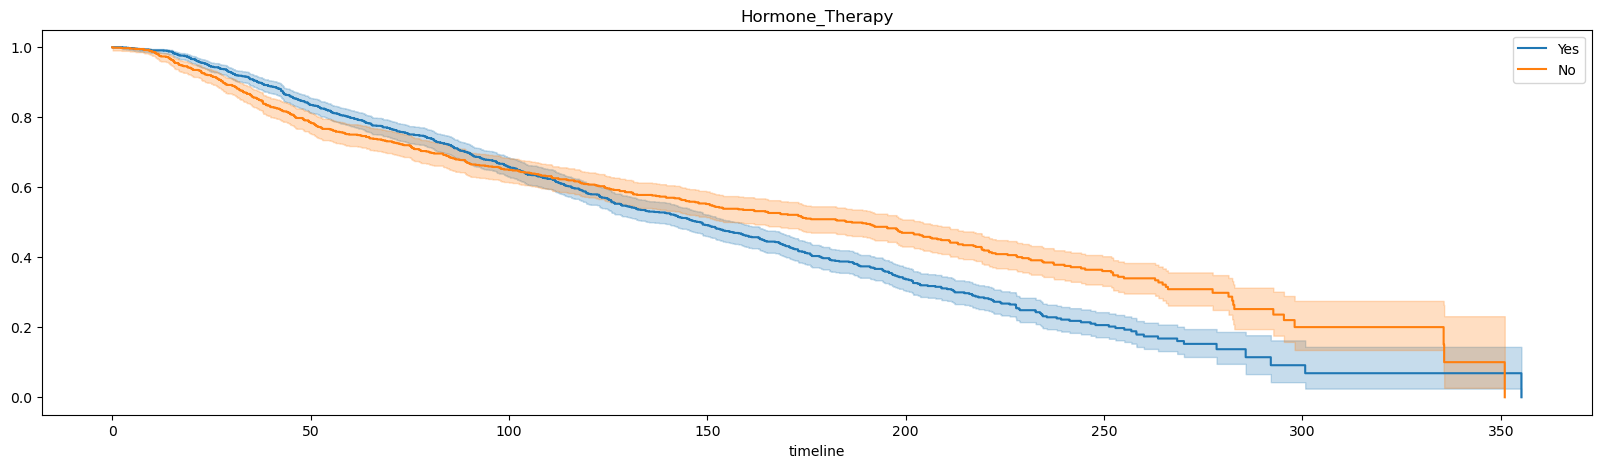

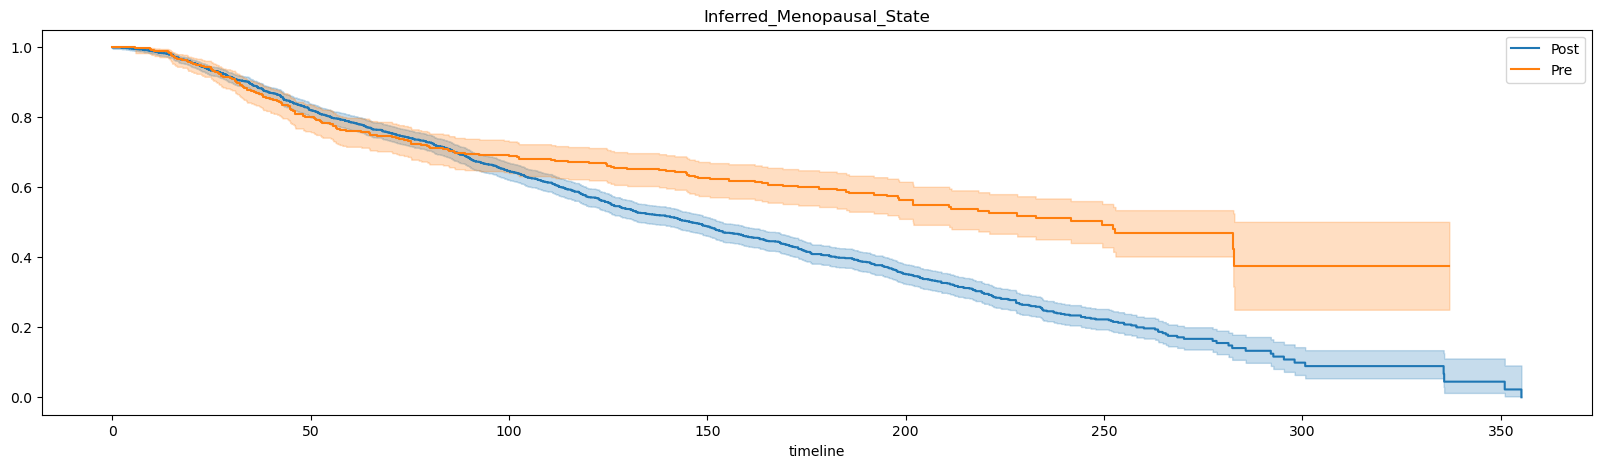

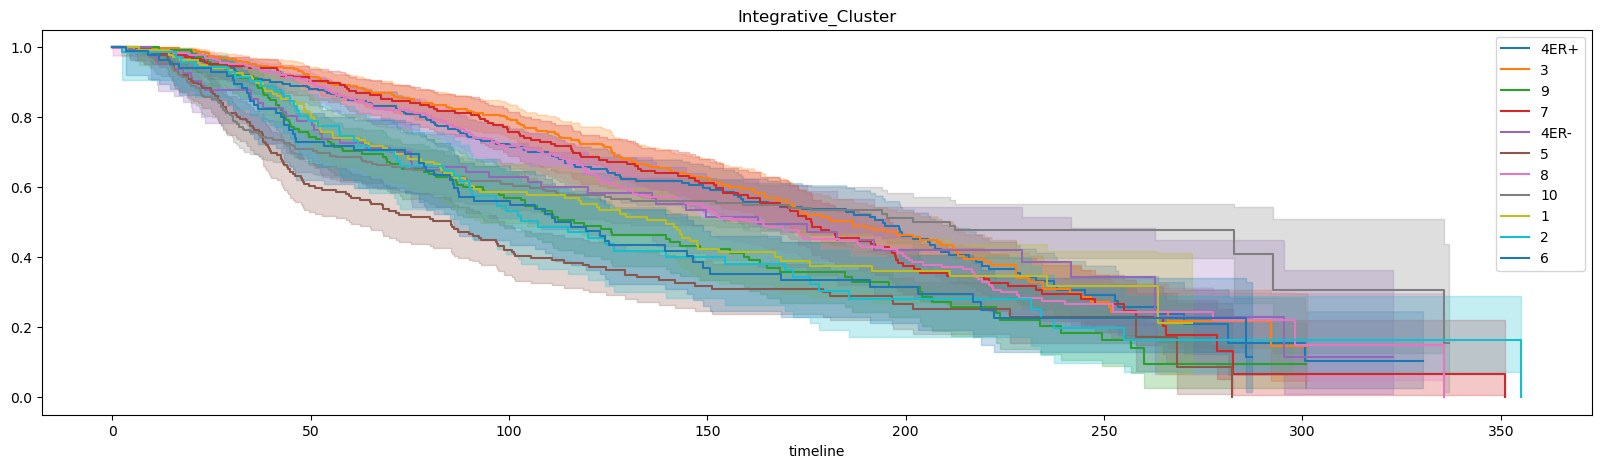

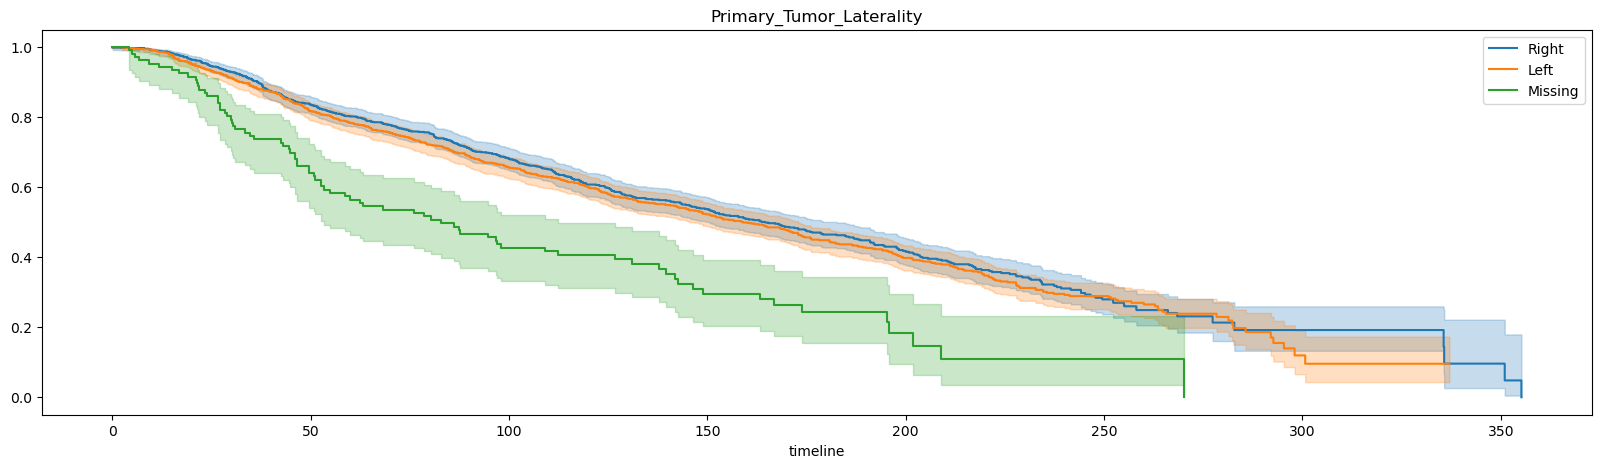

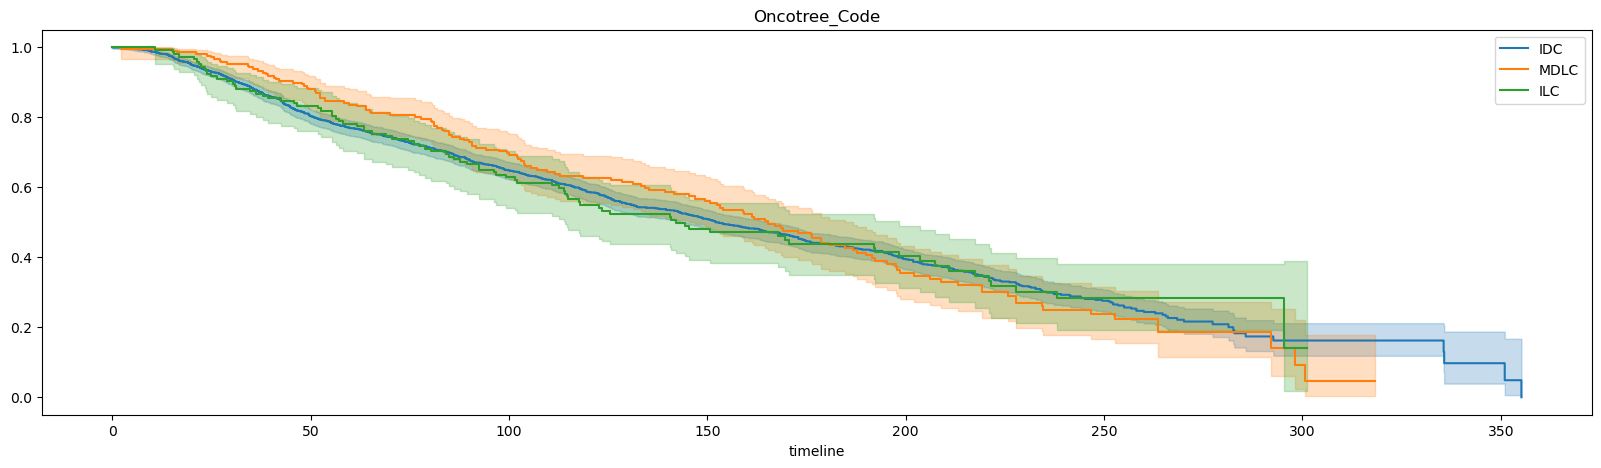

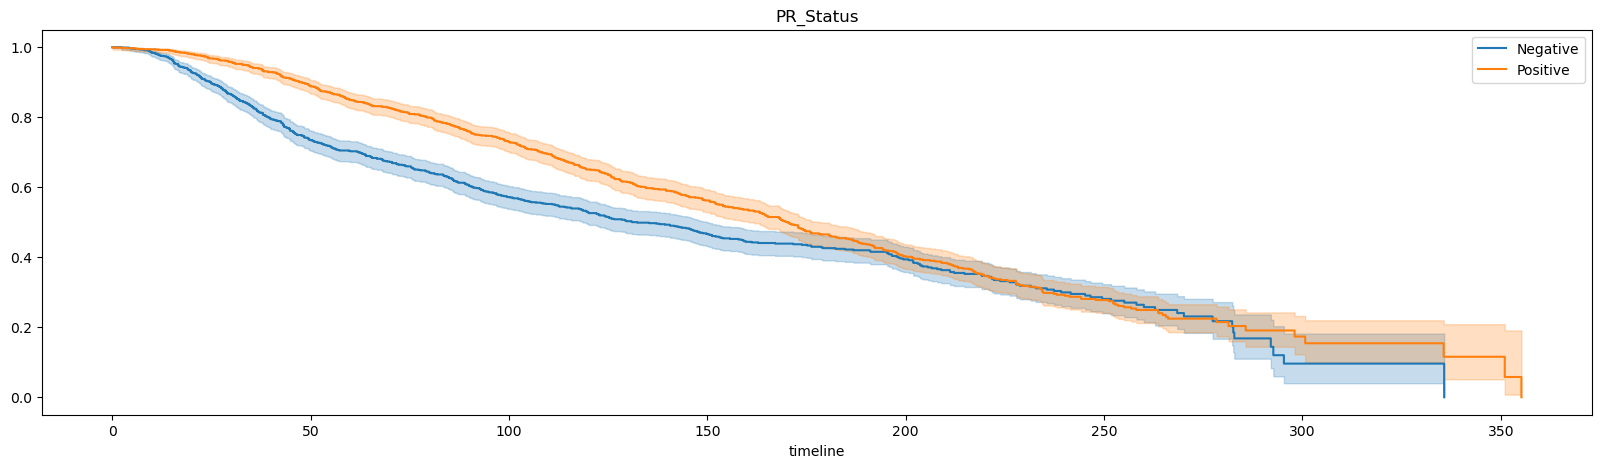

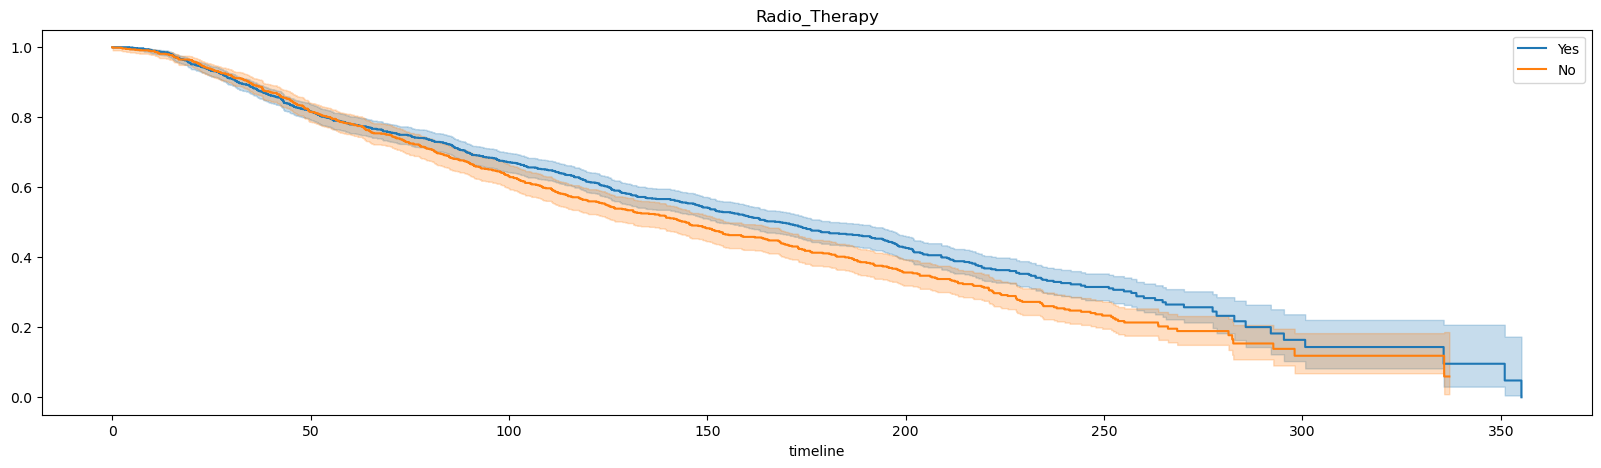

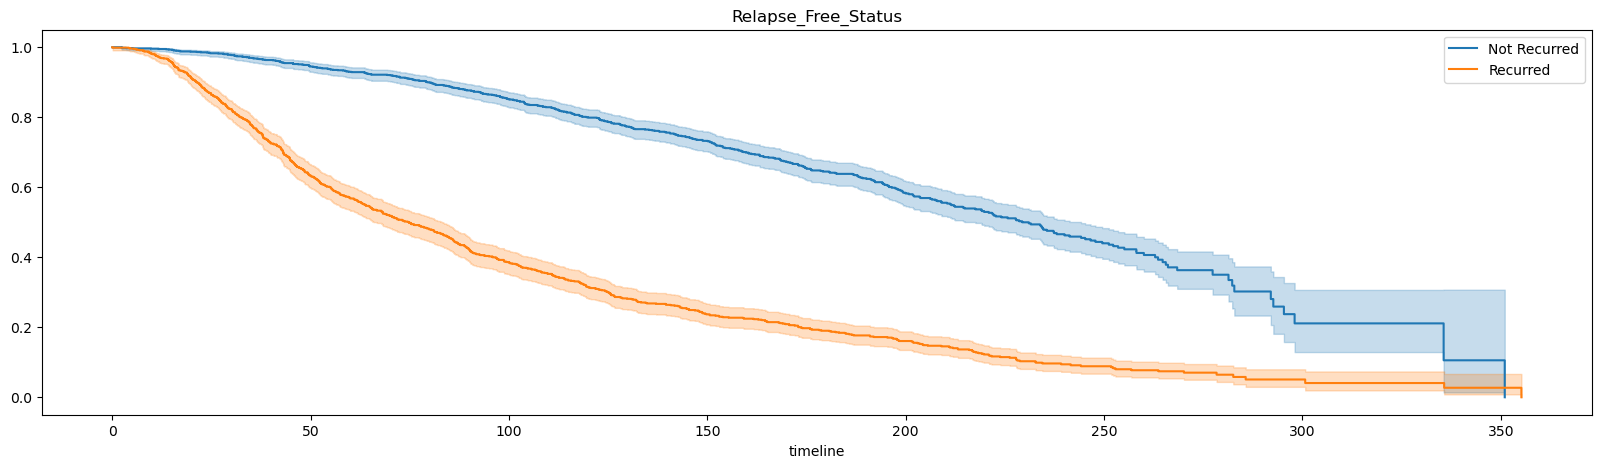

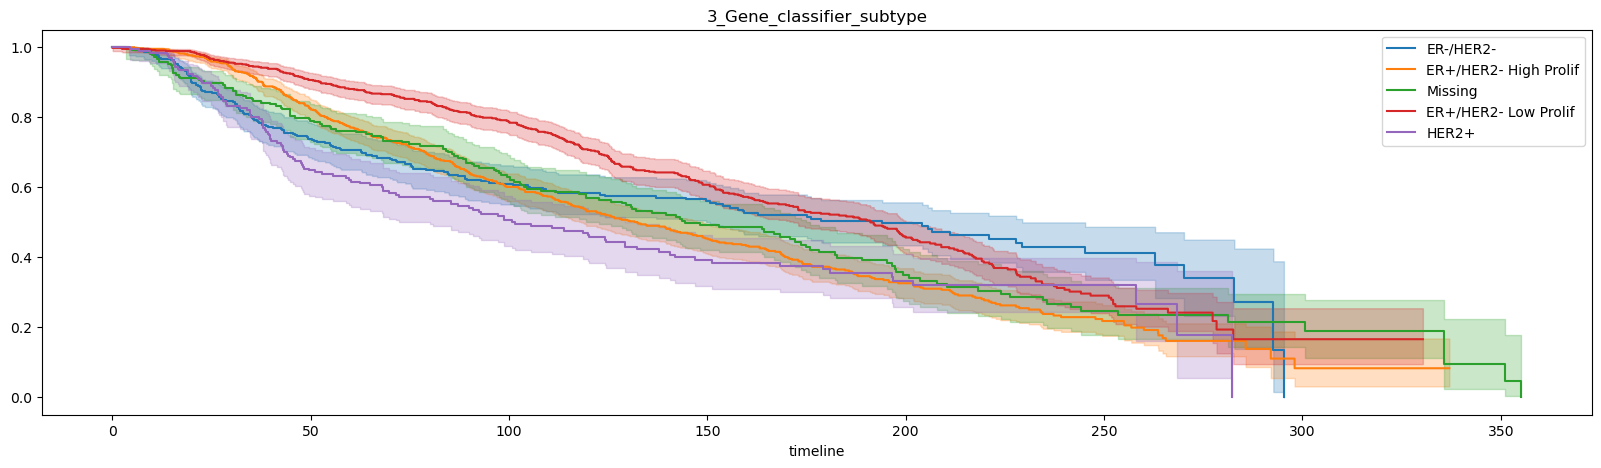

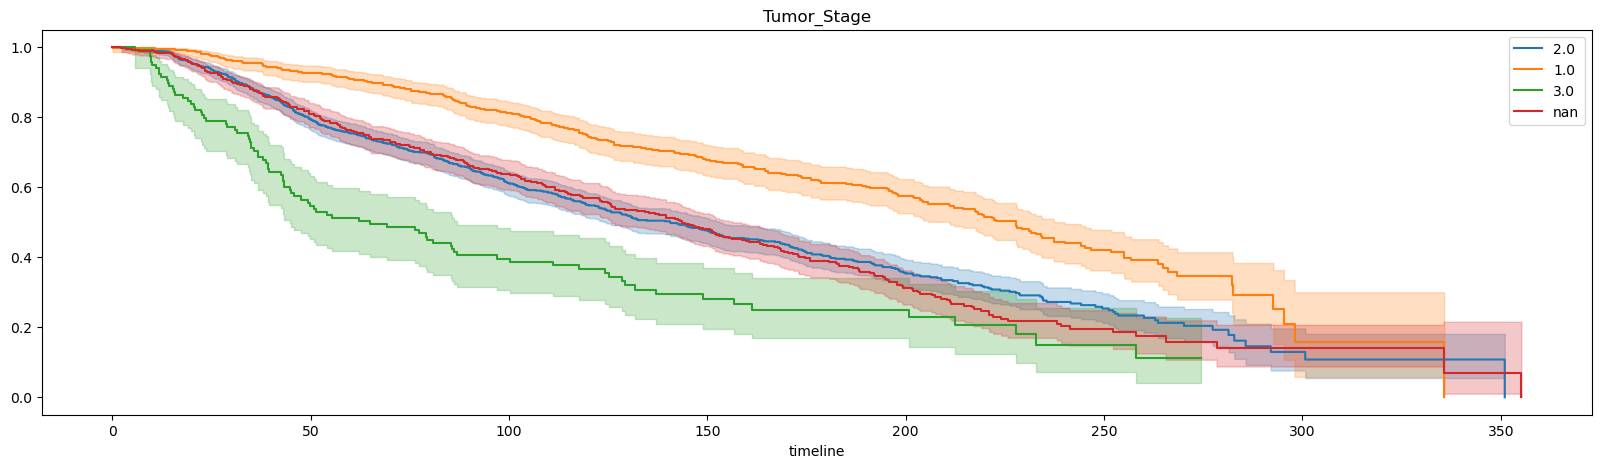

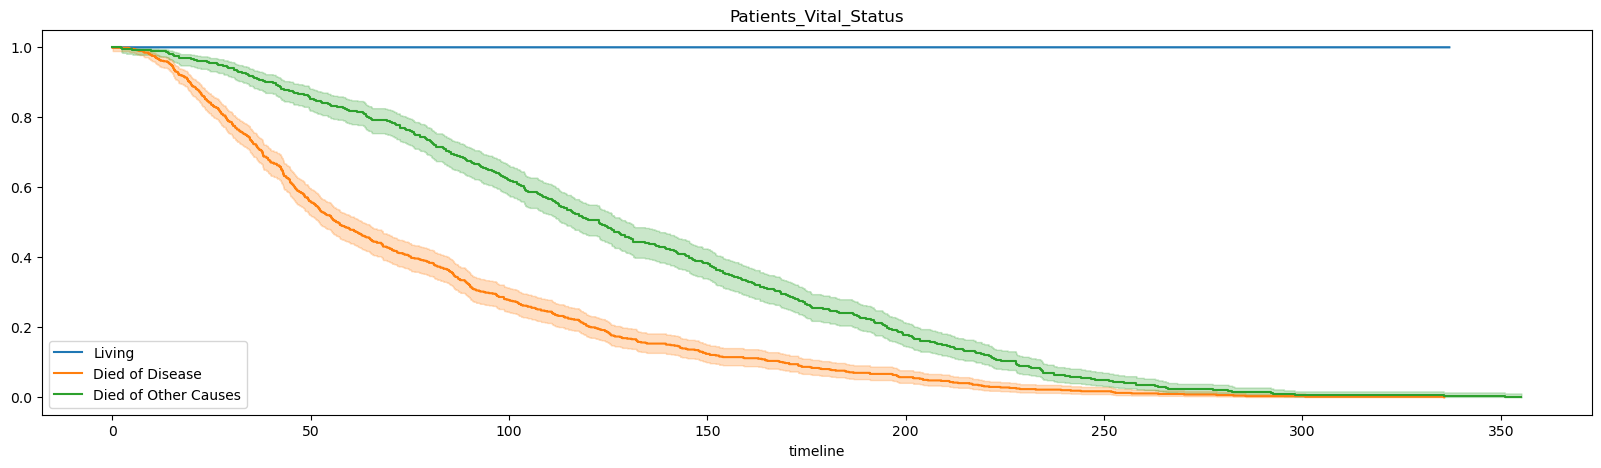

In [168]:
for c in cat_cols:
    plt.figure(figsize = (20,5))
    for v in df[c].unique(): 
        m = df[c] == v
        
        if m.sum() < 50: continue 
        T = df['Overall_Survival_Months'][m] 
        E = df['Overall_Survival_Status_n'][m]

        kmf = KaplanMeierFitter(label=v)
        kmf.fit(T,E)
        kmf.plot()
        plt.title(c)

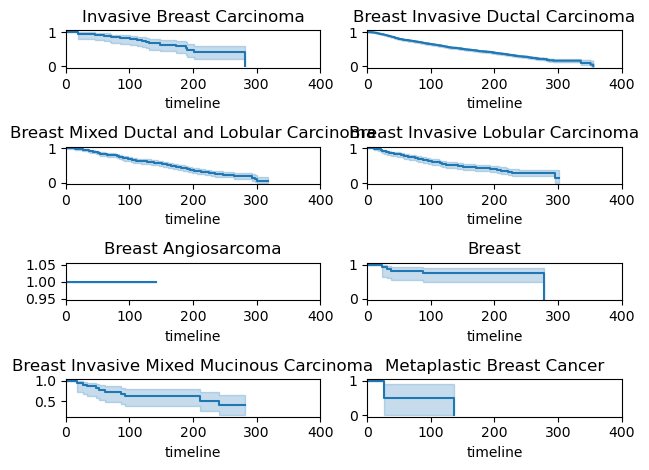

In [31]:
ecog_types = list(set(s_data.Cancer_Type_Detailed))

for i, ecog_types in enumerate(ecog_types):
  ax = plt.subplot(4, 2, i + 1)
  ix = s_data['Cancer_Type_Detailed'] == ecog_types
  kmf.fit(T[ix], E[ix], label = ecog_types)
  kmf.plot_survival_function(ax = ax, legend = False)
  plt.title(ecog_types)
  plt.xlim(0, 400)
    
plt.tight_layout()
plt.show()

### Cox Proportional Hazard Model (Semi-Parametric)

In [103]:
########################
### One hot encoding ###
########################

cat_cols = list(df.select_dtypes(include=['object']))
cat_cols.remove('Patient_ID')
cat_cols.remove('Overall_Survival_Status')
cat_cols.remove('Patients_Vital_Status')

ohe = OneHotEncoder()
# (357127, 56)

### Train ###

ohe.fit(df[cat_cols])
colnames = ohe.get_feature_names_out(cat_cols)

cat_data_train = ohe_dset(df,cat_cols)  ### Train ###

for name in list(cat_data_train.columns):
    cat_data_train[name] = cat_data_train[name].astype(int)

(1981, 108)


In [104]:
print(list(cat_data_train.columns))

['Type_of_Breast_Surgery_Breast Conserving', 'Type_of_Breast_Surgery_Mastectomy', 'Type_of_Breast_Surgery_Missing', 'Cancer_Type_Breast Cancer', 'Cancer_Type_Breast Sarcoma', 'Cancer_Type_Detailed_Breast', 'Cancer_Type_Detailed_Breast Angiosarcoma', 'Cancer_Type_Detailed_Breast Invasive Ductal Carcinoma', 'Cancer_Type_Detailed_Breast Invasive Lobular Carcinoma', 'Cancer_Type_Detailed_Breast Invasive Mixed Mucinous Carcinoma', 'Cancer_Type_Detailed_Breast Mixed Ductal and Lobular Carcinoma', 'Cancer_Type_Detailed_Invasive Breast Carcinoma', 'Cancer_Type_Detailed_Metaplastic Breast Cancer', 'Cellularity_High', 'Cellularity_Low', 'Cellularity_Missing', 'Cellularity_Moderate', 'Chemotherapy_Missing', 'Chemotherapy_No', 'Chemotherapy_Yes', 'Pam50__Claudin_low_subtype_Basal', 'Pam50__Claudin_low_subtype_Her2', 'Pam50__Claudin_low_subtype_LumA', 'Pam50__Claudin_low_subtype_LumB', 'Pam50__Claudin_low_subtype_Missing', 'Pam50__Claudin_low_subtype_NC', 'Pam50__Claudin_low_subtype_Normal', 'Pam50

In [105]:
cat_data_train = cat_data_train.reset_index(drop = True)
df = df.reset_index(drop = True)
train_data = pd.concat([cat_data_train, df[num_cols + ['Overall_Survival_Status_n']]], axis = 1)
#print(list(train_data.columns))
print(train_data.shape, cat_data_train.shape)

(1981, 115) (1981, 108)


['Type_of_Breast_Surgery_Mastectomy', 'Cancer_Type_Breast Sarcoma', 'Cancer_Type_Detailed_Breast Angiosarcoma', 'Chemotherapy_Yes', 'Pam50__Claudin_low_subtype_Missing', 'ER_status_measured_by_IHC_Positve', 'ER_Status_Positive', 'HER2_status_measured_by_SNP6_Missing', 'HER2_status_measured_by_SNP6_Neutral', 'HER2_Status_Missing', 'HER2_Status_Positive', 'Tumor_Other_Histologic_Subtype_Ductal/NST', 'Tumor_Other_Histologic_Subtype_Lobular', 'Tumor_Other_Histologic_Subtype_Metaplastic', 'Tumor_Other_Histologic_Subtype_Missing', 'Tumor_Other_Histologic_Subtype_Mixed', 'Tumor_Other_Histologic_Subtype_Mucinous', 'Tumor_Other_Histologic_Subtype_Other', 'Hormone_Therapy_Missing', 'Hormone_Therapy_Yes', 'Inferred_Menopausal_State_Missing', 'Inferred_Menopausal_State_Pre', 'Integrative_Cluster_5', 'Integrative_Cluster_Missing', 'Primary_Tumor_Laterality_Right', 'Oncotree_Code_BRCA', 'Oncotree_Code_BREAST', 'Oncotree_Code_IDC', 'Oncotree_Code_ILC', 'Oncotree_Code_IMMC', 'Oncotree_Code_MBC', 'Onco

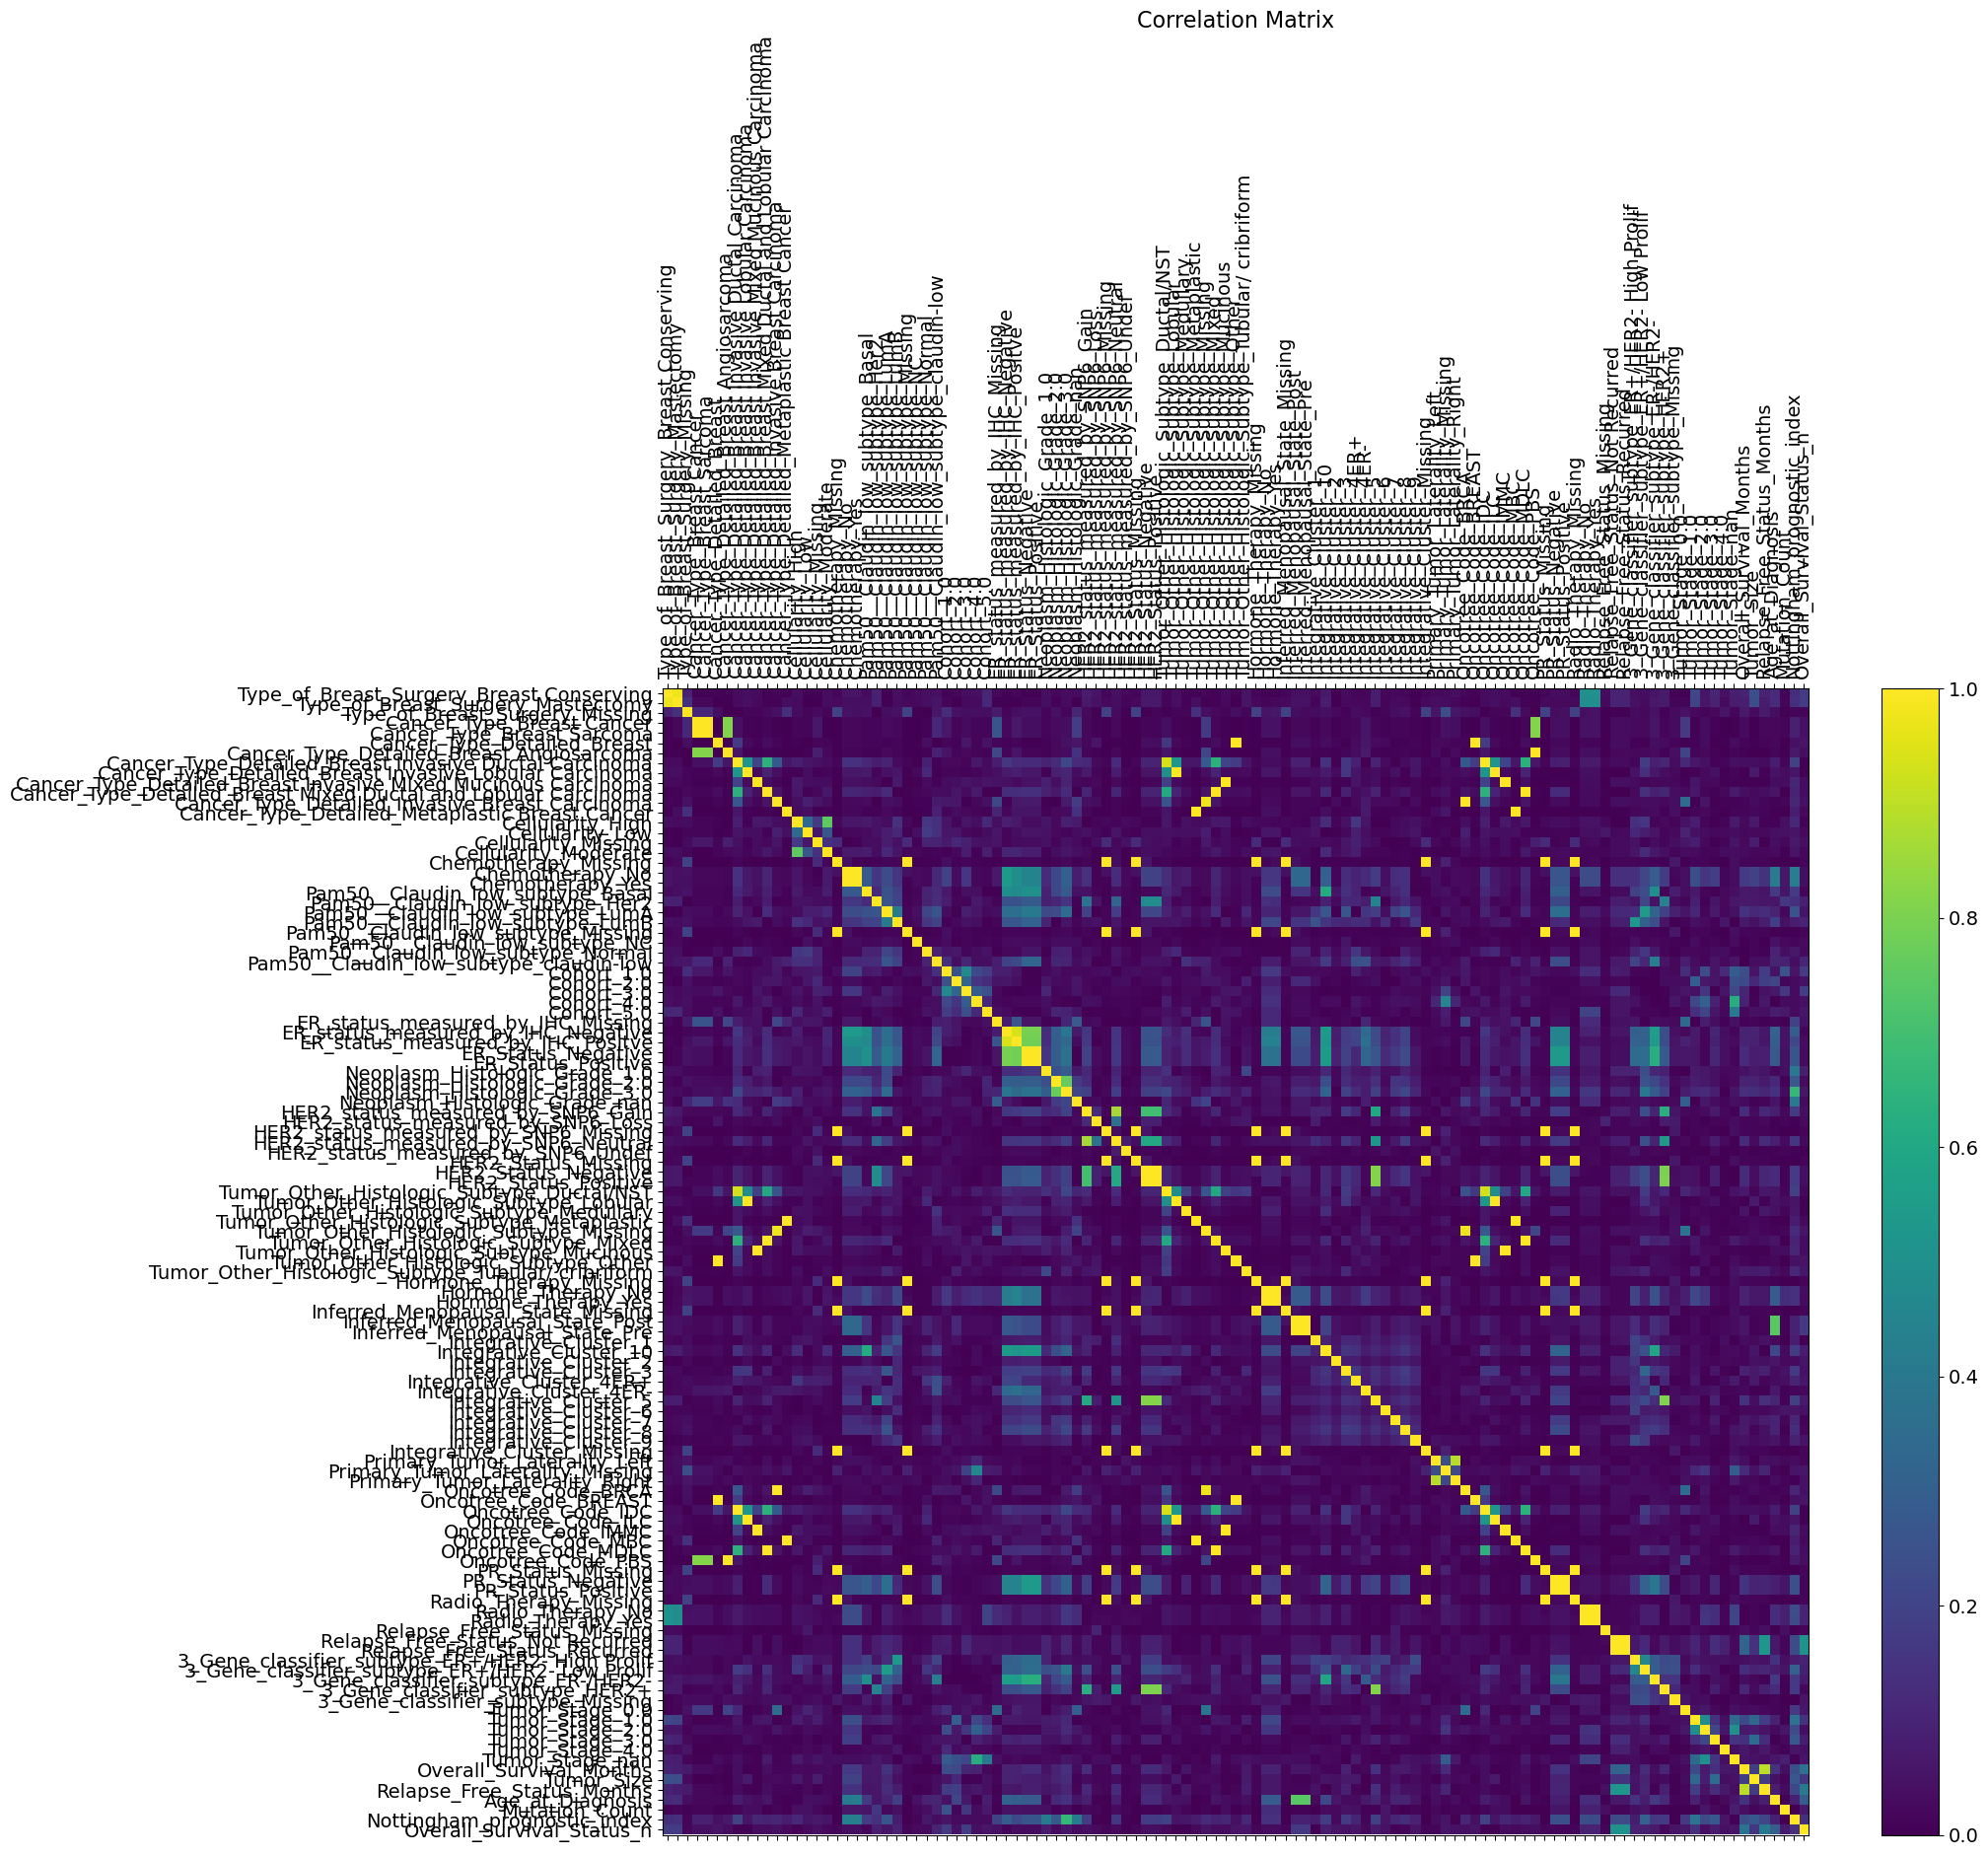

In [106]:
###################
### Correlation ###
###################

cor_matrix = train_data.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
print(to_drop)

f = plt.figure(figsize=(19, 15))
plt.matshow(cor_matrix, fignum=f.number)
plt.xticks(range(train_data.select_dtypes(['number']).shape[1]),
           train_data.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(train_data.select_dtypes(['number']).shape[1]),
           train_data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show();

In [109]:
train_data = train_data.drop(to_drop, axis = 1)

[]


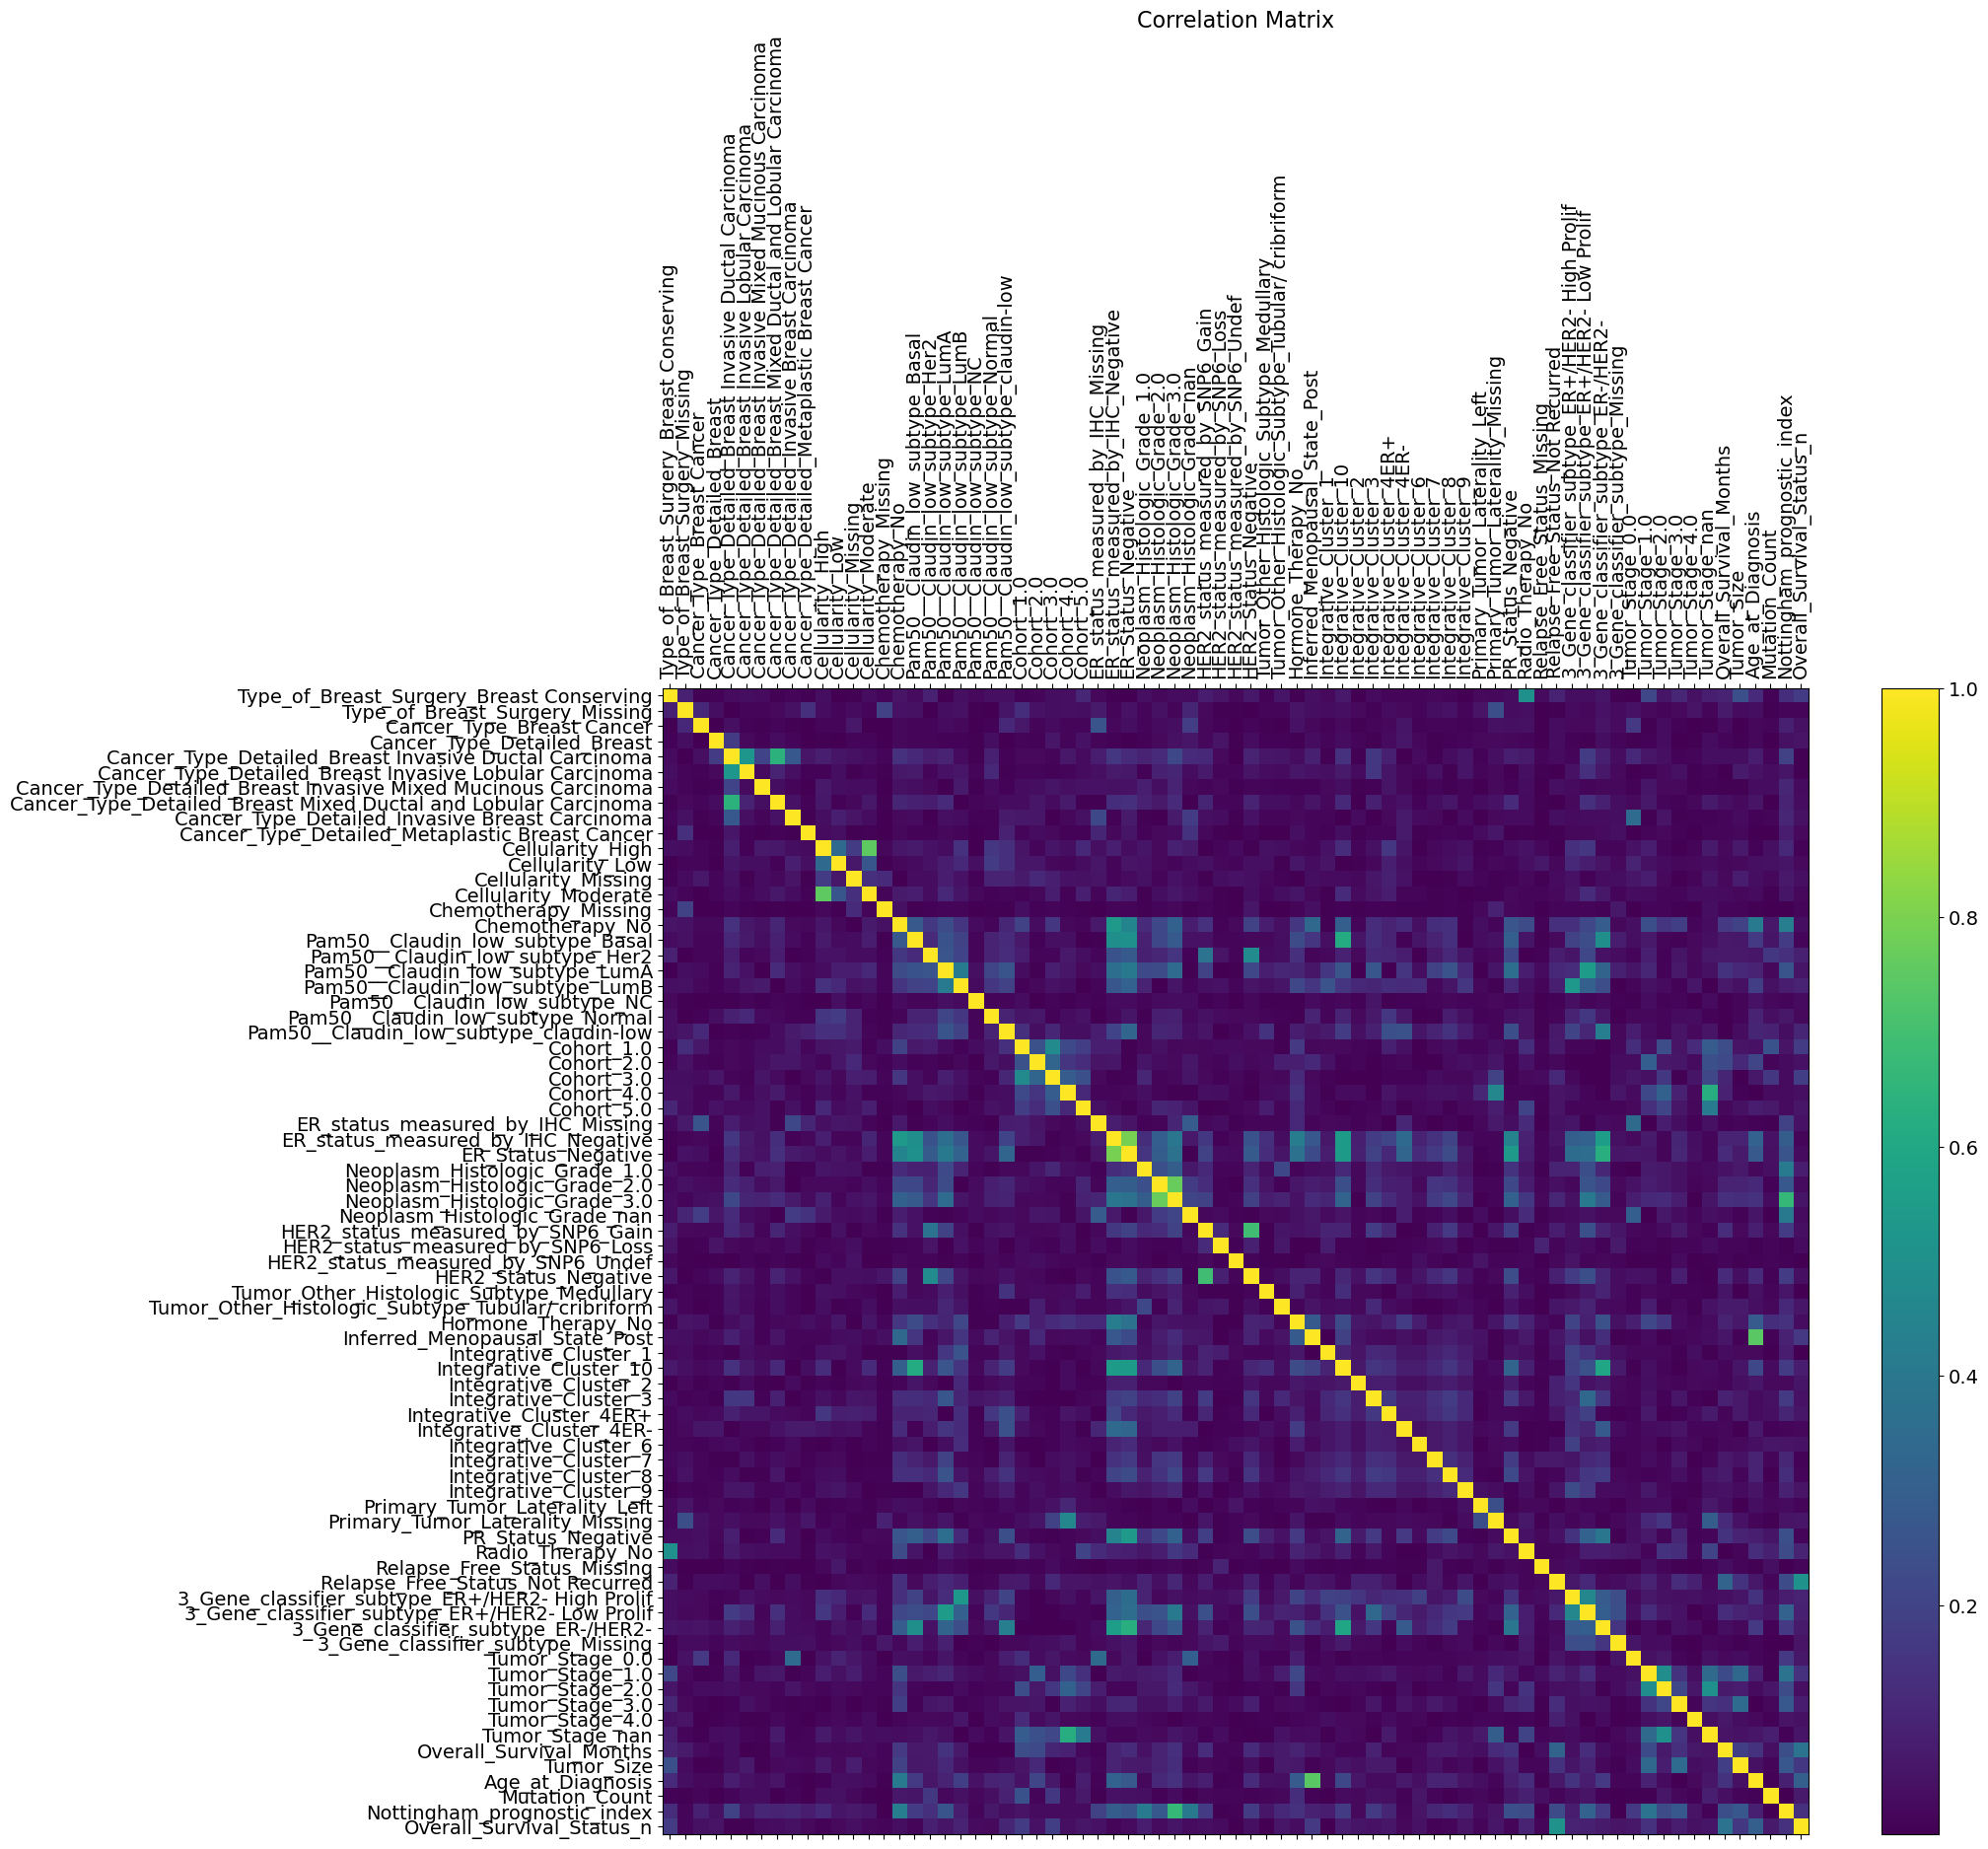

In [110]:
###################
### Correlation ###
###################

cor_matrix = train_data.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))

to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.8)]
print(to_drop)

f = plt.figure(figsize=(19, 15))
plt.matshow(cor_matrix, fignum=f.number)
plt.xticks(range(train_data.select_dtypes(['number']).shape[1]),
           train_data.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(train_data.select_dtypes(['number']).shape[1]),
           train_data.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show();

In [111]:
cph = CoxPHFitter(penalizer=0.0001)
cph.fit(train_data, duration_col = 'Overall_Survival_Months', event_col = 'Overall_Survival_Status_n')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 1981 total observations, 837 right-censored observations>
             duration col = 'Overall_Survival_Months'
                event col = 'Overall_Survival_Status_n'
                penalizer = 0.0001
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1981
number of events observed = 1144
   partial log-likelihood = -7332.73
         time fit was run = 2023-08-30 07:24:48 UTC

---
                                                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                                              
Type_of_Breast_Surgery_Breast Conserving                        -0.12       0.89       0.08            -0.28             0.04                 0.75                 1.04
Type_of_Breast_Surgery_Missing                                   0.08       1.08       0.30            -0.51             0.66                 0.60                 1.94
Cancer_Type_Breast Cancer                                        4.59      98.45      24.55           -43.52            52.70                 0.00             7.69e+22
Cancer_Type_Detailed_Breast                                     -0.65       0.52       3.67            -7.84             6.55                 0.00               697.25
Cancer_Type_Detailed_Breast Invasive Ductal Carcinoma            0.02       1.02       3.64            -7.12             7.16                 0.00              1290.45
Cancer_Type_Detailed_Breast Invasive Lobular Carcinoma           0.08       1.08       3.64            -7.07             7.22                 0.00              1368.88
Cancer_Type_Detailed_Breast Invasive Mixed Mucinous Carcinoma    0.27       1.31       3.66            -6.90             7.44                 0.00              1707.27
Cancer_Type_Detailed_Breast Mixed Ductal and Lobular Carcinoma   0.04       1.04       3.64            -7.11             7.18                 0.00              1310.51
Cancer_Type_Detailed_Invasive Breast Carcinoma                  -0.24       0.79       3.65            -7.40             6.92                 0.00              1010.02
Cancer_Type_Detailed_Metaplastic Breast Cancer                   1.96       7.10       3.72            -5.34             9.26                 0.00             10505.47
Cellularity_High                                                 0.00       1.00       2.87            -5.63             5.63                 0.00               279.02
Cellularity_Low                                                  0.11       1.12       2.87            -5.52             5.74                 0.00               311.97
Cellularity_Missing                                              0.04       1.04       2.88            -5.60             5.68                 0.00               293.83
Cellularity_Moderate                                            -0.05       0.95       2.87            -5.68             5.58                 0.00               264.72
Chemotherapy_Missing                                            -0.60       0.55       2.78            -6.05             4.84                 0.00               126.36
Chemotherapy_No                                                 -0.25       0.78       0.12            -0.48            -0.02                 0.62                 0.98
Pam50__Claudin_low_subtype_Basal                                 0.13       1.14       2.55            -4.87             5.14                 0.01               170.34
Pam50__Claudin_low_subtype_Her2                                 -0.07       0.93       2.55            -5.07             4.93                 0.01               138.52
Pam50__Claudin_low_subtype_LumA                                 -0.03       0.97       2.55            -5.03             4.97                 0.01               144.16
Pam50

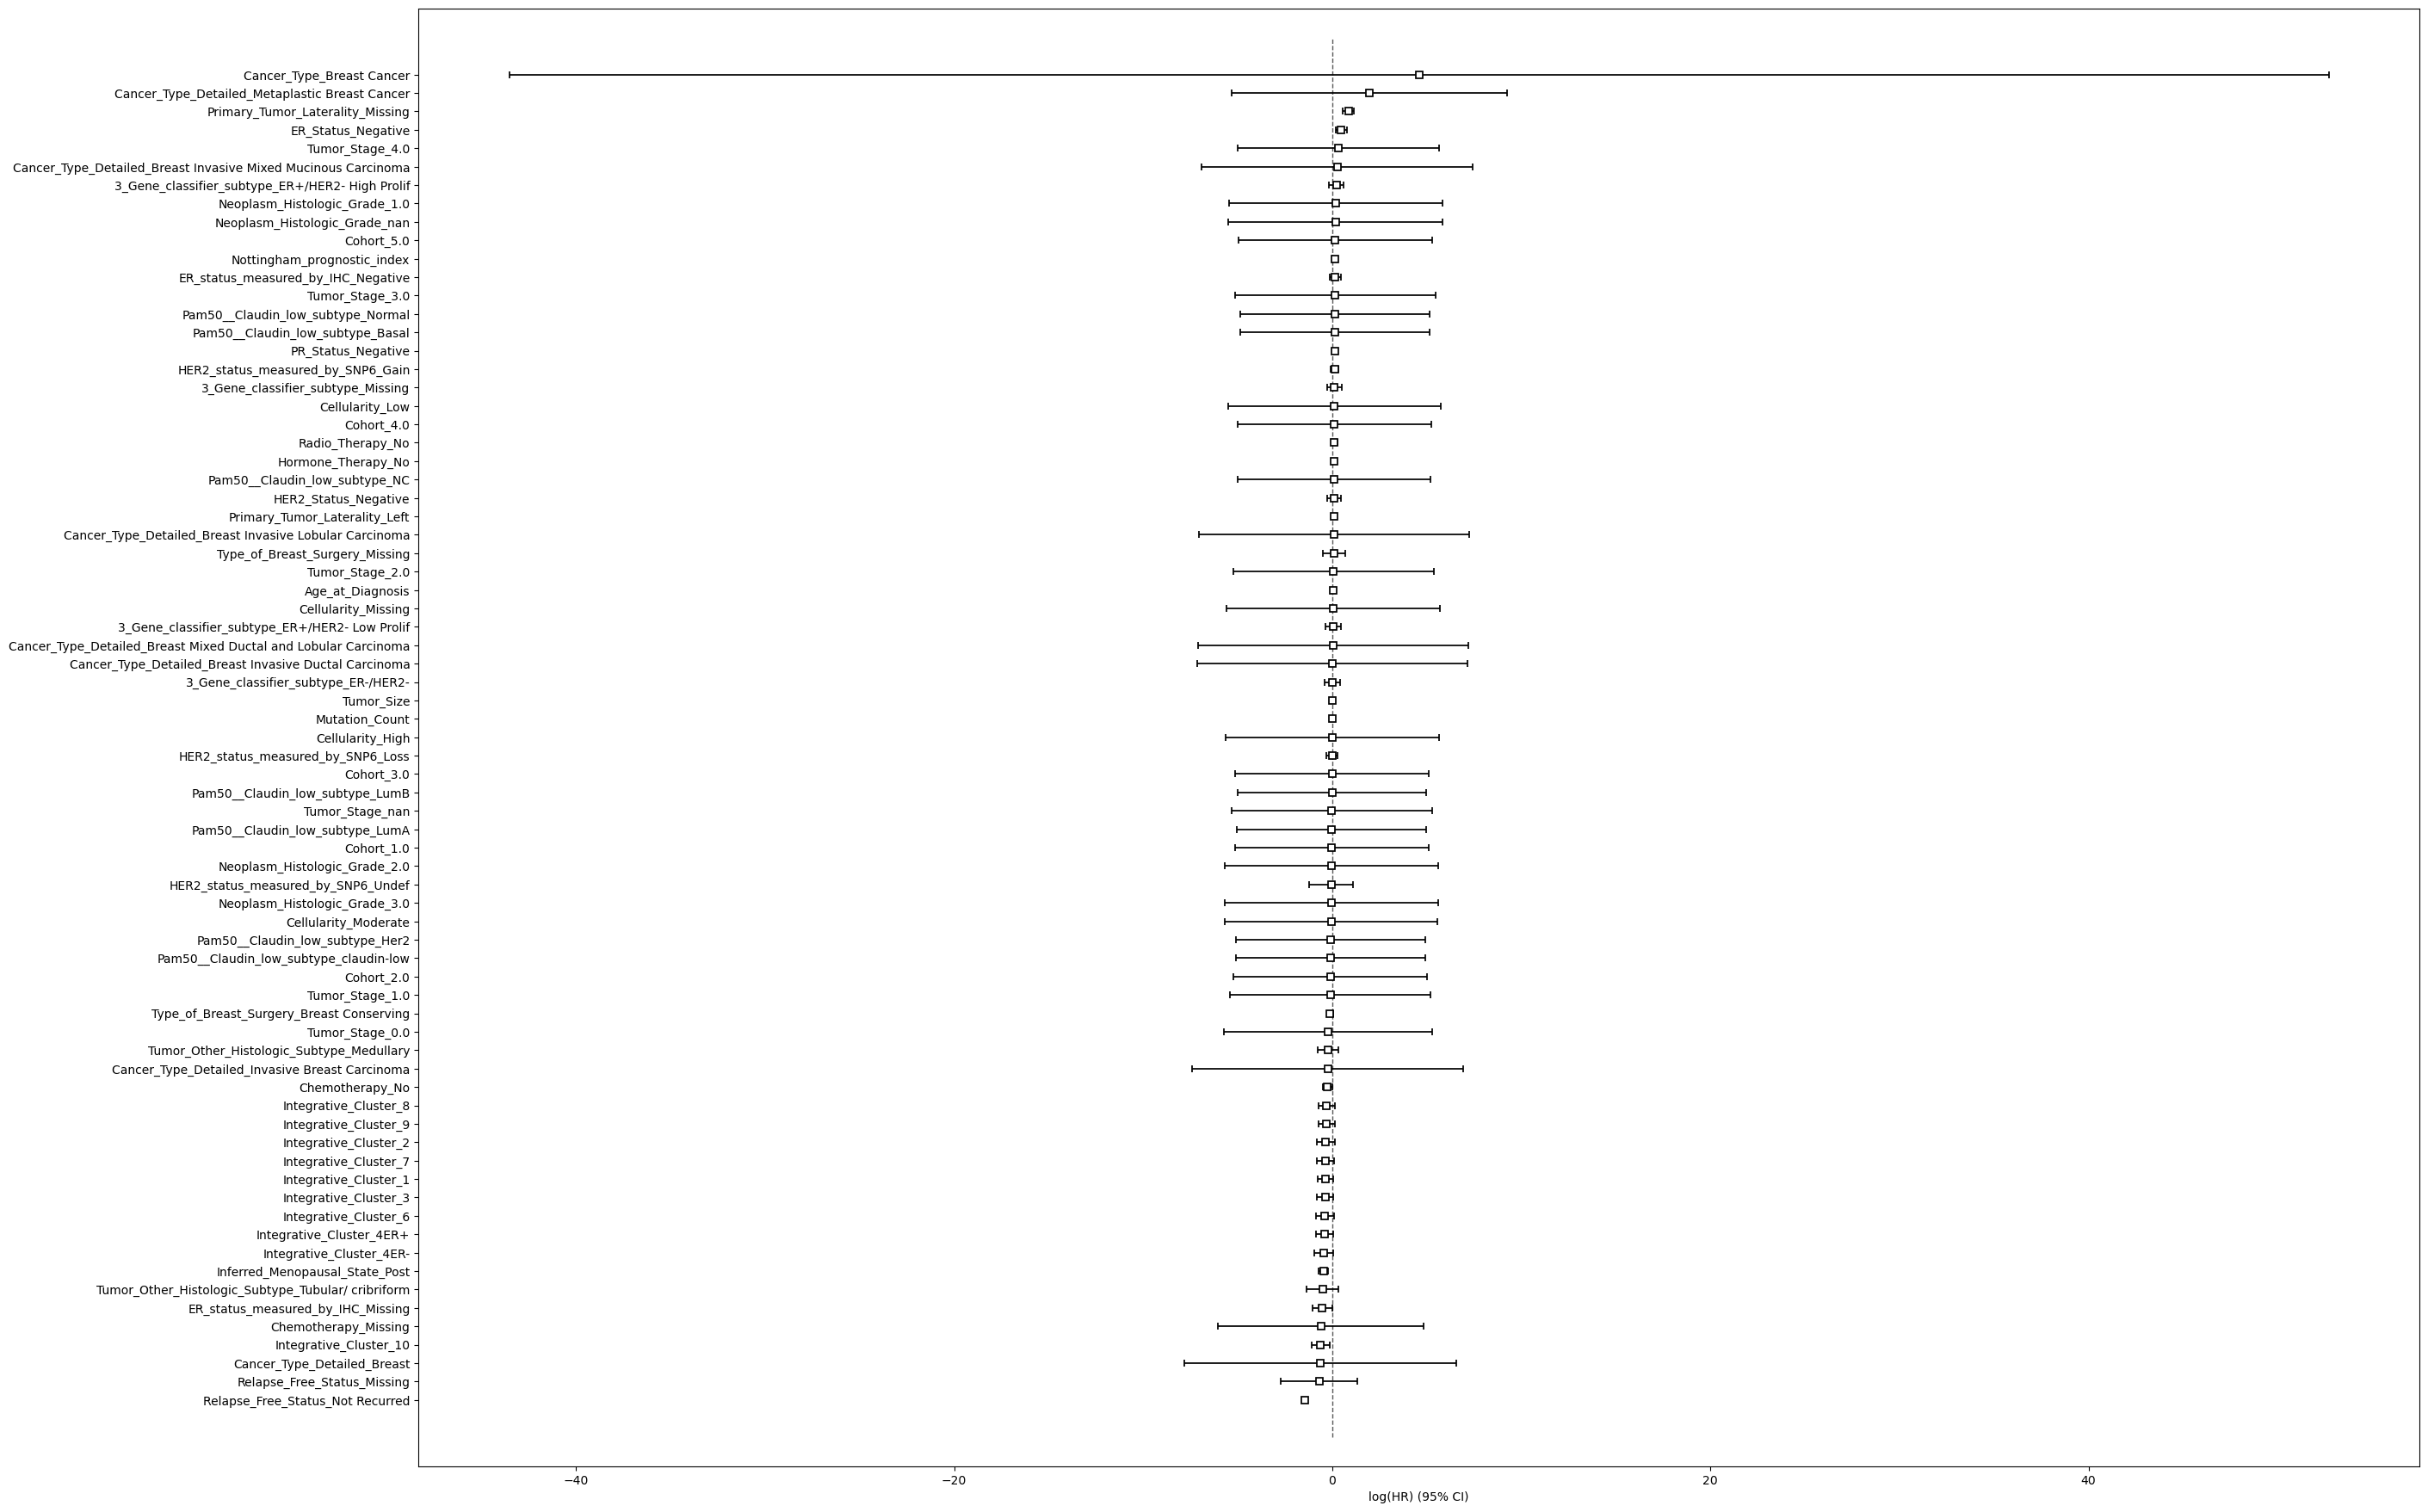

In [112]:
plt.subplots(figsize = (30, 22))
cph.plot()
plt.show()

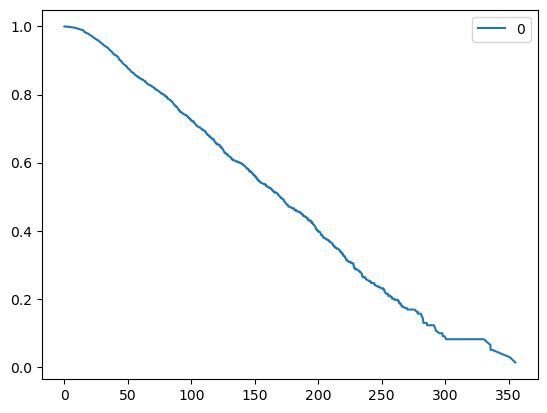

In [142]:
cph.predict_survival_function(train_data.loc[0]).plot()
plt.show()

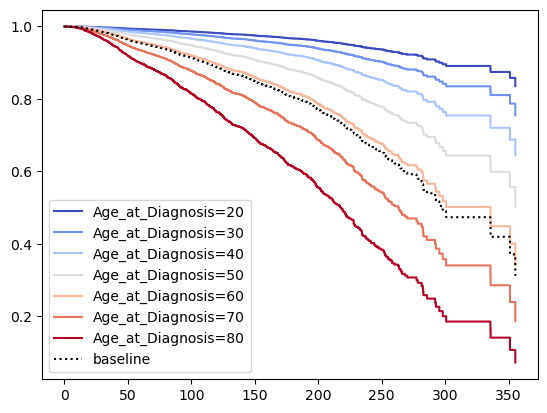

In [91]:
cph.plot_partial_effects_on_outcome(covariates = 'Age_at_Diagnosis', values = [20, 30, 40, 50, 60, 70, 80], cmap = 'coolwarm')
plt.show()

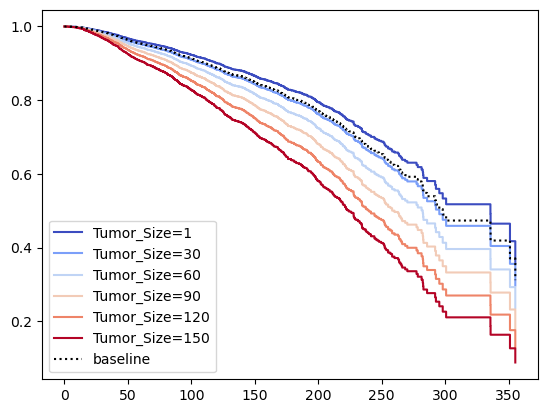

In [94]:
cph.plot_partial_effects_on_outcome(covariates = 'Tumor_Size', values = [1, 30, 60, 90, 120, 150], cmap = 'coolwarm')
plt.show()

### Check Proportional Hazard Assumption

In [113]:
#s_df = df.drop(['Patient_ID'], axis = 1)
cph.check_assumptions(train_data, p_value_threshold = 0.05)

The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1981 total observations, 837 right-censored observations>
         test_name = proportional_hazard_test

---
                                                                     test_statistic      p  -log2(p)
3_Gene_classifier_subtype_ER+/HER2- High Prolif                km              1.16   0.28      1.82
                                                               rank            1.07   0.30      1.73
3_Gene_classifier_subtype_ER+/HER2- Low Prolif                 km              1.92   0.17      2.59
                                                               rank            1.83   0.18      2.51
3_Gene_classifier_subtype_ER-/HER2-                            km              0.78   0.38      1.41
                                                               rank            0.82   0.37      1.45
3_Gene_classifier_subtype_Missing                              km              0.52   0.47      1.08
                                                               rank            0.58   0.45      1.17
Age_at_Diagnosis                                               km             21.13 <0.005     17.83
                                                               rank           21.29 <0.005     17.95
Cancer_Type_Breast Cancer                                      km              0.00   0.98      0.02
                                                               rank            0.00   0.99      0.02
Cancer_Type_Detailed_Breast                                    km              0.03   0.87      0.21
                                                               rank            0.04   0.84      0.25
Cancer_Type_Detailed_Breast Invasive Ductal Carcinoma          km              0.00   1.00      0.00
                                                               rank            0.00   1.00      0.00
Cancer_Type_Detailed_Breast Invasive Lobular Carcinoma         km              0.00   0.98      0.04
                                                               rank            0.00   0.98      0.03
Cancer_Type_Detailed_Breast Invasive Mixed Mucinous Carcinoma  km              0.01   0.91      0.14
                                                               rank            0.02   0.90      0.15
Cancer_Type_Detailed_Breast Mixed Ductal and Lobular Carcinoma km              0.00   0.96      0.05
                                                               rank            0.00   0.96      0.06
Cancer_Type_Detailed_Invasive Breast Carcinoma                 km              0.00   0.99      0.01
                                                               rank            0.00   0.99      0.02
Cancer_Type_Detailed_Metaplastic Breast Cancer                 km              0.18   0.67      0.58
                                                               rank            0.17   0.68      0.56
Cellularity_High                                               km              0.00   1.00      0.00
                                                               rank            0.00   1.00      0.00
Cellularity_Low                                                km              0.00   0.99      0.01
                                                               rank            0.00   0.99      0.02
Cellularity_Missing                                            km              0.01   0.90      0.15
                                                               rank            0.01   0.91      0.14
Cellularity_Moderate                                           km              0.00   0.98      0.03
                                                               rank            0.00   0.98      0.03
Chemotherapy_Missing                                           km              0.04   0.84      0.26
                                                               rank            0.02   



1. Variable 'Type_of_Breast_Surgery_Missing' failed the non-proportional test: p-value is 0.0090.

   Advice: with so few unique values (only 2), you can include
`strata=['Type_of_Breast_Surgery_Missing', ...]` in the call in `.fit`. See documentation in link
[E] below.

2. Variable 'Chemotherapy_No' failed the non-proportional test: p-value is 0.0355.

   Advice: with so few unique values (only 2), you can include `strata=['Chemotherapy_No', ...]` in
the call in `.fit`. See documentation in link [E] below.

3. Variable 'Hormone_Therapy_No' failed the non-proportional test: p-value is 0.0024.

   Advice: with so few unique values (only 2), you can include `strata=['Hormone_Therapy_No', ...]`
in the call in `.fit`. See documentation in link [E] below.

4. Variable 'Integrative_Cluster_3' failed the non-proportional test: p-value is 0.0535.

   Advice: with so few unique values (only 2), you can include `strata=['Integrative_Cluster_3',
...]` in the call in `.fit`. See documentation in

[]

In [114]:
results = proportional_hazard_test(cph, train_data, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1981 total observations, 837 right-censored observations>
         test_name = proportional_hazard_test

---
                                                                test_statistic      p  -log2(p)
3_Gene_classifier_subtype_ER+/HER2- High Prolif                           1.07   0.30      1.73
3_Gene_classifier_subtype_ER+/HER2- Low Prolif                            1.83   0.18      2.51
3_Gene_classifier_subtype_ER-/HER2-                                       0.82   0.37      1.45
3_Gene_classifier_subtype_Missing                                         0.58   0.45      1.17
Age_at_Diagnosis                                                         21.29 <0.005     17.95
Cancer_Type_Breast Cancer                                                 0.00   0.99      0.02
Cancer_Type_Detailed_Breast                                               0.04   0.84      0.25
Cancer_Type_Detailed_Breast Invasive Ductal Carcinoma                     0.00   1.00      0.00
Cancer_Type_Detailed_Breast Invasive Lobular Carcinoma                    0.00   0.98      0.03
Cancer_Type_Detailed_Breast Invasive Mixed Mucinous Carcinoma             0.02   0.90      0.15
Cancer_Type_Detailed_Breast Mixed Ductal and Lobular Carcinoma            0.00   0.96      0.06
Cancer_Type_Detailed_Invasive Breast Carcinoma                            0.00   0.99      0.02
Cancer_Type_Detailed_Metaplastic Breast Cancer                            0.17   0.68      0.56
Cellularity_High                                                          0.00   1.00      0.00
Cellularity_Low                                                           0.00   0.99      0.02
Cellularity_Missing                                                       0.01   0.91      0.14
Cellularity_Moderate                                                      0.00   0.98      0.03
Chemotherapy_Missing                                                      0.02   0.88      0.18
Chemotherapy_No                                                           4.42   0.04      4.82
Cohort_1.0                                                                0.00   0.99      0.01
Cohort_2.0                                                                0.01   0.93      0.11
Cohort_3.0                                                                0.00   0.97      0.04
Cohort_4.0                                                                0.01   0.91      0.13
Cohort_5.0                                                                0.01   0.90      0.14
ER_Status_Negative                                                        0.98   0.32      1.63
ER_status_measured_by_IHC_Missing                                         2.73   0.10      3.34
ER_status_measured_by_IHC_Negative                                        0.09   0.76      0.39
HER2_Status_Negative                                                      2.57   0.11      3.20
HER2_status_measured_by_SNP6_Gain                                         0.15   0.70      0.51
HER2_status_measured_by_SNP6_Loss                                         0.02   0.89      0.18
HER2_status_measured_by_SNP6_Undef                                        0.13   0.72      0.48
Hormone_Therapy_No                                                        9.23 <0.005      8.72
Inferred_Menopausal_State_Post                                            1.41   0.23      2.09
Integrative_Cluster_1                                                     0.97   0.32      1.63
Integrative_Cluster_10                                                    1.05   0.31      1.71
Integrative_Cluster_2                                                     2.34   0.13      2.98
Integrative_Cluster_3                                                     3.73   0.05      4.23
Integrative_Cluster_4ER+                        

### Accelerated Failure Time (AFT) Model

In [124]:
for name in list(train_data.columns):
    train_data[name] = train_data[name] + 0.001

In [125]:
wb = WeibullFitter()
ex = ExponentialFitter()
log = LogNormalFitter()
loglogis = LogLogisticFitter()

# Fit to data
for model in [wb, ex, log, loglogis]:
    print(model)
    model.fit(durations = train_data["Overall_Survival_Months"], 
              event_observed = train_data["Overall_Survival_Status_n"])
    
    # Print AIC
    print("The AIC value for", model.__class__.__name__, "is",  model.AIC_)

<lifelines.WeibullFitter>
The AIC value for WeibullFitter is 14517.9785191729
<lifelines.ExponentialFitter>
The AIC value for ExponentialFitter is 14597.94102616161
<lifelines.LogNormalFitter>
The AIC value for LogNormalFitter is 14554.897978909492
<lifelines.LogLogisticFitter>
The AIC value for LogLogisticFitter is 14537.411877543283


In [128]:
weibull_aft = WeibullAFTFitter()
weibull_aft.fit(train_data, 
                duration_col = 'Overall_Survival_Months', 
                event_col = 'Overall_Survival_Status_n')
weibull_aft.print_summary(3)

/Users/keithlowton/anaconda3/envs/Survival_analysis/lib/python3.10/site-packages/lifelines/fitters/__init__.py:2086: StatisticalWarning: The diagonal of the variance_matrix_ has negative values. This could be a problem with WeibullAFTFitter's fit to the data.

It's advisable to not trust the variances reported, and to be suspicious of the fitted parameters too.

  warnings.warn(warning_text, exceptions.StatisticalWarning)


<lifelines.WeibullAFTFitter: fitted with 1981 total observations, 0 right-censored observations>
             duration col = 'Overall_Survival_Months'
                event col = 'Overall_Survival_Status_n'
   number of observations = 1981
number of events observed = 1981
           log-likelihood = -10951.006
         time fit was run = 2023-08-30 07:36:38 UTC

---
                                                                          coef  exp(coef)    se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param   covariate                                                                                                                                                                
lambda_ 3_Gene_classifier_subtype_ER+/HER2- High Prolif                 -0.127      0.881       0.086           -0.295            0.042                0.744                1.043
        3_Gene_classifier_subtype_ER+/HER2- Low Prolif                  -0.065      0.937       0.090           -0.242            0.111                0.785                1.117
        3_Gene_classifier_subtype_ER-/HER2-                             -0.051      0.951       0.093           -0.233            0.132                0.792                1.142
        3_Gene_classifier_subtype_Missing                               -0.026      0.974       0.086           -0.195            0.143                0.823                1.154
        Age_at_Diagnosis                                                -0.013      0.987       0.002           -0.016           -0.010                0.984                0.990
        Cancer_Type_Breast Cancer                                       11.878  1.440e+05       0.560           10.780           12.976            48043.460            4.317e+05
        Cancer_Type_Detailed_Breast                                    -11.446      0.000       0.686          -12.790          -10.102                0.000                0.000
        Cancer_Type_Detailed_Breast Invasive Ductal Carcinoma          -11.557      0.000       0.671          -12.871          -10.243                0.000                0.000
        Cancer_Type_Detailed_Breast Invasive Lobular Carcinoma         -11.573      0.000       0.672          -12.890          -10.257                0.000                0.000
        Cancer_Type_Detailed_Breast Invasive Mixed Mucinous Carcinoma  -11.717      0.000       0.681          -13.051          -10.383                0.000                0.000
        Cancer_Type_Detailed_Breast Mixed Ductal and Lobular Carcinoma -11.565      0.000       0.672          -12.882          -10.249                0.000                0.000
        Cancer_Type_Detailed_Invasive Breast Carcinoma                 -11.430      0.000       0.676          -12.755          -10.105                0.000                0.000
        Cancer_Type_Detailed_Metaplastic Breast Cancer                 -12.340      0.000       0.781          -13.870          -10.811                0.000                0.000
        Cellularity_High                                                 0.081      1.084 1177962.721     -2308764.427      2308764.589                0.000                  inf
        Cellularity_Low                                                  0.056      1.058 1177749.230     -2308346.016      2308346.129                0.000                  inf
        Cellularity_Missing                                              0.101      1.107 1179562.697     -2311900.302      2311900.505                0.000                  inf
        Cellularity_Moderate                                             0.119      1.127 1186426.629     -2325353.343      2325353.582                0.000                  inf
        Chemotherapy_Missing                                             0.858      2.359  984766.408     -1930105.834      1930107.551                0.000                  inf
        Chemotherapy_No                                                

In [130]:
print('Median survival time:',weibull_aft.median_survival_time_)
print('Mean survival time:',weibull_aft.mean_survival_time_)

Median survival time: 86.64623455438266
Mean survival time: 93.49294396004777


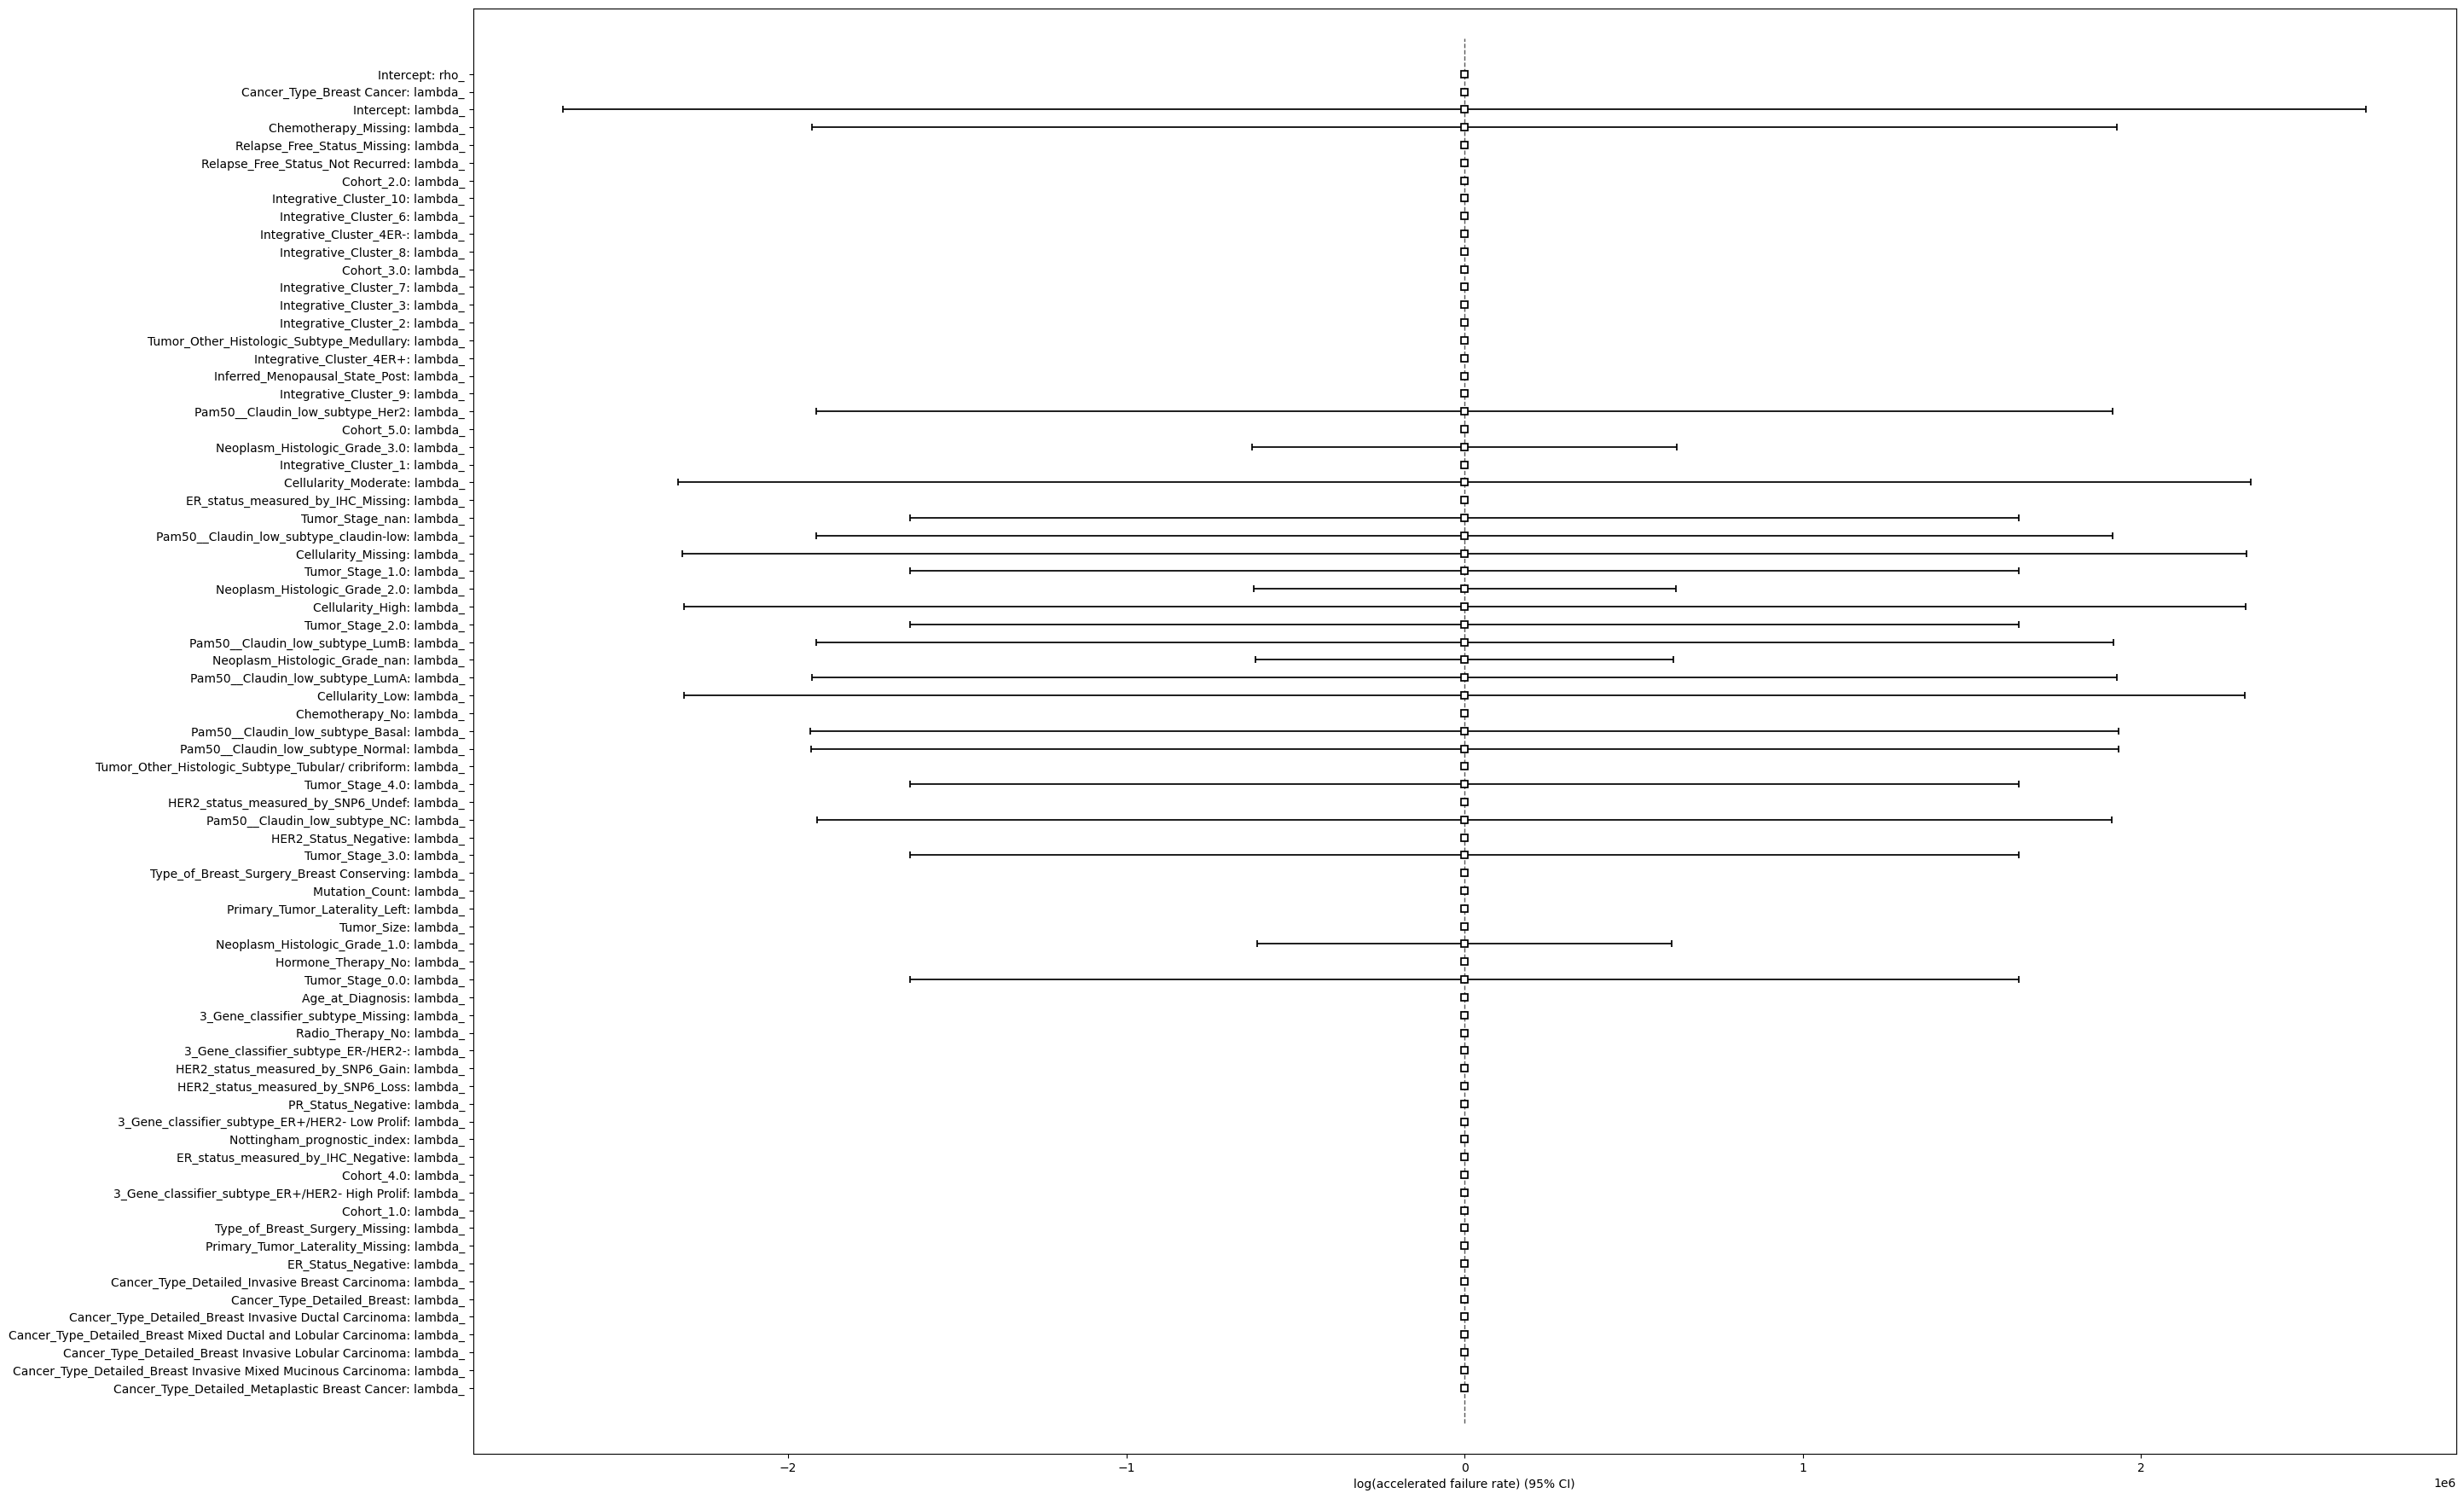

In [132]:
plt.subplots(figsize=(30, 22))
weibull_aft.plot()
plt.show()

### Plot Partial Effects on Outcome (Weibull Regression)

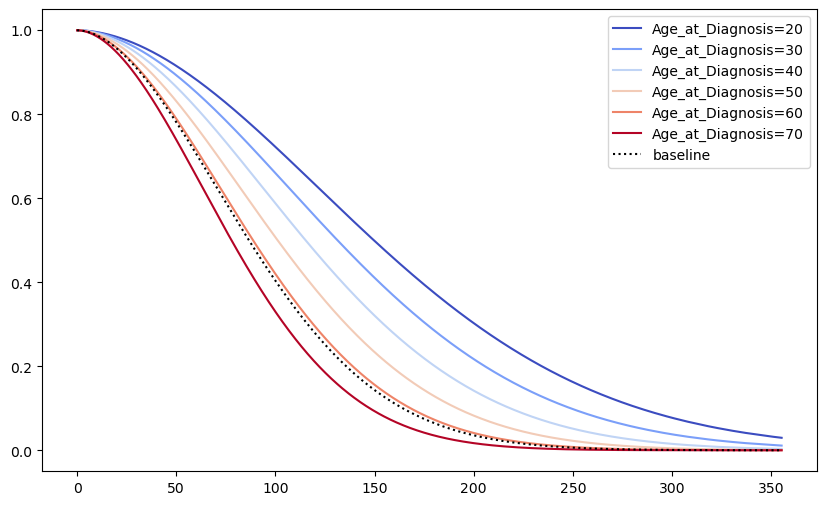

In [133]:
plt.subplots(figsize=(10, 6))
weibull_aft.plot_partial_effects_on_outcome('Age_at_Diagnosis', range(20, 80, 10), cmap='coolwarm')
plt.show()